<a href="https://colab.research.google.com/github/kushal-unjiya/EIS/blob/main/EIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages


In [12]:
!pip install impedance

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kendalltau, pearsonr

from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

from sklearn import tree
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from impedance import preprocessing
from impedance.models.circuits import CustomCircuit


# Loading and Information of the data

In [14]:
#Load data
df = pd.read_csv('INPUT-DATA.csv')
df

Ionic radius   Temperature   Frequency    Re(Z)   Img(Z)
0      1.820000e-10          -10  1000000.00   3160.0   9670.0
1      1.820000e-10          -10   926000.00   3480.0  10200.0
2      1.820000e-10          -10   858000.00   3840.0  10300.0
3      1.820000e-10          -10   794000.00   4210.0  10600.0
4      1.820000e-10          -10   736000.00   4530.0  10900.0
...             ...          ...         ...      ...      ...
4643   2.060000e-10           80        1.45  68600.0  10900.0
4644   2.060000e-10           80        1.32  69400.0  11300.0
4645   2.060000e-10           80        1.20  70300.0  11700.0
4646   2.060000e-10           80        1.10  71200.0  12100.0
4647   2.060000e-10           80        1.00  72100.0  12500.0

[4648 rows x 5 columns]

In [15]:
df.info()
df.describe()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4648 entries, 0 to 4647
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ionic radius   4648 non-null   float64
 1   Temperature    4648 non-null   int64  
 2   Frequency      4648 non-null   float64
 3   Re(Z)          4648 non-null   float64
 4   Img(Z)         4648 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 181.7 KB


(4648, 5)

*italicized text*# New Section

# Data Visualization

## Correlational Analysis

In [16]:
#correlational Matrix
df.corr()

Ionic radius   Temperature  Frequency     Re(Z)    Img(Z)
Ionic radius        1.000000     0.102802   0.000928 -0.350628 -0.372991
Temperature         0.102802     1.000000  -0.000179 -0.297979 -0.326226
Frequency           0.000928    -0.000179   1.000000 -0.162701 -0.120582
Re(Z)              -0.350628    -0.297979  -0.162701  1.000000  0.911692
Img(Z)             -0.372991    -0.326226  -0.120582  0.911692  1.000000

**Heat Maps**

<Axes: >

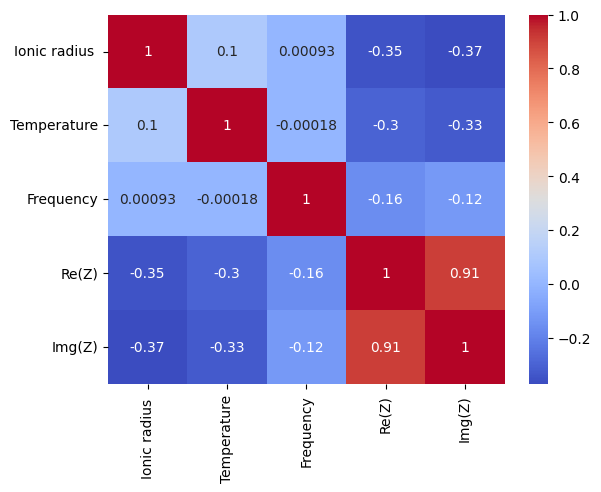

In [17]:
#Pearson Correlation Heat Map
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

<Axes: >

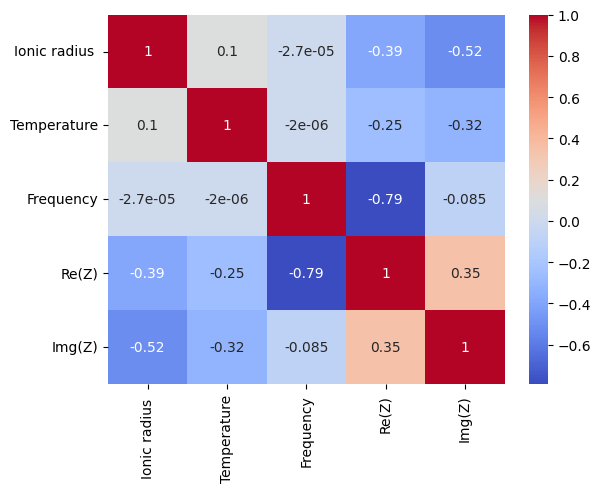

In [18]:
#Spearman Correlation Heat Map
sns.heatmap(df.corr(method='spearman'),annot=True,cmap='coolwarm')

<Axes: >

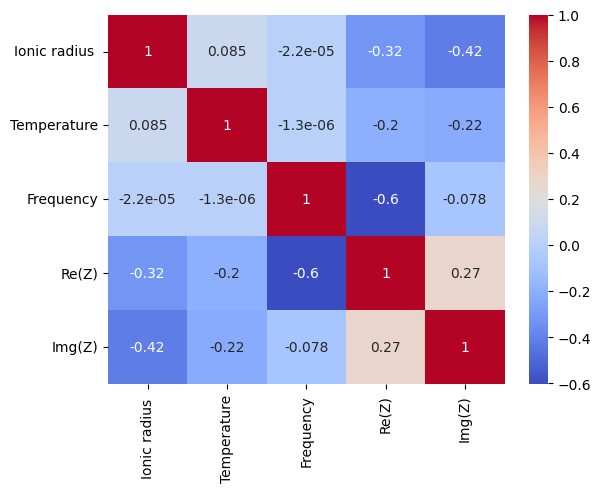

In [19]:
#Kendall Correlation Heat Map
sns.heatmap(df.corr(method='kendall'),annot=True,cmap='coolwarm')

## Outliers Detection

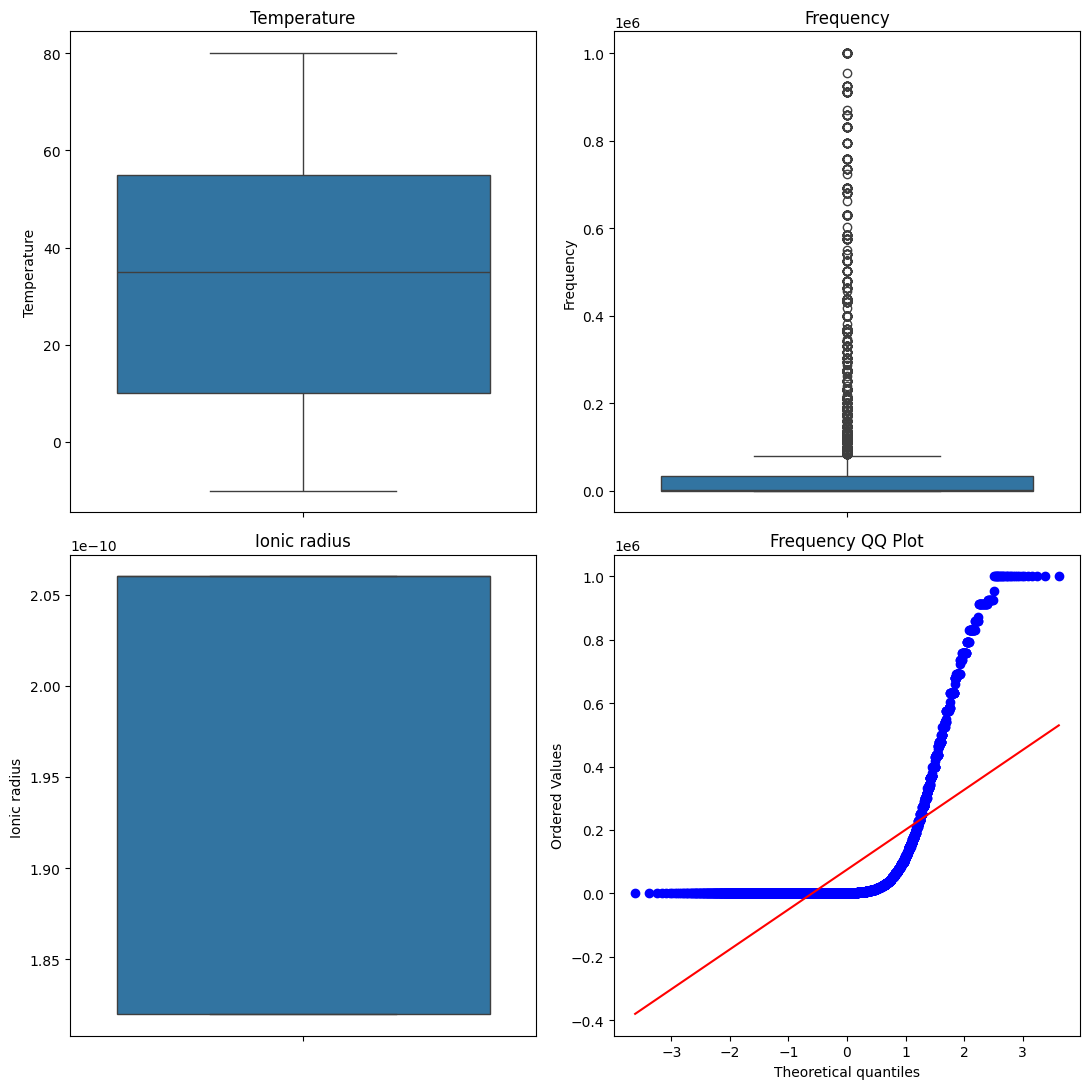

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(11, 11))

sns.boxplot(df['Temperature'], ax=axes[0, 0])
sns.boxplot(df['Frequency'], ax=axes[0, 1])
sns.boxplot(df['Ionic radius '], ax=axes[1, 0])
axes[0, 0].set_title('Temperature')
axes[0, 1].set_title('Frequency')
axes[1, 0].set_title('Ionic radius')
stats.probplot(df['Frequency'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Frequency QQ Plot')

plt.tight_layout()
plt.show()

##Applying Mathematical Transformations

<ipython-input-21-cae1fe1dea93>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Frequency'])


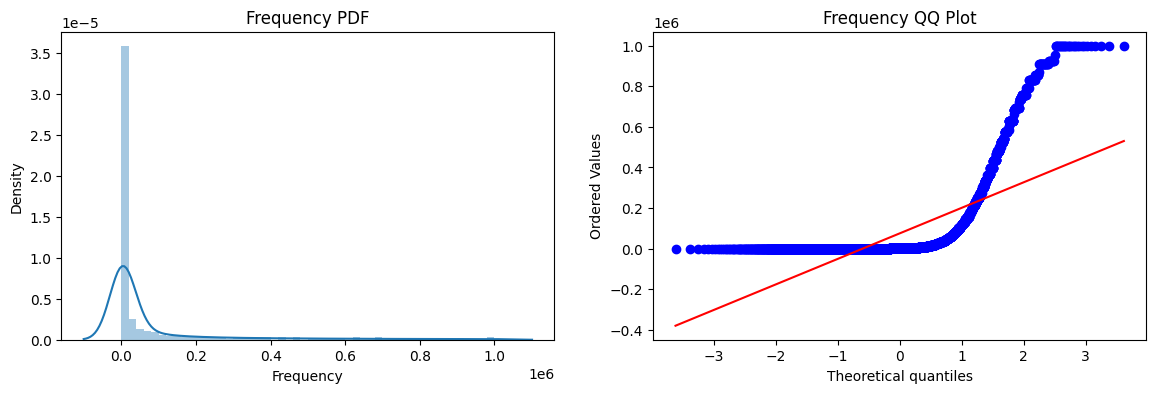

In [21]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.distplot(df['Frequency'])
plt.title('Frequency PDF')

plt.subplot(122)
stats.probplot(df['Frequency'], dist="norm", plot=plt)
plt.title('Frequency QQ Plot')

plt.show()

Function Transform

In [22]:
def apply_transform(transform):
    X = df.iloc[:,0:3]
    y = df.iloc[:,3:5]

    trf = ColumnTransformer([('log',FunctionTransformer(transform),['Frequency'])],remainder='passthrough')

    X_trans = trf.fit_transform(X)
    X_trans=pd.DataFrame(X_trans,columns=['Frequency','Ionic radius ','Temperature'])

    plt.figure(figsize=(14,4))

    plt.subplot(121)
    stats.probplot(X['Frequency'], dist="norm", plot=plt)
    plt.title('Frequency Before Transform')

    plt.subplot(122)
    stats.probplot(X_trans['Frequency'], dist="norm", plot=plt)
    plt.title('Frequency After Transform')


    plt.show()
    X_trans=pd.DataFrame(X_trans,columns=X.columns)
    fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

    sns.distplot(X_trans['Frequency'],ax=ax1)
    ax1.set_title('Transformed Frequency Distplot')
    sns.boxplot(X_trans['Frequency'],ax=ax2)
    ax2.set_title('Transformed Frequency Boxplot')


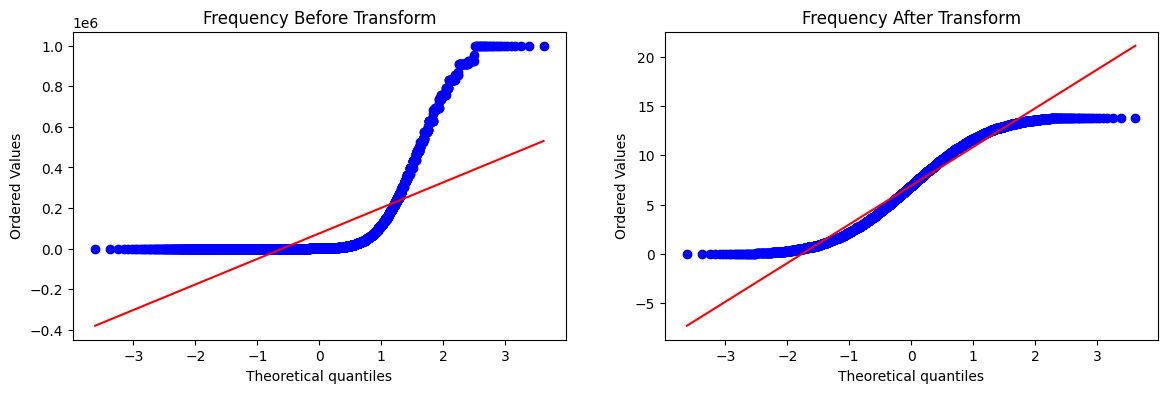

<ipython-input-22-003f036ff020>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_trans['Frequency'],ax=ax1)


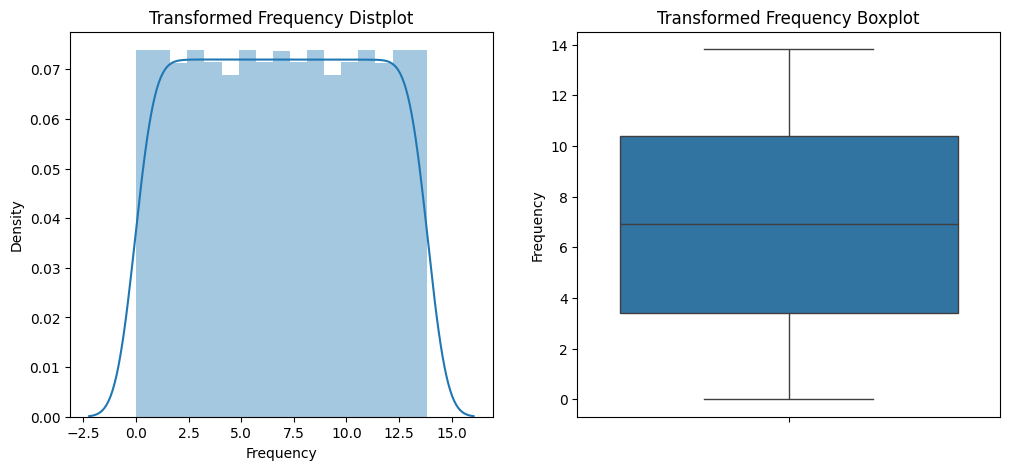

In [23]:
apply_transform(np.log)

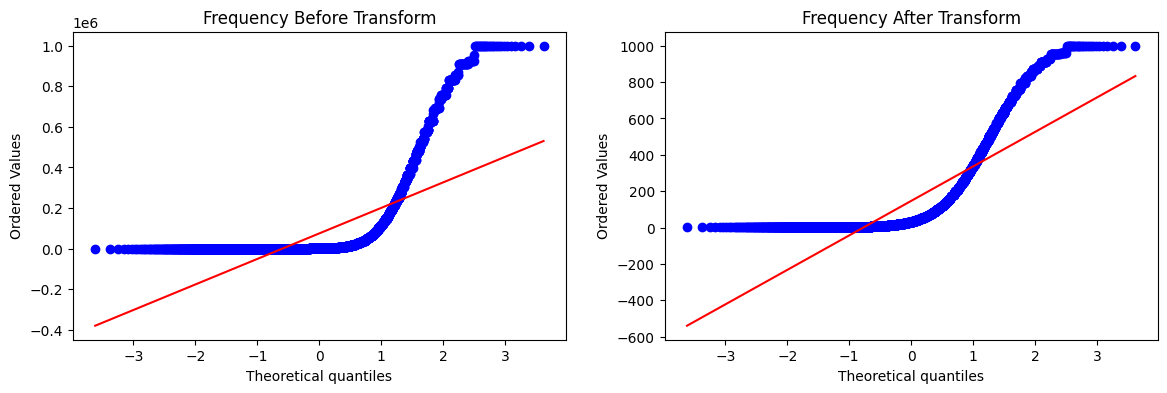

<ipython-input-22-003f036ff020>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_trans['Frequency'],ax=ax1)


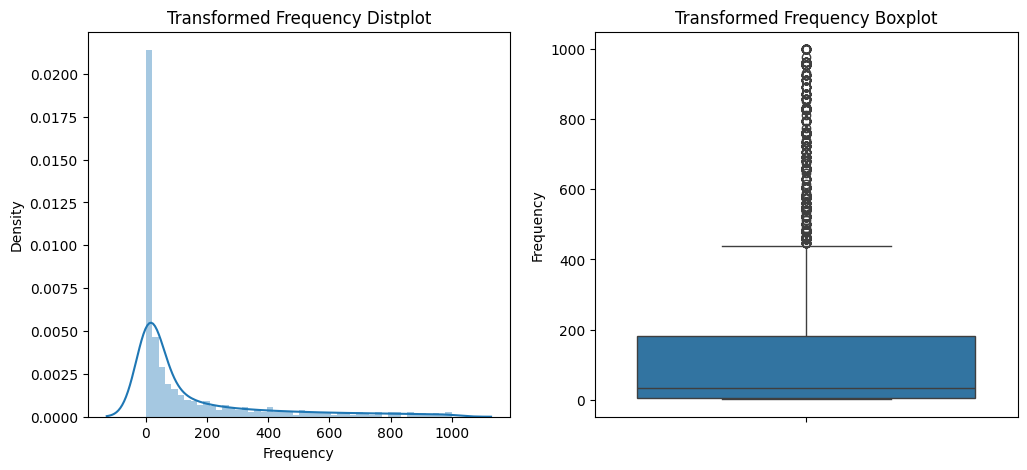

In [24]:
apply_transform(np.sqrt)

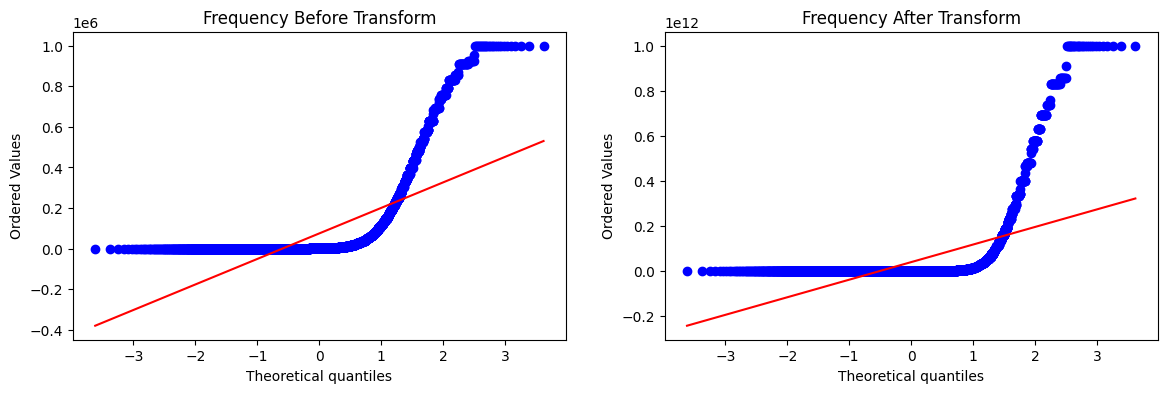

<ipython-input-22-003f036ff020>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_trans['Frequency'],ax=ax1)


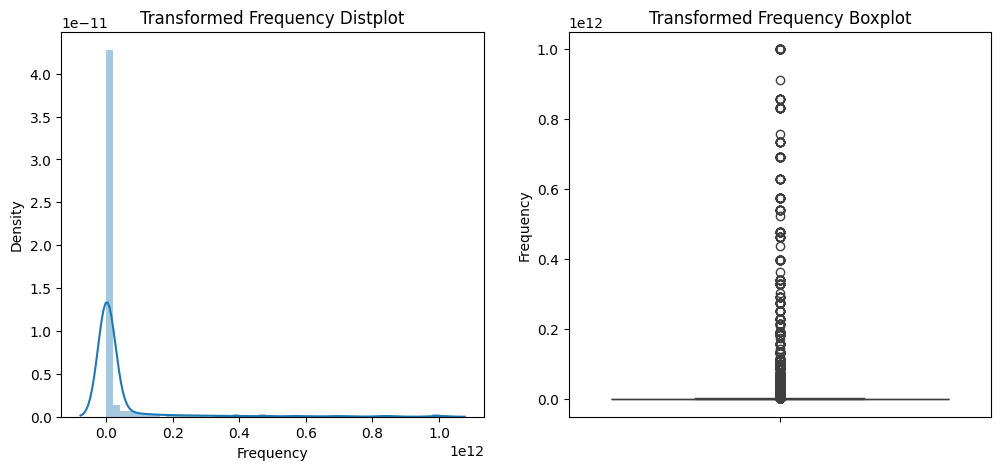

In [25]:
apply_transform(np.square)

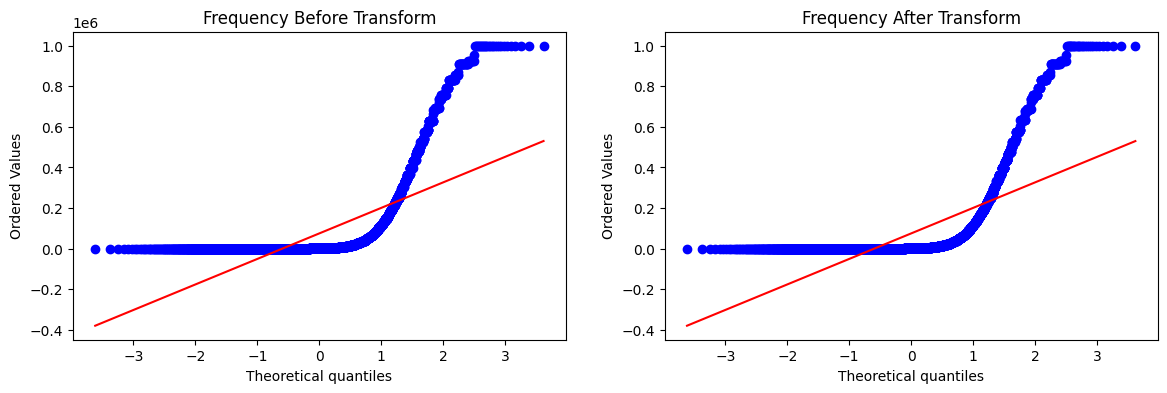

<ipython-input-22-003f036ff020>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_trans['Frequency'],ax=ax1)


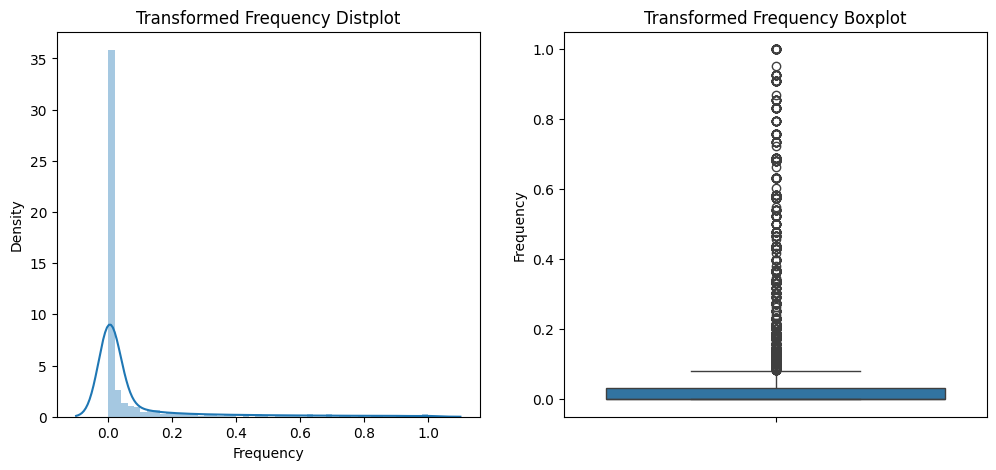

In [26]:
apply_transform(np.reciprocal)

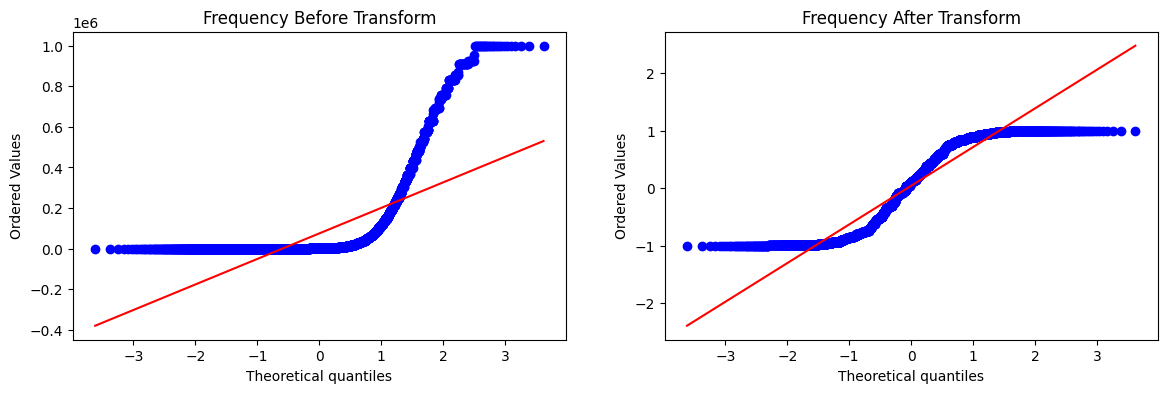

<ipython-input-22-003f036ff020>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_trans['Frequency'],ax=ax1)


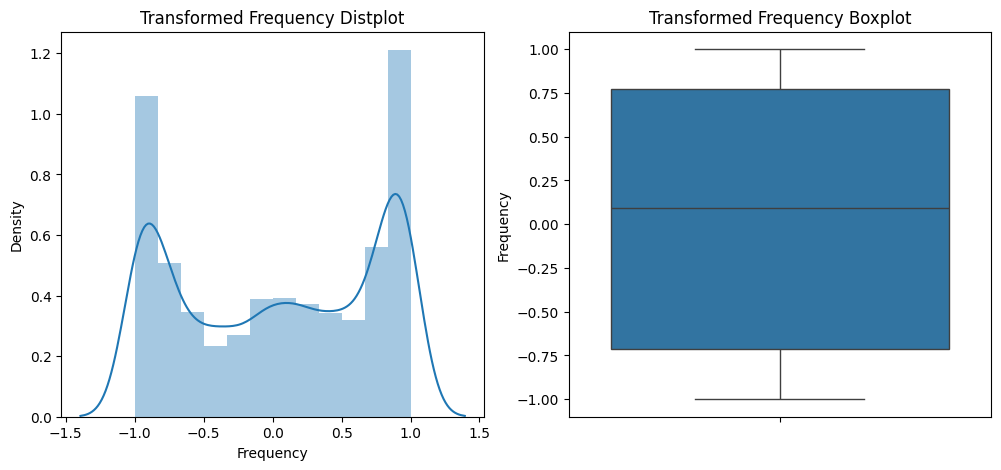

In [27]:
apply_transform(np.sin)

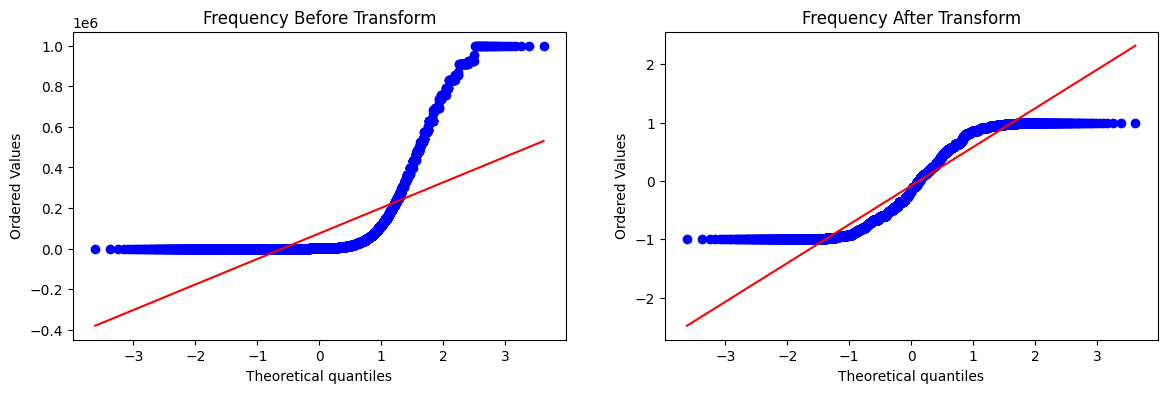

<ipython-input-22-003f036ff020>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_trans['Frequency'],ax=ax1)


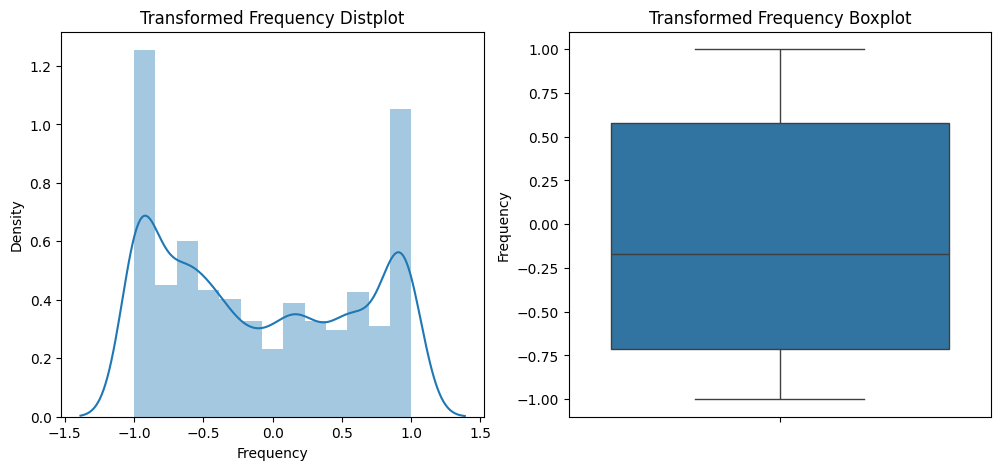

In [28]:
apply_transform(np.cos)

Box-Cox Transform

In [29]:
def apply_boxcox_transform():
    X = df.iloc[:,0:3]
    y = df.iloc[:,3:5]


    trf = ColumnTransformer([('box-cox',PowerTransformer(method='box-cox'),['Frequency'])],remainder='passthrough')

    X_trans = trf.fit_transform(X)
    X_trans=pd.DataFrame(X_trans,columns=['Frequency','Ionic radius ','Temperature'])

    plt.figure(figsize=(14,4))

    plt.subplot(121)
    stats.probplot(X['Frequency'], dist="norm", plot=plt)
    plt.title('Frequency Before Transform')

    plt.subplot(122)
    stats.probplot(X_trans['Frequency'], dist="norm", plot=plt)
    plt.title('Frequency After Transform')

    plt.show()
    X_trans=pd.DataFrame(X_trans,columns=X.columns)
    fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

    sns.distplot(X_trans['Frequency'],ax=ax1)
    sns.boxplot(X_trans['Frequency'],ax=ax2)

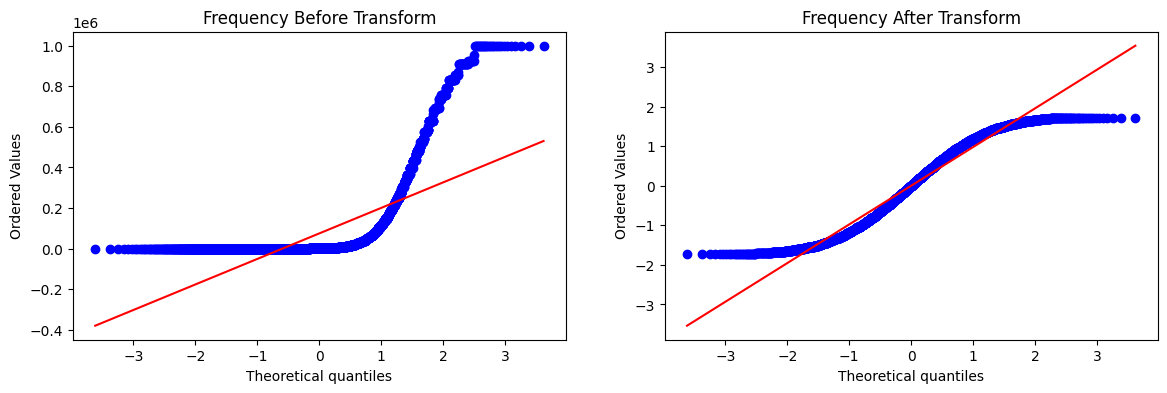

<ipython-input-29-d6ba16934e7d>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_trans['Frequency'],ax=ax1)


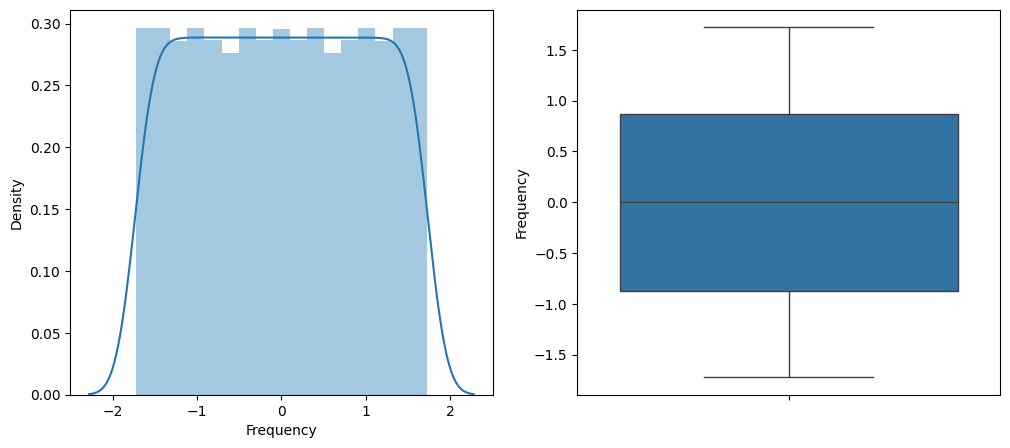

In [30]:
apply_boxcox_transform()

Yeo-Johnson Transform

In [31]:
def apply_yeo_johnson_transform():
    X = df.iloc[:,0:3]
    y = df.iloc[:,3:5]


    trf = ColumnTransformer([('yeo-johnson',PowerTransformer(method='yeo-johnson'),['Frequency'])],remainder='passthrough')

    X_trans = trf.fit_transform(X)
    X_trans=pd.DataFrame(X_trans,columns=['Frequency','Ionic radius ','Temperature'])
    plt.figure(figsize=(14,4))

    plt.subplot(121)
    stats.probplot(X['Frequency'], dist="norm", plot=plt)
    plt.title('Frequency Before Transform')

    plt.subplot(122)
    stats.probplot(X_trans['Frequency'], dist="norm", plot=plt)
    plt.title('Frequency After Transform')

    plt.show()
    X_trans=pd.DataFrame(X_trans,columns=X.columns)
    fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

    sns.distplot(X_trans['Frequency'],ax=ax1)
    sns.boxplot(X_trans['Frequency'],ax=ax2)

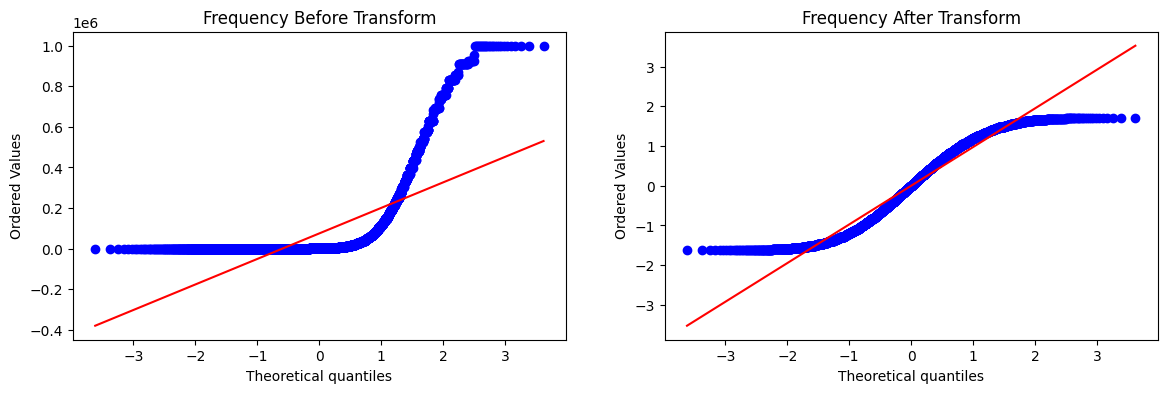

<ipython-input-31-fe4a1b50f73b>:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_trans['Frequency'],ax=ax1)


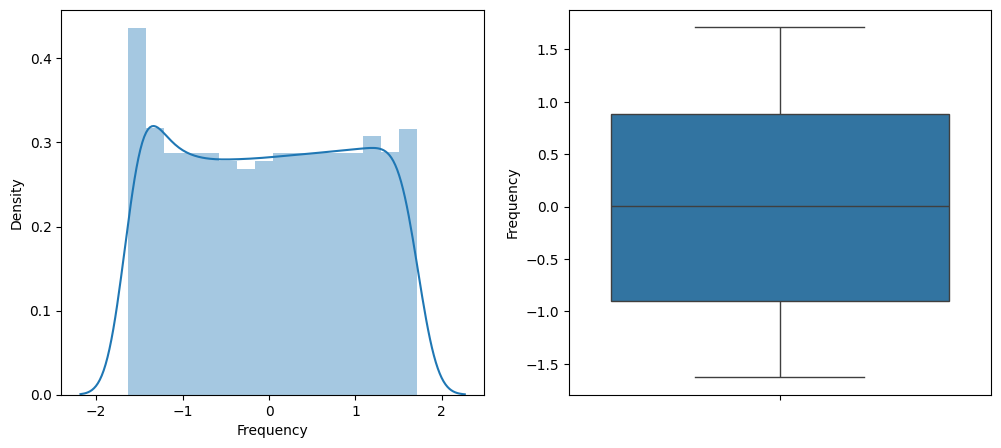

In [32]:
apply_yeo_johnson_transform()

Histogram Distributions for different transformations

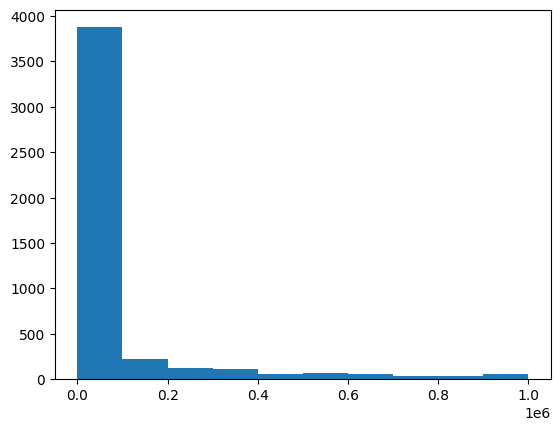

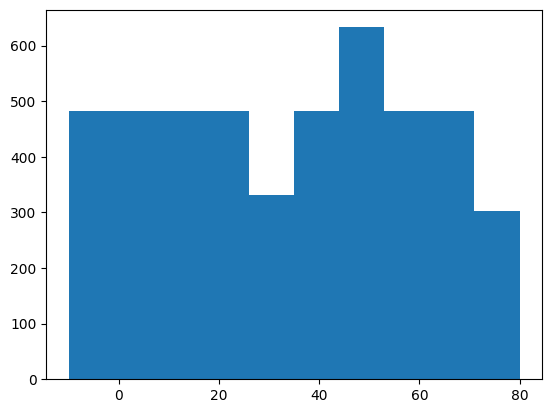

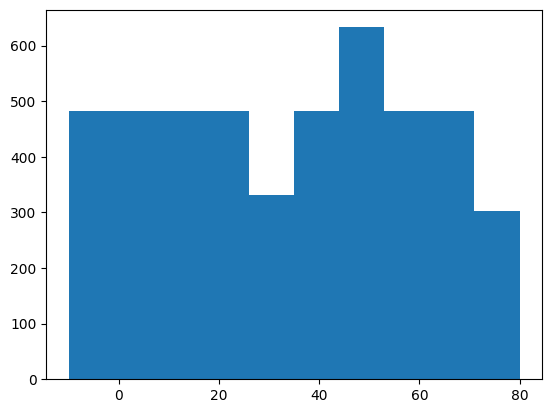

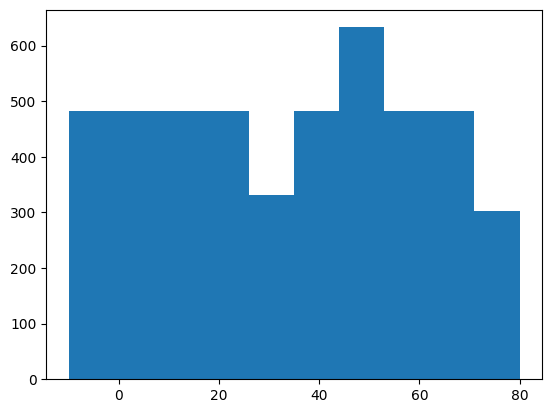

In [33]:
X = df.iloc[:,0:3]
y = df.iloc[:,3:5]
trf1 = ColumnTransformer([('log',FunctionTransformer(np.log),['Frequency'])],remainder='passthrough')
X_trans_log = trf1.fit_transform(X)
X_trans_log=pd.DataFrame(X_trans_log,columns=X.columns)
trf2 = ColumnTransformer([('box-cox',PowerTransformer(method='box-cox'),['Frequency'])],remainder='passthrough')
X_trans_BoxCox = trf2.fit_transform(X)
X_trans_BoxCox=pd.DataFrame(X_trans_BoxCox,columns=X.columns)
trf3= ColumnTransformer([('yeo-johnson',PowerTransformer(method='yeo-johnson'),['Frequency'])],remainder='passthrough')
X_trans_yj = trf3.fit_transform(X)
X_trans_yj=pd.DataFrame(X_trans_yj,columns=X.columns)


plt.hist(X['Frequency'])
plt.show()
plt.hist(X_trans_log['Frequency'])
plt.show()
plt.hist(X_trans_BoxCox['Frequency'])
plt.show()
plt.hist(X_trans_yj['Frequency'])
plt.show()

##Applying Scaling Techniques



In [34]:
X = df.iloc[:,0:3]
y = df.iloc[:,3:5]

Standardisation(Z-Score)

In [35]:
def apply_standard_scalar():
  scaler = StandardScaler()
  scaler.fit(X)
  X_scaled = scaler.transform(X)
  X_scaled=pd.DataFrame(X_scaled,columns=X.columns)
  fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
  ax1.set_title('Before Scaling')
  sns.kdeplot(data=X,ax=ax1)
  ax2.set_title('After Robust Scaling')
  sns.kdeplot(data=X_scaled,ax=ax2)
  plt.show()

  for col in X.columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    # before scaling
    ax1.set_title('Distribution Before Standard Scaling')
    sns.kdeplot(X[col], ax=ax1)

    # after scaling
    ax2.set_title('Distribution After Standard Scaling')
    sns.kdeplot(X_scaled[col], ax=ax2)
    plt.show()
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  sns.heatmap(X_scaled.corr(),annot=True,ax=ax1)
  ax1.set_title('Heatmap')
  sns.heatmap(X_scaled.corr(method=('spearman')),annot=True,ax=ax2 )
  ax2.set_title('Spearman')



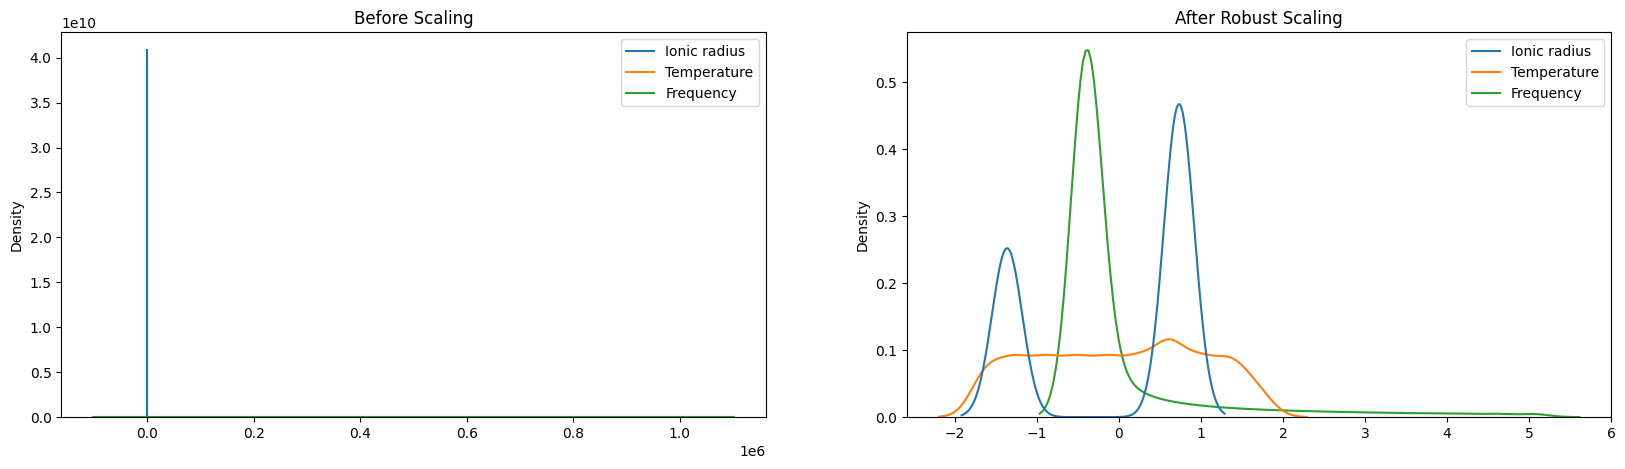

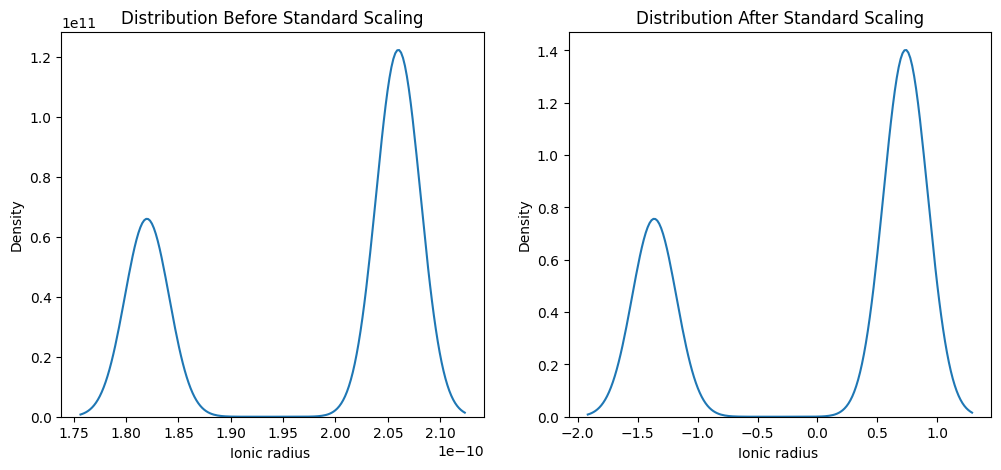

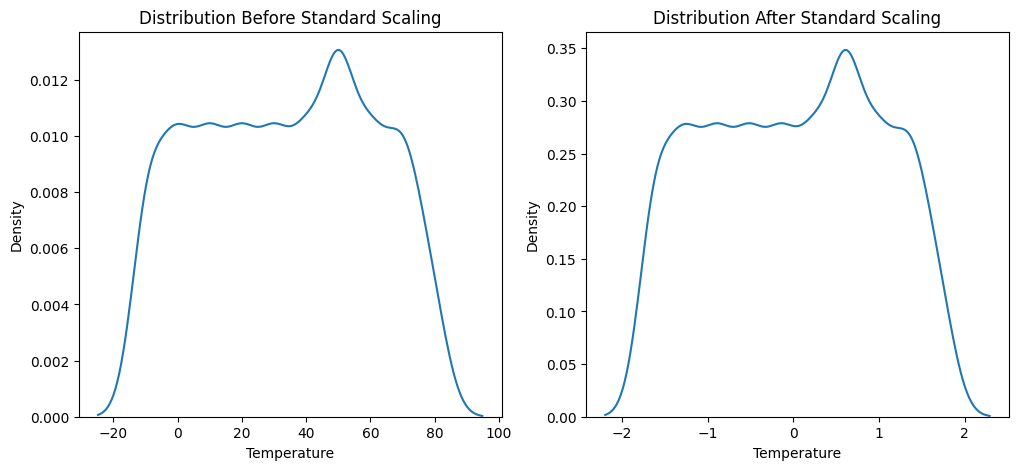

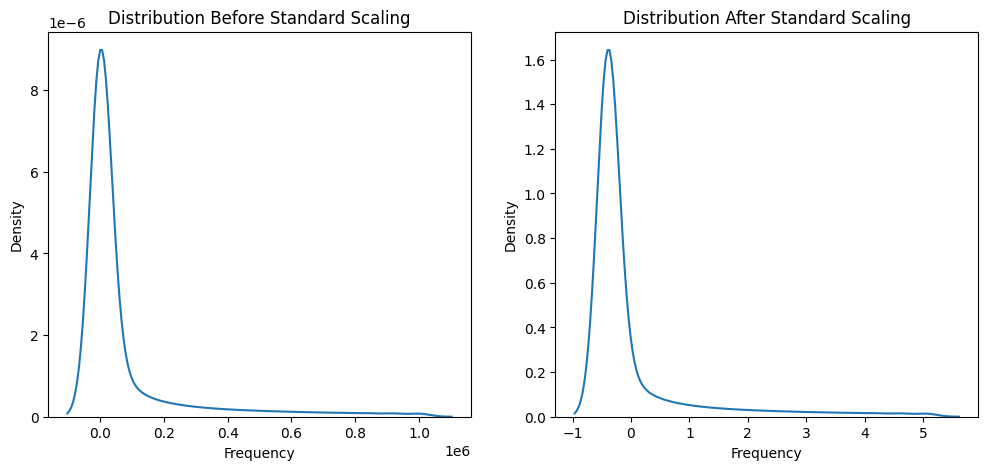

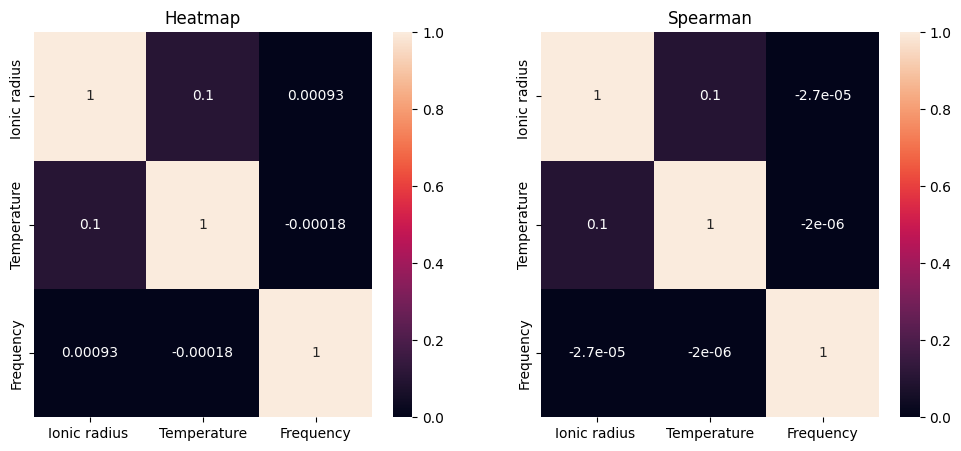

In [36]:
apply_standard_scalar()

Min-Max Scaling

In [37]:
def apply_MINMAX_scalar():
  scaler = MinMaxScaler()
  scaler.fit(X)
  X_scaled = scaler.transform(X)
  X_scaled=pd.DataFrame(X_scaled,columns=X.columns)

  fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
  ax1.set_title('Before Scaling')
  sns.kdeplot(data=X,ax=ax1)
  ax2.set_title('After Robust Scaling')
  sns.kdeplot(data=X_scaled,ax=ax2)
  plt.show()

  for col in X.columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    # before scaling
    ax1.set_title('Distribution Before Standard Scaling')
    sns.kdeplot(X[col], ax=ax1)

    # after scaling
    ax2.set_title('Distribution After Standard Scaling')
    sns.kdeplot(X_scaled[col], ax=ax2)
    plt.show()
  sns.heatmap(X_scaled.corr(),annot=True)

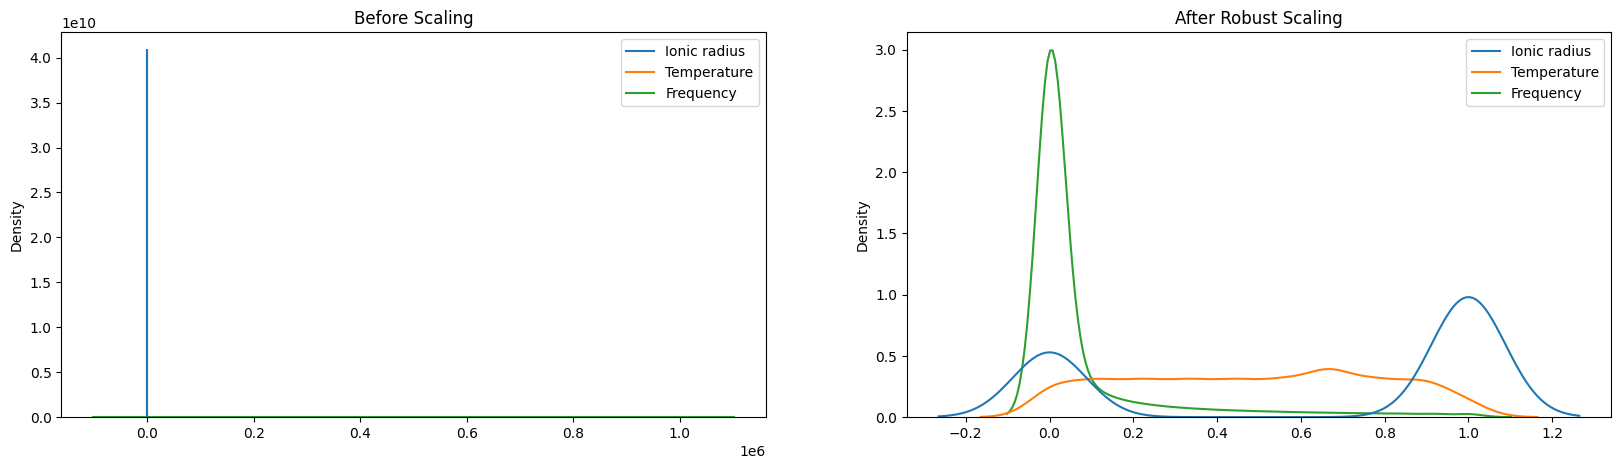

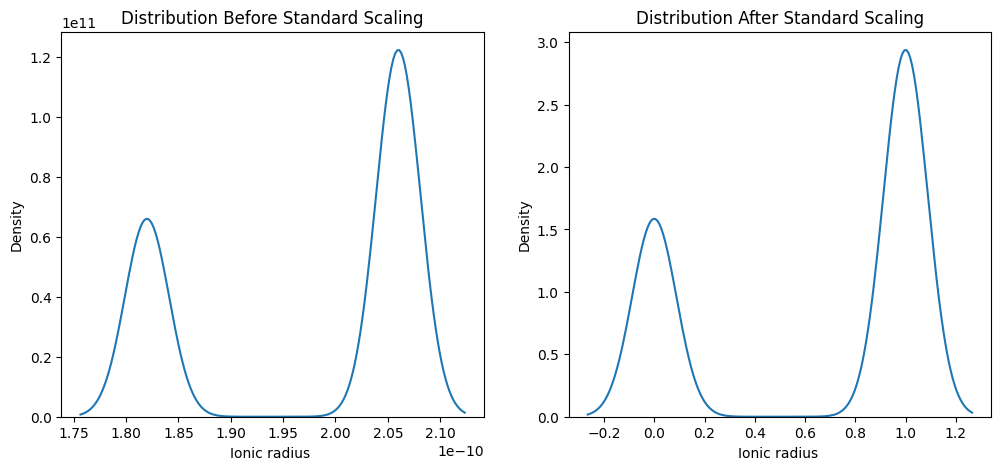

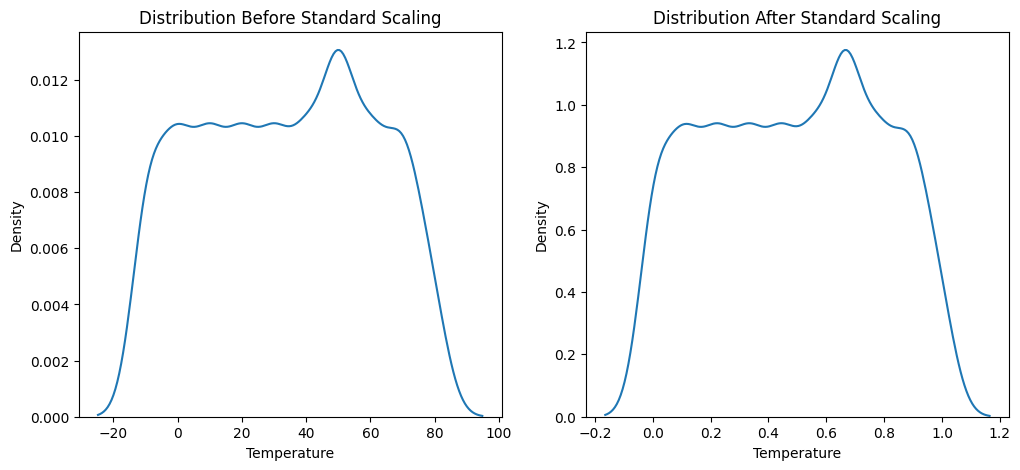

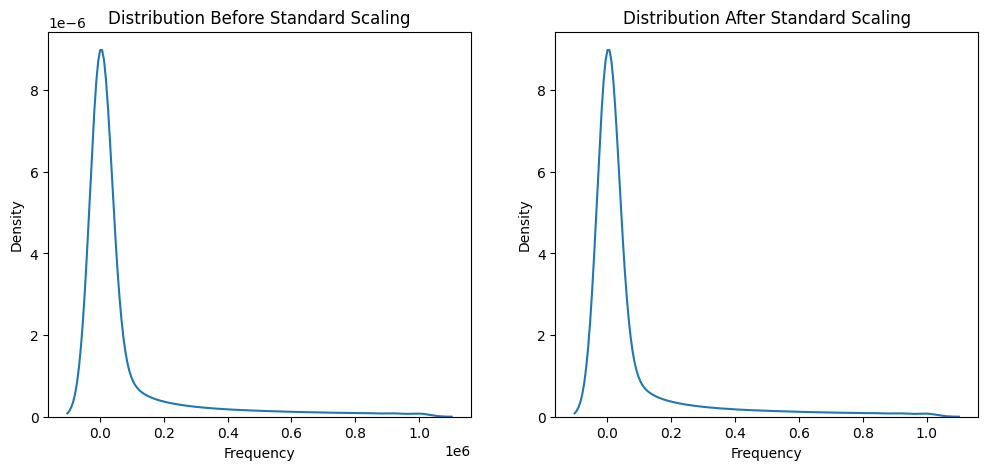

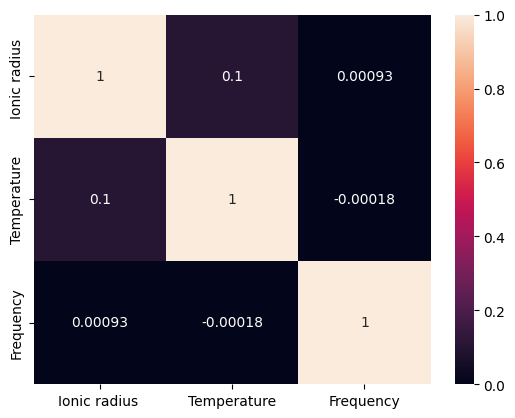

In [38]:
apply_MINMAX_scalar()

Robust Scaling

In [39]:
def apply_robust_scalar():
  scaler = RobustScaler()
  scaler.fit(X)
  X_scaled = scaler.transform(X)
  X_scaled=pd.DataFrame(X_scaled,columns=X.columns)

  fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
  ax1.set_title('Before Scaling')
  sns.kdeplot(data=X,ax=ax1)
  ax2.set_title('After Robust Scaling')
  sns.kdeplot(data=X_scaled,ax=ax2)
  plt.show()

  for col in X.columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    # before scaling
    ax1.set_title('Distribution Before Standard Scaling')
    sns.kdeplot(X[col], ax=ax1)

    # after scaling
    ax2.set_title('Distribution After Standard Scaling')
    sns.kdeplot(X_scaled[col], ax=ax2)
    plt.show()
  sns.heatmap(X_scaled.corr(),annot=True)

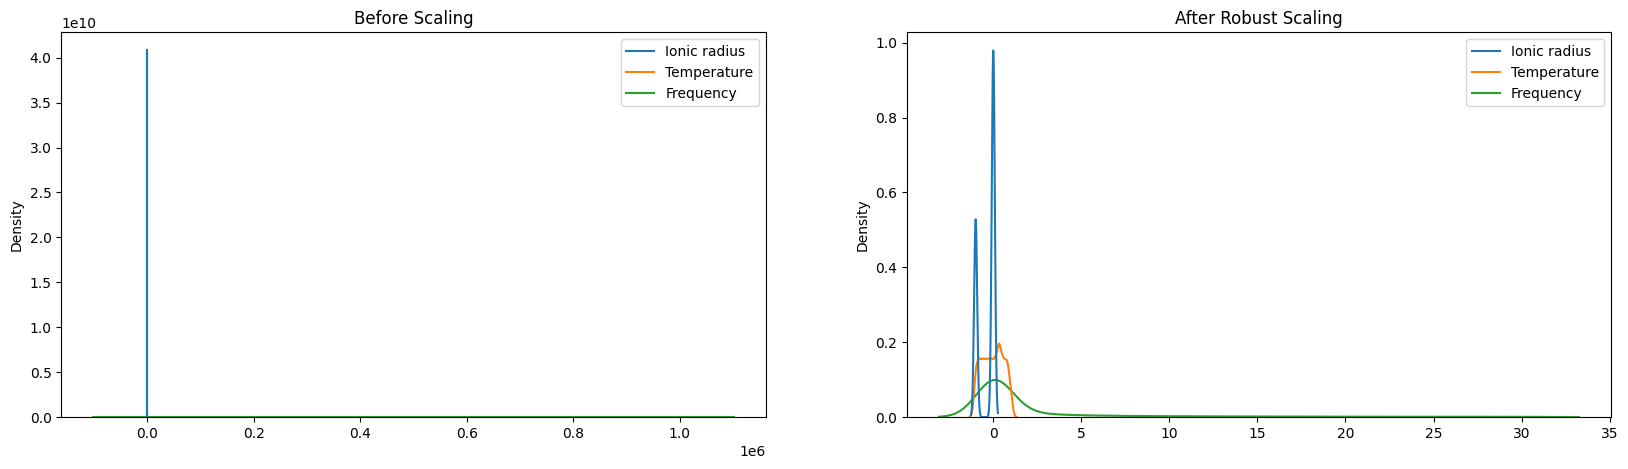

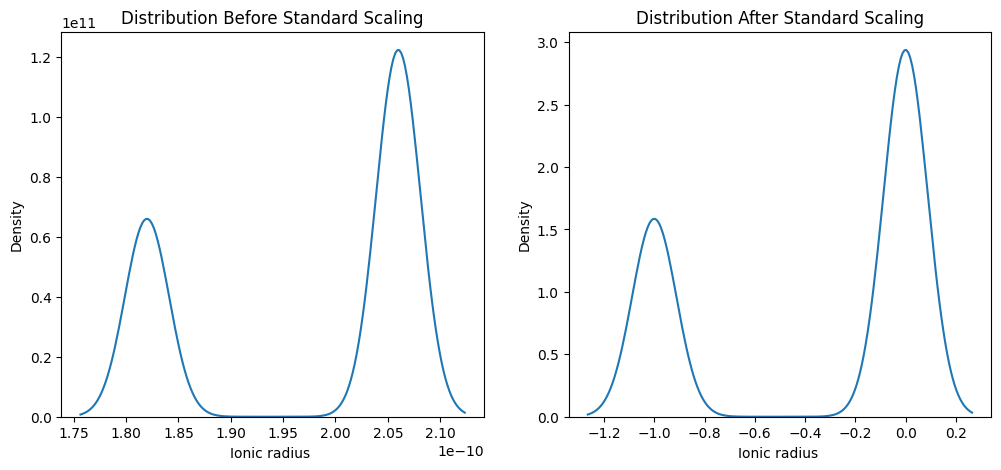

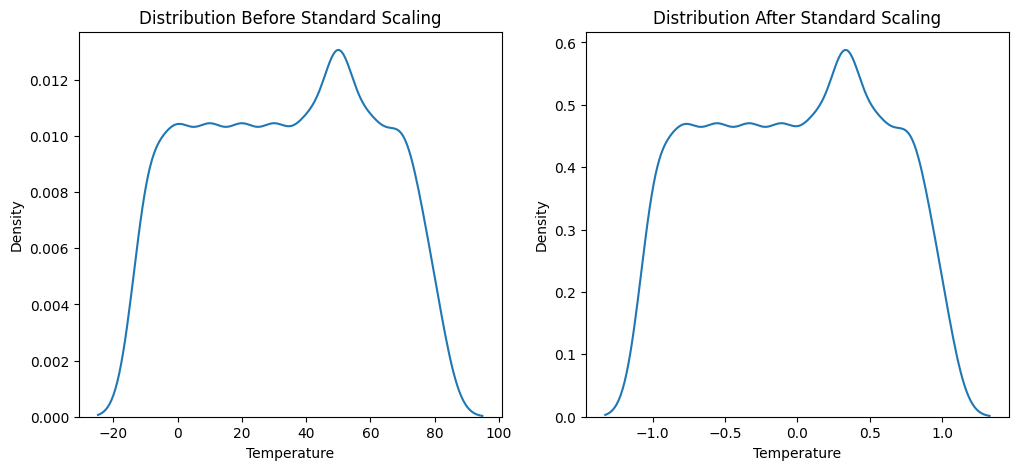

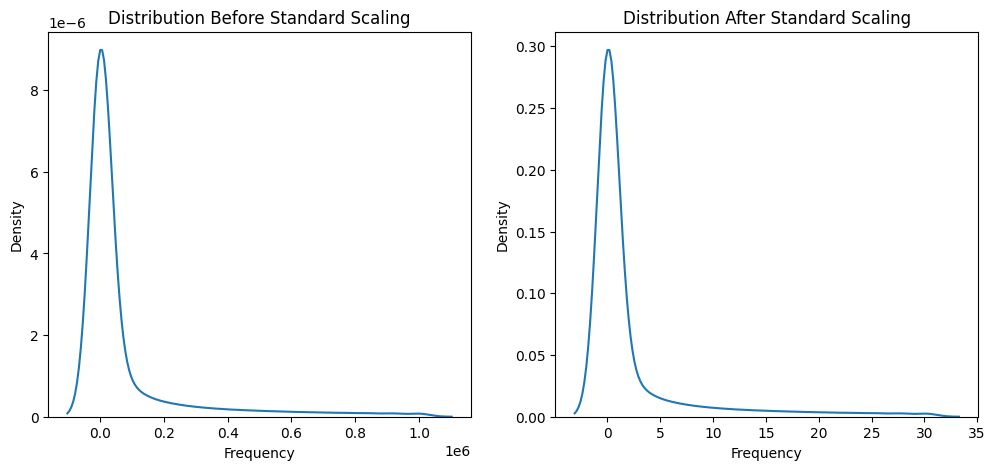

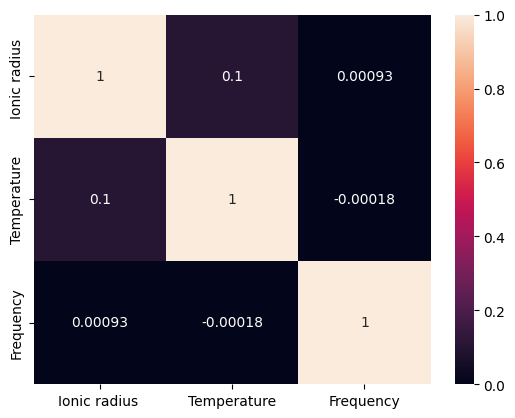

In [40]:
apply_robust_scalar()

## Applying transformation and scaling

Log transform and standard scaling

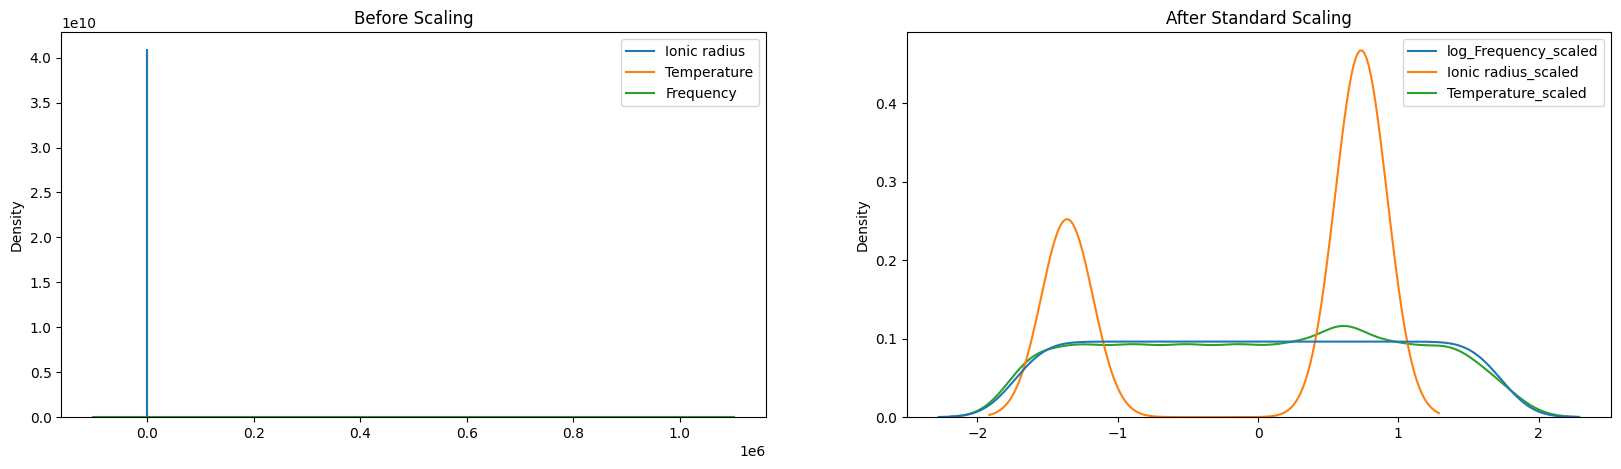

<Axes: title={'center': 'After Standard Scaling'}, ylabel='log_Frequency_scaled'>

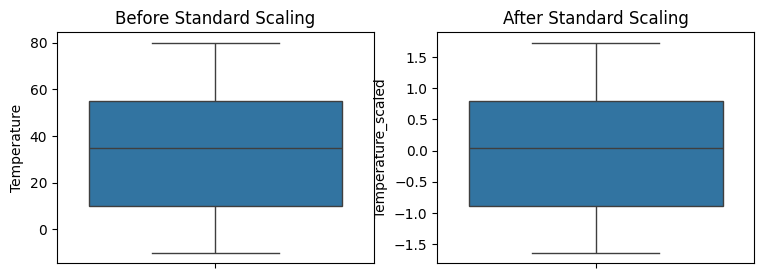

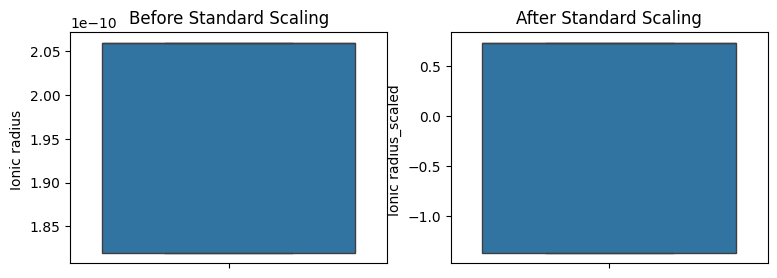

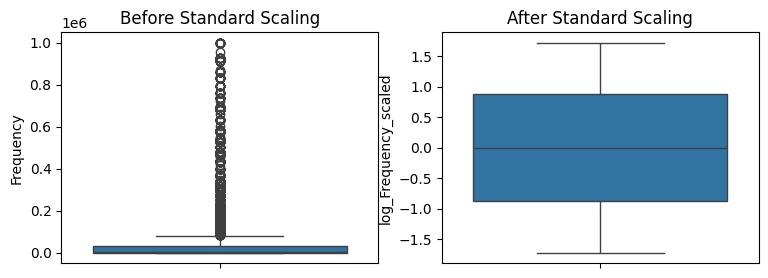

In [41]:
X = df.iloc[:,0:3]
y = df.iloc[:,3:5]

trf = ColumnTransformer([('log',FunctionTransformer(np.log),['Frequency'])],remainder='passthrough')
X_trans_log = trf.fit_transform(X)
X_trans_log=pd.DataFrame(X_trans_log,columns=['log_Frequency','Ionic radius ','Temperature'])
standard_scaler = StandardScaler()
standard_scaler.fit(X_trans_log)
X_sscaled_log = standard_scaler.transform(X_trans_log)
X_sscaled_log=pd.DataFrame(X_sscaled_log,columns=['log_Frequency_scaled','Ionic radius_scaled ','Temperature_scaled'])
X_sscaled_log.head()
fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(data=X,ax=ax1)
ax2.set_title('After Standard Scaling')
sns.kdeplot(data=X_sscaled_log,ax=ax2)
plt.show()

fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(9, 3))
ax1.set_title('Before Standard Scaling')
sns.boxplot(X['Temperature'],ax=ax1)
ax2.set_title('After Standard Scaling')
sns.boxplot(X_sscaled_log['Temperature_scaled'],ax=ax2)
fig, (ax3,ax4) = plt.subplots(ncols = 2, figsize =(9, 3))
ax3.set_title('Before Standard Scaling')
sns.boxplot(X['Ionic radius '],ax=ax3)
ax4.set_title('After Standard Scaling')
sns.boxplot(X_sscaled_log['Ionic radius_scaled '],ax=ax4)
fig, (ax5,ax6) = plt.subplots(ncols = 2, figsize =(9, 3))
ax5.set_title('Before Standard Scaling')
sns.boxplot(X['Frequency'],ax=ax5)
ax6.set_title('After Standard Scaling')
sns.boxplot(X_sscaled_log['log_Frequency_scaled'],ax=ax6)

Log transform and MinMax scaling

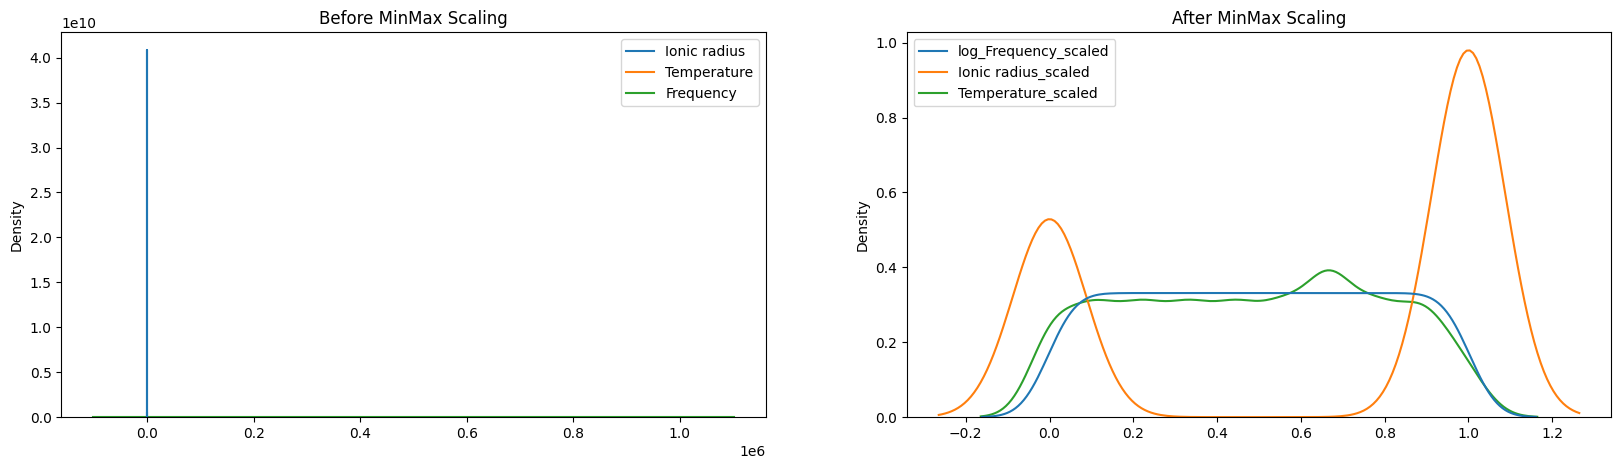

<Axes: title={'center': 'After MinMax Scaling'}, ylabel='log_Frequency_scaled'>

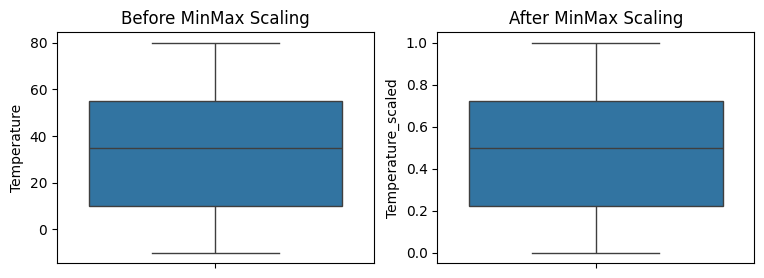

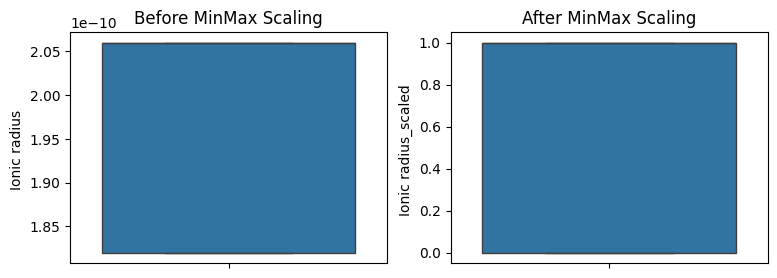

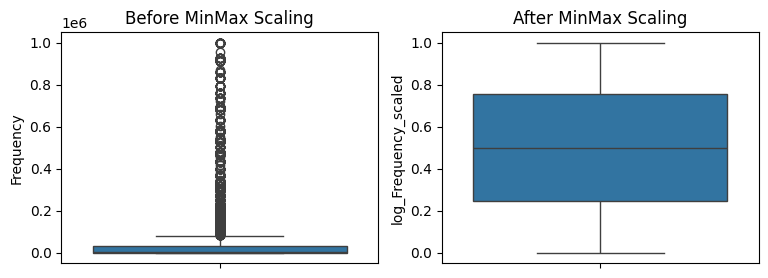

In [42]:
X = df.iloc[:,0:3]
y = df.iloc[:,3:5]
trf = ColumnTransformer([('log',FunctionTransformer(np.log),['Frequency'])],remainder='passthrough')
X_trans_log1 = trf.fit_transform(X)
X_trans_log1=pd.DataFrame(X_trans_log1,columns=['log_Frequency','Ionic radius ','Temperature'])
MinMax_scaler = MinMaxScaler()
MinMax_scaler.fit(X_trans_log1)
X_MinMaxscaled_log = MinMax_scaler.transform(X_trans_log1)
X_MinMaxscaled_log=pd.DataFrame(X_MinMaxscaled_log,columns=['log_Frequency_scaled','Ionic radius_scaled ','Temperature_scaled'])

fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
ax1.set_title('Before MinMax Scaling')
sns.kdeplot(data=X,ax=ax1)
ax2.set_title('After MinMax Scaling')
sns.kdeplot(data=X_MinMaxscaled_log,ax=ax2)
plt.show()

fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(9, 3))
ax1.set_title('Before MinMax Scaling')
sns.boxplot(X['Temperature'],ax=ax1)
ax2.set_title('After MinMax Scaling')
sns.boxplot(X_MinMaxscaled_log['Temperature_scaled'],ax=ax2)
fig, (ax3,ax4) = plt.subplots(ncols = 2, figsize =(9, 3))
ax3.set_title('Before MinMax Scaling')
sns.boxplot(X['Ionic radius '],ax=ax3)
ax4.set_title('After MinMax Scaling')
sns.boxplot(X_MinMaxscaled_log['Ionic radius_scaled '],ax=ax4)
fig, (ax5,ax6) = plt.subplots(ncols = 2, figsize =(9, 3))
ax5.set_title('Before MinMax Scaling')
sns.boxplot(X['Frequency'],ax=ax5)
ax6.set_title('After MinMax Scaling')
sns.boxplot(X_MinMaxscaled_log['log_Frequency_scaled'],ax=ax6)


Log transform and Robust Scaling

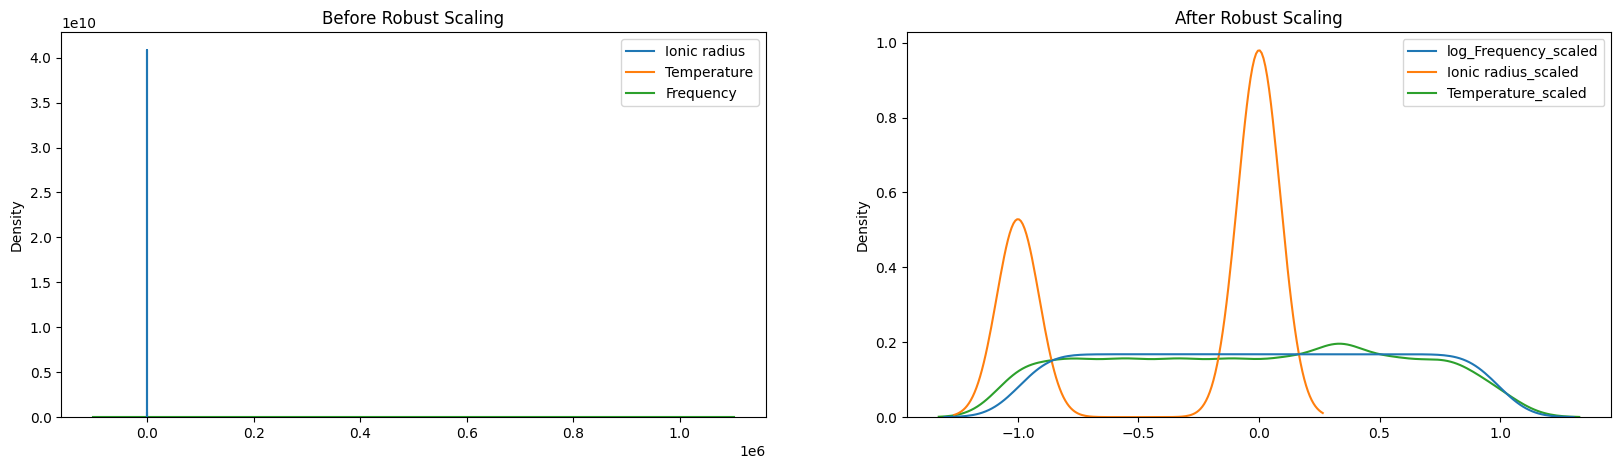

<Axes: title={'center': 'After Robust Scaling'}, ylabel='log_Frequency_scaled'>

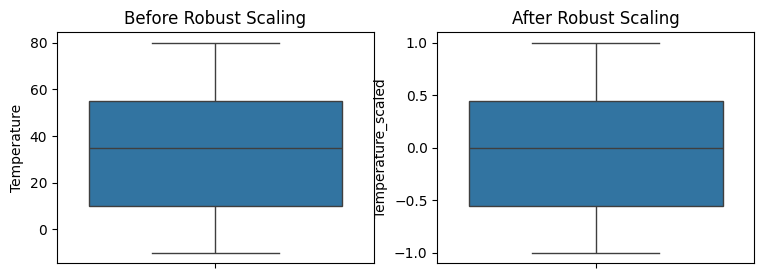

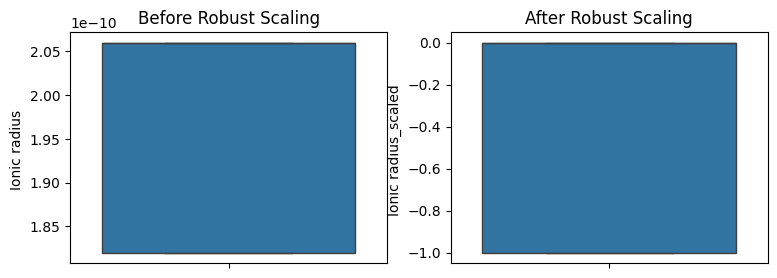

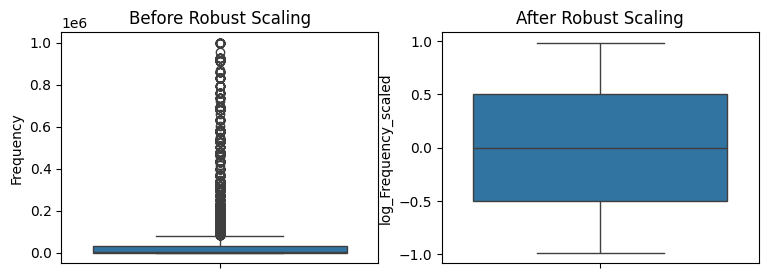

In [43]:
X = df.iloc[:,0:3]
y = df.iloc[:,3:5]
trf = ColumnTransformer([('log',FunctionTransformer(np.log),['Frequency'])],remainder='passthrough')
X_trans_log2 = trf.fit_transform(X)
X_trans_log2=pd.DataFrame(X_trans_log2,columns=['log_Frequency','Ionic radius ','Temperature'])
Robust_scaler = RobustScaler()
Robust_scaler.fit(X_trans_log2)
X_Robustscaled_log = Robust_scaler.transform(X_trans_log2)
X_Robustscaled_log=pd.DataFrame(X_Robustscaled_log,columns=['log_Frequency_scaled','Ionic radius_scaled ','Temperature_scaled'])

fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(20, 5))
ax1.set_title('Before Robust Scaling')
sns.kdeplot(data=X,ax=ax1)
ax2.set_title('After Robust Scaling')
sns.kdeplot(data=X_Robustscaled_log,ax=ax2)
plt.show()

fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(9, 3))
ax1.set_title('Before Robust Scaling')
sns.boxplot(X['Temperature'],ax=ax1)
ax2.set_title('After Robust Scaling')
sns.boxplot(X_Robustscaled_log['Temperature_scaled'],ax=ax2)
fig, (ax3,ax4) = plt.subplots(ncols = 2, figsize =(9, 3))
ax3.set_title('Before Robust Scaling')
sns.boxplot(X['Ionic radius '],ax=ax3)
ax4.set_title('After Robust Scaling')
sns.boxplot(X_Robustscaled_log['Ionic radius_scaled '],ax=ax4)
fig, (ax5,ax6) = plt.subplots(ncols = 2, figsize =(9, 3))
ax5.set_title('Before Robust Scaling')
sns.boxplot(X['Frequency'],ax=ax5)
ax6.set_title('After Robust Scaling')
sns.boxplot(X_Robustscaled_log['log_Frequency_scaled'],ax=ax6)

#heatmaps
# fig, (ax1,ax2) = plt.subplots(ncols = 2, figsize =(12, 5))
# sns.heatmap(X_Robustscaled_log.corr(),annot=True)

# Regression

## Loading Data

In [44]:
df= pd.read_csv("INPUT-DATA.csv")
df.head()

Ionic radius   Temperature  Frequency   Re(Z)   Img(Z)
0   1.820000e-10          -10  1000000.0  3160.0   9670.0
1   1.820000e-10          -10   926000.0  3480.0  10200.0
2   1.820000e-10          -10   858000.0  3840.0  10300.0
3   1.820000e-10          -10   794000.0  4210.0  10600.0
4   1.820000e-10          -10   736000.0  4530.0  10900.0

In [45]:
print(df['Temperature'].unique())
print(df.shape)

[-10   0  10  20  30  40  50  60  70  -5   5  15  25  35  45  55  65  75
  80]
(4648, 5)


In [46]:
new_df=df.copy()
drop_temp=[20,60,-5,25,55]
for i in drop_temp:
  new_df=new_df[new_df['Temperature']!=i]
print(new_df['Temperature'].unique())
print(new_df.shape)
new_df.head()

[-10   0  10  30  40  50  70   5  15  35  45  65  75  80]
(3531, 5)


Ionic radius   Temperature  Frequency   Re(Z)   Img(Z)
0   1.820000e-10          -10  1000000.0  3160.0   9670.0
1   1.820000e-10          -10   926000.0  3480.0  10200.0
2   1.820000e-10          -10   858000.0  3840.0  10300.0
3   1.820000e-10          -10   794000.0  4210.0  10600.0
4   1.820000e-10          -10   736000.0  4530.0  10900.0

## Applying transformation and scaling

In [47]:
#applying log transform on frequency
trf = ColumnTransformer([('log',FunctionTransformer(np.log),['Frequency'])],remainder='passthrough')
trans_log = trf.fit_transform(new_df)
trans_log=pd.DataFrame(trans_log,columns=['log_Frequency','Ionic radius ','Temperature','Re(Z)','Img(Z)'])
trans_log

log_Frequency  Ionic radius   Temperature    Re(Z)   Img(Z)
0         13.815511   1.820000e-10        -10.0   3160.0   9670.0
1         13.738630   1.820000e-10        -10.0   3480.0  10200.0
2         13.662359   1.820000e-10        -10.0   3840.0  10300.0
3         13.584839   1.820000e-10        -10.0   4210.0  10600.0
4         13.508985   1.820000e-10        -10.0   4530.0  10900.0
...             ...            ...          ...      ...      ...
3526       0.371564   2.060000e-10         80.0  68600.0  10900.0
3527       0.277632   2.060000e-10         80.0  69400.0  11300.0
3528       0.182322   2.060000e-10         80.0  70300.0  11700.0
3529       0.095310   2.060000e-10         80.0  71200.0  12100.0
3530       0.000000   2.060000e-10         80.0  72100.0  12500.0

[3531 rows x 5 columns]

In [48]:
#applying MinMax scaler on log transformed data
MinMax_scaler = MinMaxScaler()
MinMax_scaler.fit(trans_log)
MinMaxscaled_log=MinMax_scaler.transform(trans_log)
MinMaxscaled_log=pd.DataFrame(MinMaxscaled_log,columns=['log_Frequency','Ionic radius ','Temperature','Re(Z)','Img(Z)'])
MinMaxscaled_log

log_Frequency  Ionic radius   Temperature     Re(Z)    Img(Z)
0          1.000000            0.0          0.0  0.000538  0.046129
1          0.994435            0.0          0.0  0.000633  0.046482
2          0.988915            0.0          0.0  0.000739  0.046549
3          0.983303            0.0          0.0  0.000847  0.046749
4          0.977813            0.0          0.0  0.000942  0.046949
...             ...            ...          ...       ...       ...
3526       0.026895            1.0          1.0  0.019793  0.046949
3527       0.020096            1.0          1.0  0.020028  0.047216
3528       0.013197            1.0          1.0  0.020293  0.047482
3529       0.006899            1.0          1.0  0.020558  0.047749
3530       0.000000            1.0          1.0  0.020823  0.048016

[3531 rows x 5 columns]

In [49]:
MinMaxscaled_log['Temperature'].min()

0.0

## Train validation test split of shuffled data

In [50]:
shuffled_data = MinMaxscaled_log.copy()
shuffled_data

log_Frequency  Ionic radius   Temperature     Re(Z)    Img(Z)
0          1.000000            0.0          0.0  0.000538  0.046129
1          0.994435            0.0          0.0  0.000633  0.046482
2          0.988915            0.0          0.0  0.000739  0.046549
3          0.983303            0.0          0.0  0.000847  0.046749
4          0.977813            0.0          0.0  0.000942  0.046949
...             ...            ...          ...       ...       ...
3526       0.026895            1.0          1.0  0.019793  0.046949
3527       0.020096            1.0          1.0  0.020028  0.047216
3528       0.013197            1.0          1.0  0.020293  0.047482
3529       0.006899            1.0          1.0  0.020558  0.047749
3530       0.000000            1.0          1.0  0.020823  0.048016

[3531 rows x 5 columns]

In [51]:
shuffled_data.isnull().sum()

log_Frequency    0
Ionic radius     0
Temperature      0
Re(Z)            0
Img(Z)           0
dtype: int64

In [52]:
shuffled_data.duplicated().sum()

0

In [53]:
X = shuffled_data.iloc[:,0:3]
y = shuffled_data.iloc[:,3:5]

In [54]:
X_train_df, x_temps,Y_train_df,y_temps= train_test_split(X,y, test_size=0.3, random_state=42)
X_val_df, X_test_df,Y_val_df,Y_test_df= train_test_split(x_temps,y_temps, test_size=0.5, random_state=42)

In [55]:
Y_test_df

Re(Z)    Img(Z)
2185  0.000944  0.041707
642   0.070519  0.057019
3135  0.013761  0.055819
3215  0.019881  0.045408
945   0.012967  0.060020
...        ...       ...
67    0.018940  0.114371
596   0.018175  0.076359
3188  0.018028  0.040560
2661  0.000950  0.042281
1192  0.036682  0.043621

[530 rows x 2 columns]

In [56]:
print(f"X Train shape: {X_train_df.shape}")
print(f"X Validation shape: {X_val_df.shape}")
print(f"X Test shape: {X_test_df.shape}")

X Train shape: (2471, 3)
X Validation shape: (530, 3)
X Test shape: (530, 3)


In [57]:
print(f"Y Train shape: {Y_train_df.shape}")
print(f"Y Validation shape: {Y_val_df.shape}")
print(f"Y Test shape: {Y_test_df.shape}")

Y Train shape: (2471, 2)
Y Validation shape: (530, 2)
Y Test shape: (530, 2)


## Fitting training data into 5 different regression algorithms

### Function definitions

In [58]:
#prediction function
def predict_(model,X_data,Y_data):
  pred_ = model.predict(X_data)
  print("MAE",mean_absolute_error(Y_data,pred_))
  print("MSE",mean_squared_error(Y_data,pred_))
  print("RMSE",sqrt(mean_squared_error(Y_data,pred_)))
  print("R2 score",r2_score(Y_data,pred_))
  print("MAPE score",mean_absolute_percentage_error(Y_data,pred_))
  return pred_

In [59]:
#plotting function on validation data
X_val_df=pd.DataFrame(X_val_df,columns=['log_Frequency','Ionic radius ','Temperature'])

def plot_pred(pred_):

  x_columns=['Temperature','log_Frequency','Ionic radius ']
  for i in x_columns:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(X_val_df[i], Y_val_df['Re(Z)'], color='blue', label='Actual Re(Z)')
    plt.scatter(X_val_df[i], pred_['Re(Z)'], color='red', label='Predicted Y_1')
    plt.xlabel(i)
    plt.ylabel('Re(Z)')
    plt.title('Actual vs Predicted Re(Z)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_val_df[i], Y_val_df['Img(Z)'], color='blue', label='Actual Img(Z)')
    plt.scatter(X_val_df[i], pred_['Img(Z)'], color='yellow', label='Predicted Y_2')
    plt.xlabel(i)
    plt.ylabel('Img(Z)')
    plt.title('Actual vs Predicted Img(Z)')
    plt.legend()

    plt.show()


In [60]:
#plotting function on testing data
X_test_df=pd.DataFrame(X_test_df,columns=['log_Frequency','Ionic radius ','Temperature'])

def plot_pred_test(pred_):

  x_columns=['Temperature','log_Frequency','Ionic radius ']
  for i in x_columns:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(X_test_df[i], Y_test_df['Re(Z)'], color='blue', label='Actual Re(Z)')
    plt.scatter(X_test_df[i], pred_['Re(Z)'], color='red', label='Predicted Y_1')
    plt.xlabel(i)
    plt.ylabel('Re(Z)')
    plt.title('Actual vs Predicted Re(Z)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_test_df[i], Y_test_df['Img(Z)'], color='blue', label='Actual Img(Z)')
    plt.scatter(X_test_df[i], pred_['Img(Z)'], color='yellow', label='Predicted Y_2')
    plt.xlabel(i)
    plt.ylabel('Img(Z)')
    plt.title('Actual vs Predicted Img(Z)')
    plt.legend()

    plt.show()

### Training Algorithms

#### 1. Simple regression

In [61]:
lr = LinearRegression()
lr.fit(X_train_df,Y_train_df)
#prediction on train data
print("Prediction on train data")
y_train_pred_lr=predict_(lr,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
y_val_pred_lr = predict_(lr,X_val_df,Y_val_df)
print("\n")
#prediction on test data
print("Prediction on test data")
y_test_pred_lr = predict_(lr,X_test_df,Y_test_df)

Prediction on train data
MAE 0.05664746113898515
MSE 0.00852764969973748
RMSE 0.09234527437685959
R2 score 0.3321111805842616
MAPE score 109769543449.27327


Prediction on val data
MAE 0.05776879665814651
MSE 0.009464657682249874
RMSE 0.09728647224691557
R2 score 0.3214030132276892
MAPE score 9.100207005883323


Prediction on test data
MAE 0.06337121501038717
MSE 0.013250457105162785
RMSE 0.11511062985303654
R2 score 0.32885567059846743
MAPE score 9.446296321224391


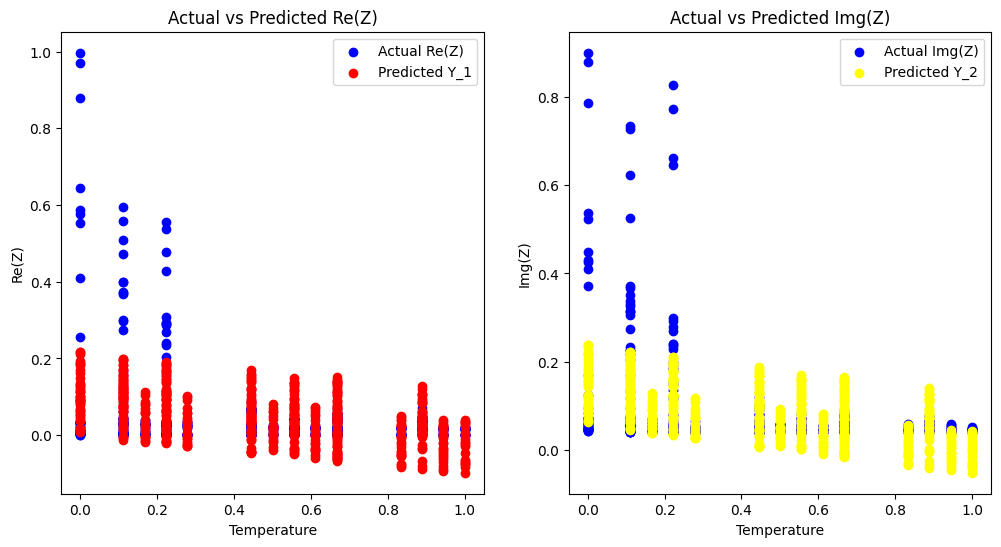

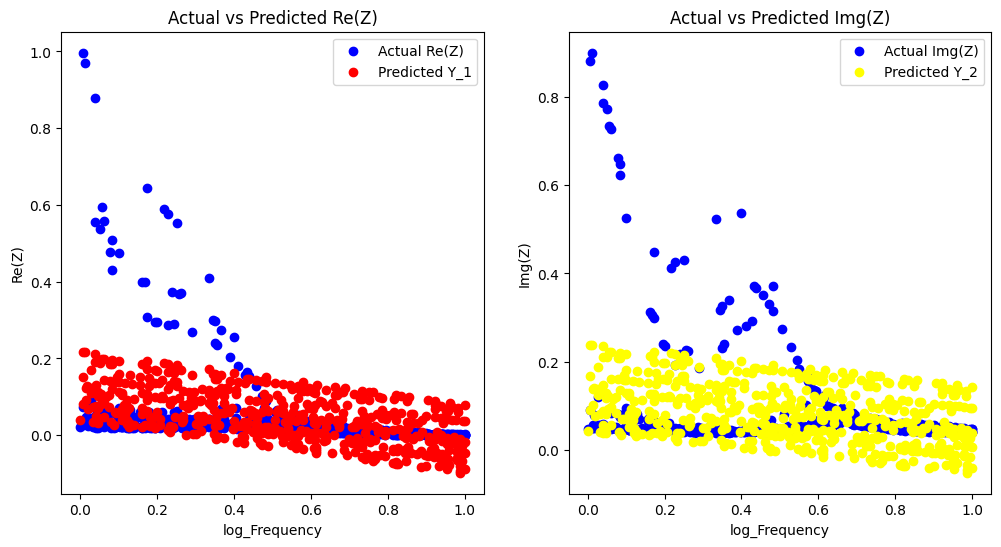

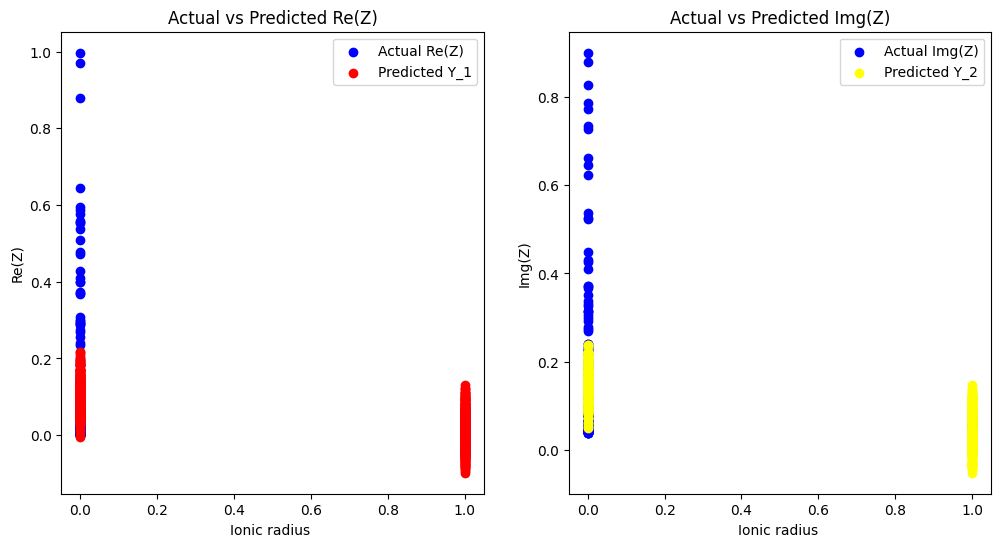

In [62]:
#Plotting predictions on validation data
y_val_pred_lr=pd.DataFrame(y_val_pred_lr,columns=['Re(Z)','Img(Z)'])
plot_pred(y_val_pred_lr)

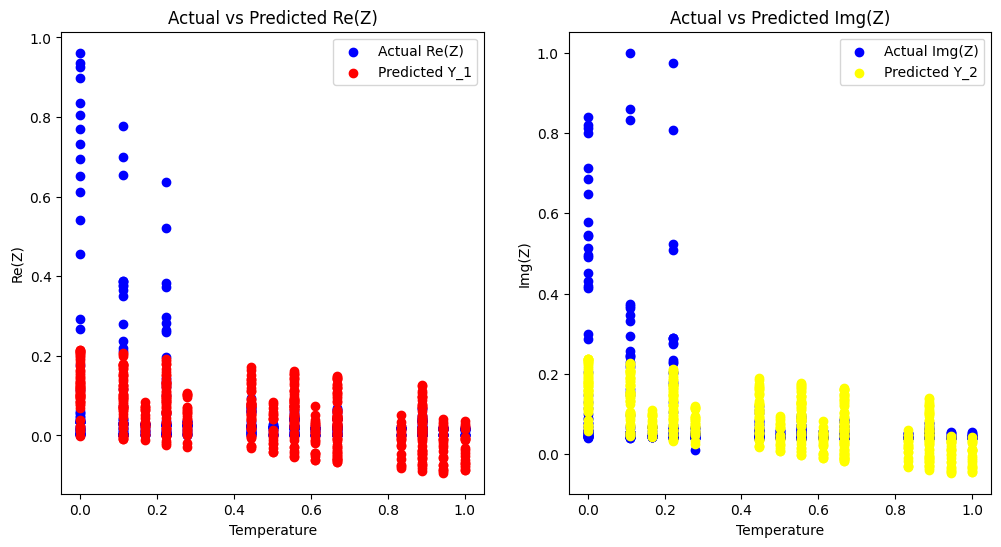

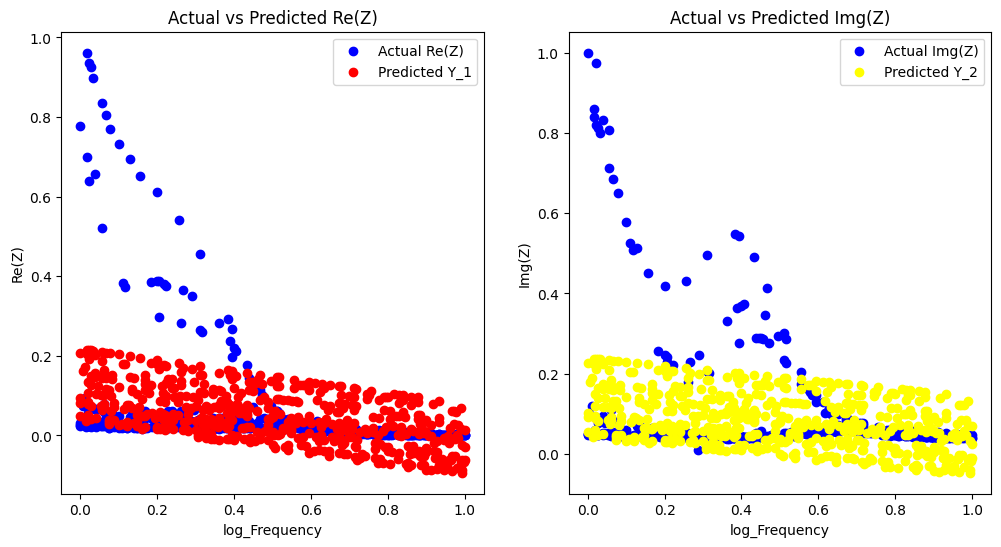

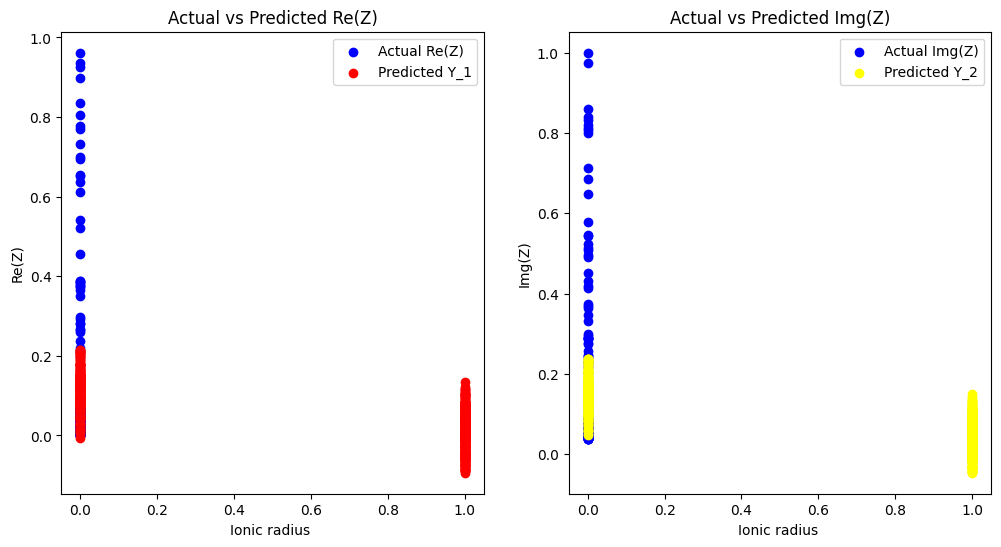

In [63]:
#Plotting predictions on testing data
y_test_pred_lr=pd.DataFrame(y_test_pred_lr,columns=['Re(Z)','Img(Z)'])
plot_pred_test(y_test_pred_lr)

#### 2. Gradient Boosting

##### Base model predictions and plots

In [64]:
gbr = MultiOutputRegressor(GradientBoostingRegressor())
gbr.fit(X_train_df,Y_train_df)
#prediction on train data
print("Prediction on train data")
y_train_pred_gbr=predict_(gbr,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
y_val_pred_gbr = predict_(gbr,X_val_df,Y_val_df)

Prediction on train data
MAE 0.005734814418278049
MSE 0.00013650931952962606
RMSE 0.01168372027778935
R2 score 0.9893464402400591
MAPE score 37336281004.220924


Prediction on val data
MAE 0.006459221461021799
MSE 0.00017748189224986715
RMSE 0.013322233005388666
R2 score 0.9872911703561429
MAPE score 0.2182393738284679


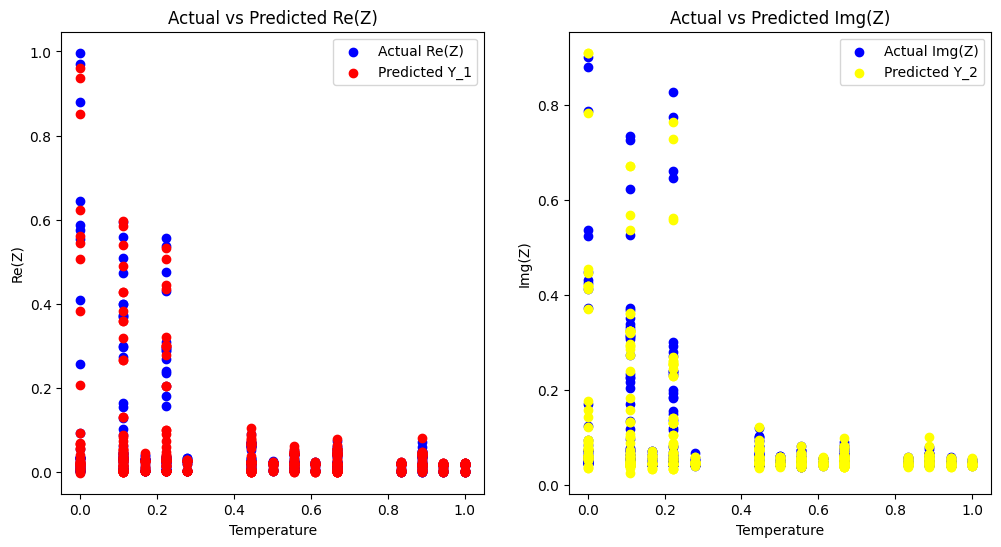

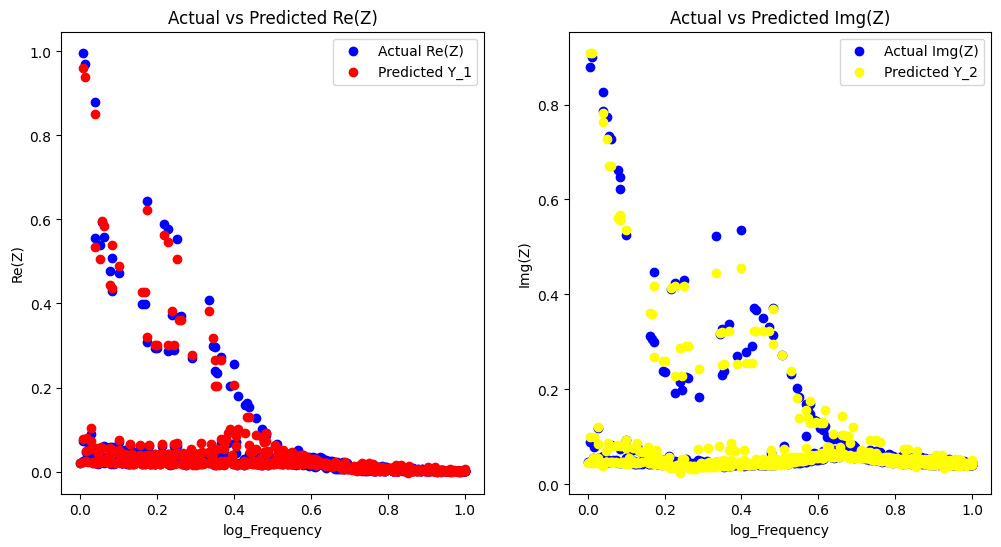

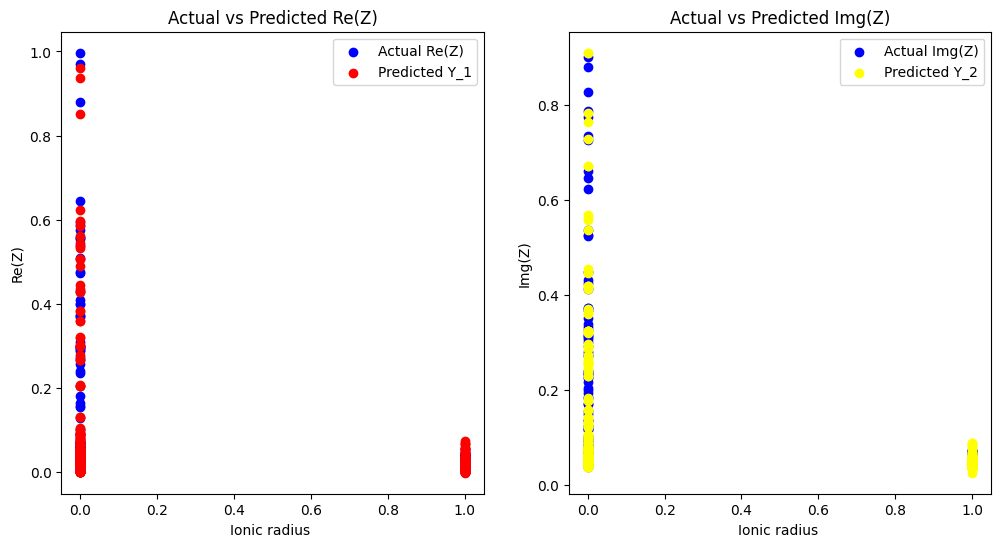

In [65]:
#Plotting predictions on validation data
y_val_pred_gbr=pd.DataFrame(y_val_pred_gbr,columns=['Re(Z)','Img(Z)'])
plot_pred(y_val_pred_gbr)

##### Applying hyperparameter tuning technique

In [66]:
gbr.get_params()

{'estimator__alpha': 0.9,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'squared_error',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': None,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingRegressor(),
 'n_jobs': None}

In [67]:
 g_gbr1={'estimator__learning_rate': [0.1,0.3,0.6],
        'estimator__max_depth':[3,10,15],
        'estimator__max_leaf_nodes': [10,20,30],
        'estimator__min_impurity_decrease': [0.0,0.1],
        'estimator__n_estimators': [100,200,250],
        'n_jobs': [-1],
        'estimator__random_state':[42]}
grid_gbr1=GridSearchCV(gbr,g_gbr1,cv=3,n_jobs=-1)
grid_gbr1.fit(X_train_df,Y_train_df)
best_grid_gbr1=grid_gbr1.best_estimator_
print('Best Parameters: ',grid_gbr1.best_params_)
print('Best Score: ',grid_gbr1.best_score_)

Best Parameters:  {'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__max_leaf_nodes': 20, 'estimator__min_impurity_decrease': 0.0, 'estimator__n_estimators': 250, 'estimator__random_state': 42, 'n_jobs': -1}
Best Score:  0.9966838247932671


In [68]:
 g_gbr2={
        'estimator__learning_rate': [0.1],
        'estimator__max_depth':[10],
        'estimator__max_leaf_nodes': [20],
        'estimator__min_impurity_decrease': [0.0],
        'estimator__n_estimators': [250],
        'n_jobs': [-1],
        'estimator__random_state':[42],
        'estimator__alpha': [0.1,0.4,0.9],
        'estimator__criterion':['friedman_mse', 'squared_error'],
        'estimator__min_samples_leaf':[1,2],
        'estimator__min_samples_split':[2,3],}
grid_gbr2=GridSearchCV(gbr,g_gbr2,cv=3,n_jobs=-1)
grid_gbr2.fit(X_train_df,Y_train_df)
best_grid_gbr2=grid_gbr2.best_estimator_
print('Best Parameters: ',grid_gbr2.best_params_)
print('Best Score: ',grid_gbr2.best_score_)

Best Parameters:  {'estimator__alpha': 0.1, 'estimator__criterion': 'friedman_mse', 'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__max_leaf_nodes': 20, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 250, 'estimator__random_state': 42, 'n_jobs': -1}
Best Score:  0.9968276840773825


In [69]:
 g_gbr3={
        'estimator__learning_rate': [0.1],
        'estimator__max_depth':[10],
        'estimator__max_leaf_nodes': [20],
        'estimator__min_impurity_decrease': [0.0],
        'estimator__n_estimators': [250],
        'n_jobs': [-1],
        'estimator__random_state':[42],
        'estimator__alpha': [0.1],
        'estimator__criterion':['friedman_mse'],
        'estimator__min_samples_leaf':[1],
        'estimator__min_samples_split':[3],
        'estimator__subsample': [0.1,0.5,0.7,0.8],
        'estimator__validation_fraction': [0.1,0.2]}
grid_gbr3=GridSearchCV(gbr,g_gbr3,cv=3,n_jobs=-1)
grid_gbr3.fit(X_train_df,Y_train_df)
best_grid_gbr3=grid_gbr3.best_estimator_
print('Best Parameters: ',grid_gbr3.best_params_)
print('Best Score: ',grid_gbr3.best_score_)

Best Parameters:  {'estimator__alpha': 0.1, 'estimator__criterion': 'friedman_mse', 'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__max_leaf_nodes': 20, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 3, 'estimator__n_estimators': 250, 'estimator__random_state': 42, 'estimator__subsample': 0.5, 'estimator__validation_fraction': 0.1, 'n_jobs': -1}
Best Score:  0.9972946211776006


In [70]:
#prediction on train data
print("Prediction on train data")
best_accuracy_train_gbr=predict_(best_grid_gbr3,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
best_accuracy_val_gbr = predict_(best_grid_gbr3,X_val_df,Y_val_df)

Prediction on train data
MAE 0.000788243561009355
MSE 1.8313203197176921e-06
RMSE 0.001353262842066423
R2 score 0.9998574739298877
MAPE score 12391558865.736618


Prediction on val data
MAE 0.0014089311794602383
MSE 1.1048155591148001e-05
RMSE 0.003323876590842085
R2 score 0.9992082730994933
MAPE score 0.05326306337963824


##### Result on test data

In [71]:
#Base model prediction on test data
print("Base model Prediction on test data")
y_test_pred_gbr = predict_(gbr,X_test_df,Y_test_df)
print("\n")
#Tuned model prediction on test data
print("Tuned model Prediction on test data")
best_accuracy_test_gbr = predict_(best_grid_gbr3,X_test_df,Y_test_df)

Base model Prediction on test data
MAE 0.007425538418312054
MSE 0.00026786392372026393
RMSE 0.016366548925178574
R2 score 0.9863151560067582
MAPE score 0.2092075591205219


Tuned model Prediction on test data
MAE 0.0019491042653560471
MSE 5.448171668001463e-05
RMSE 0.007381173123563397
R2 score 0.9972050587034285
MAPE score 0.05322646978561464


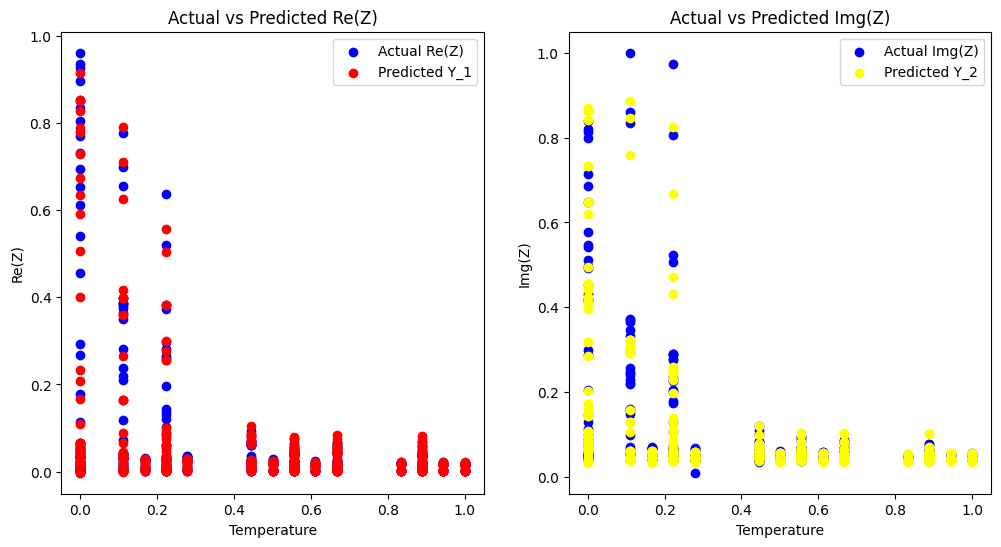

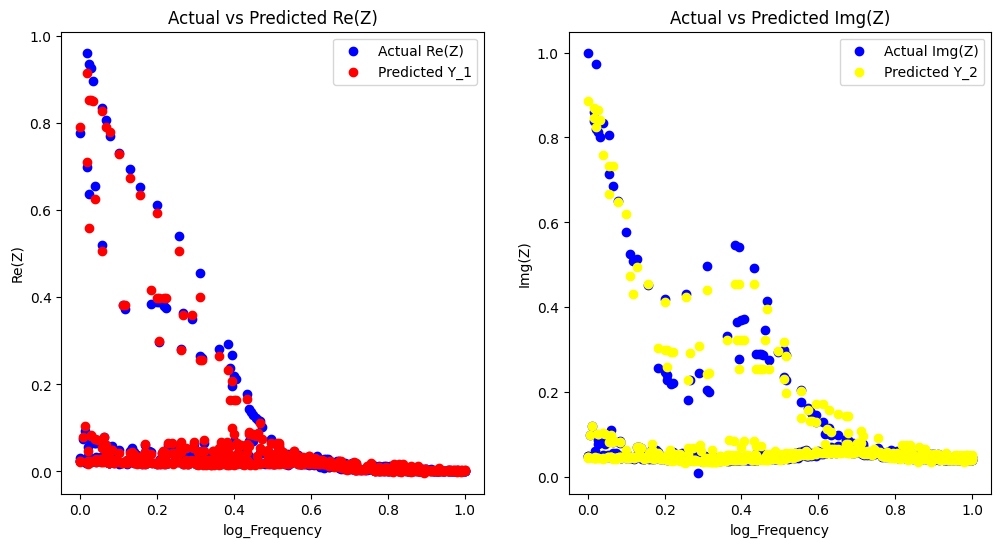

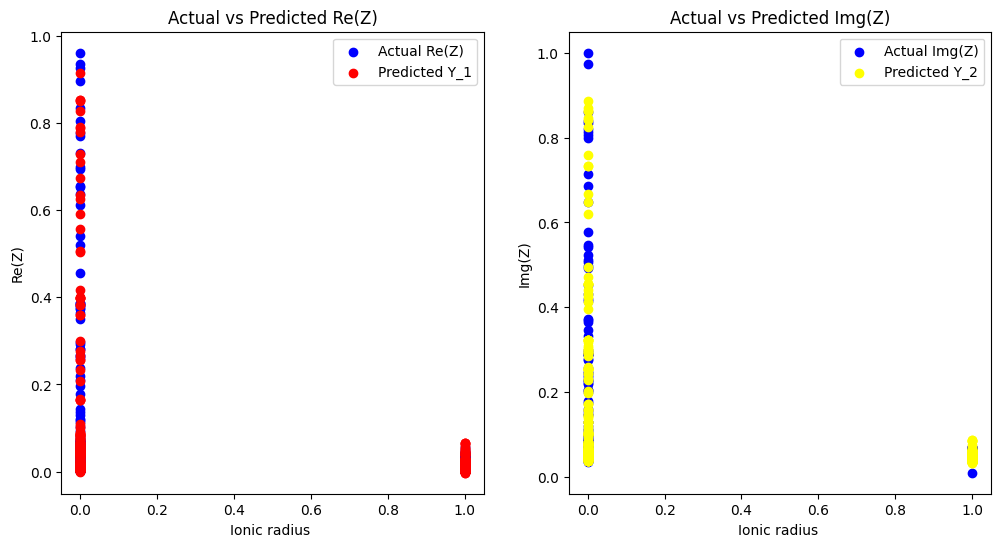

In [72]:
#Plotting base model predictions on test data
y_test_pred_gbr=pd.DataFrame(y_test_pred_gbr,columns=['Re(Z)','Img(Z)'])
plot_pred_test(y_test_pred_gbr)

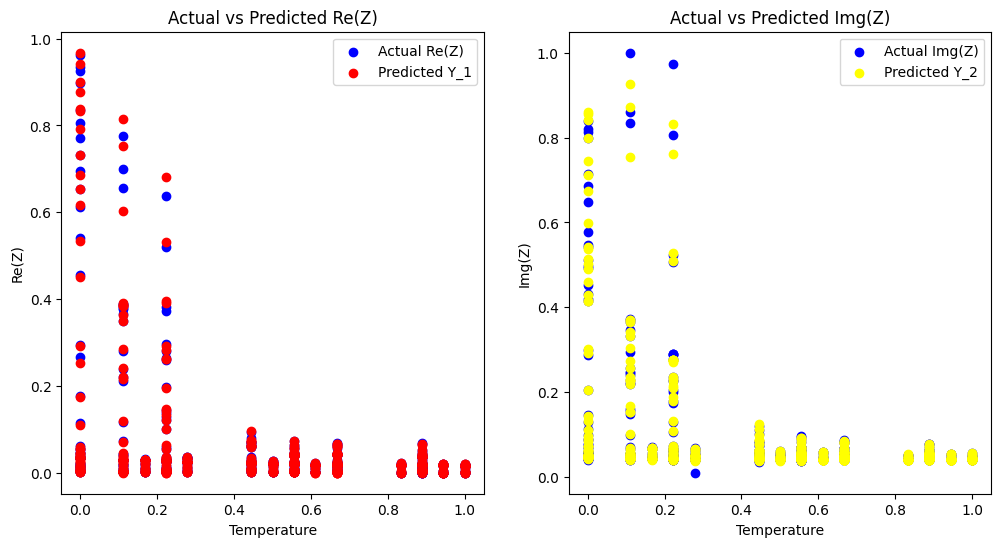

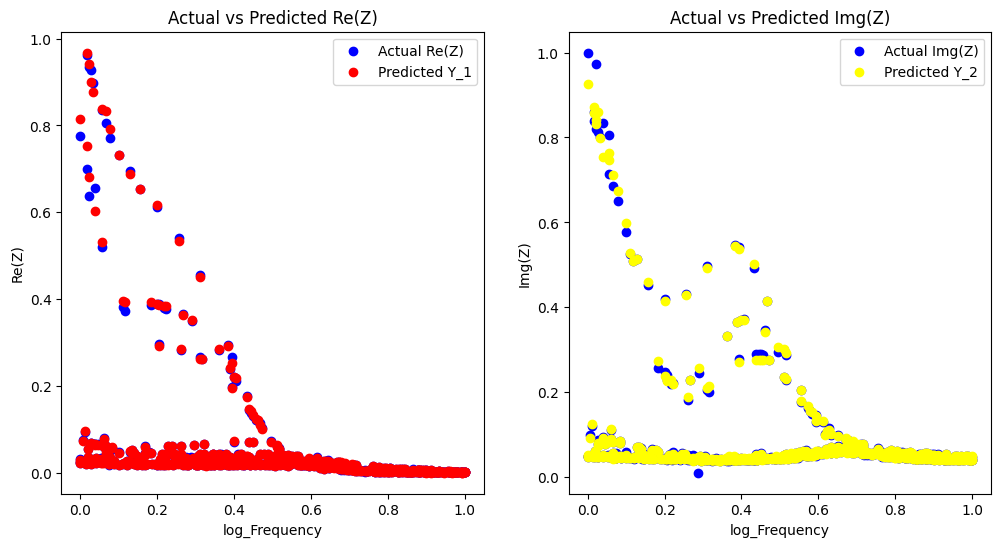

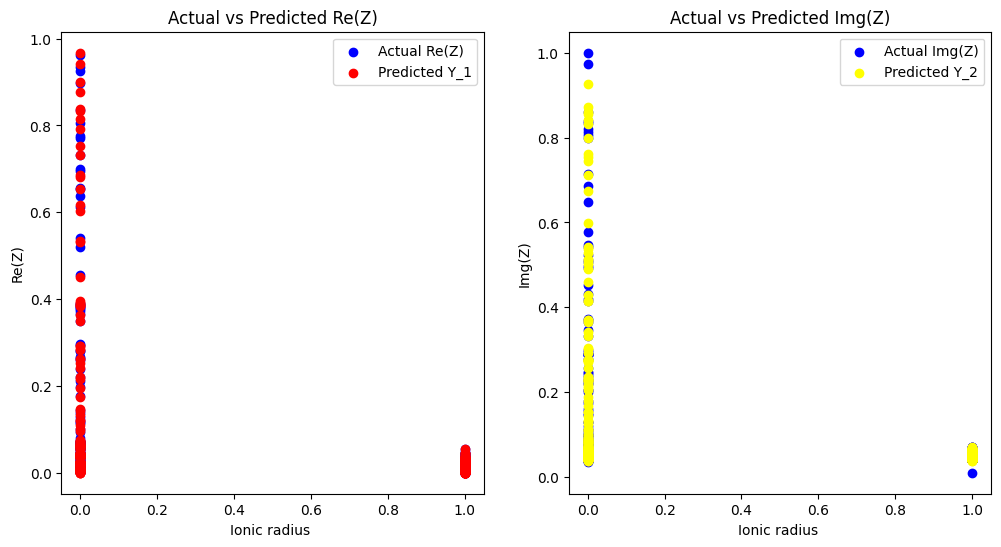

In [73]:
#Plotting tuned model predictions on test data
best_accuracy_test_gbr=pd.DataFrame(best_accuracy_test_gbr,columns=['Re(Z)','Img(Z)'])
plot_pred_test(best_accuracy_test_gbr)

#### 3. Gaussian Process Regressor (GPR)

##### Base Model predictions and plots

In [74]:
gp = GaussianProcessRegressor(kernel=None)
gp.fit(X_train_df,Y_train_df)
#prediction on train data
print("Prediction on train data")
y_train_pred_gp=predict_(gp,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
y_val_pred_gp = predict_(gp,X_val_df,Y_val_df)

Prediction on train data
MAE 0.00475098879369977
MSE 9.065410138129288e-05
RMSE 0.009521244739071299
R2 score 0.992935672597759
MAPE score 43425437055.579895


Prediction on val data
MAE 0.005214635414586659
MSE 9.357078237556254e-05
RMSE 0.009673199179979835
R2 score 0.9933080238408765
MAPE score 0.34737996523000575


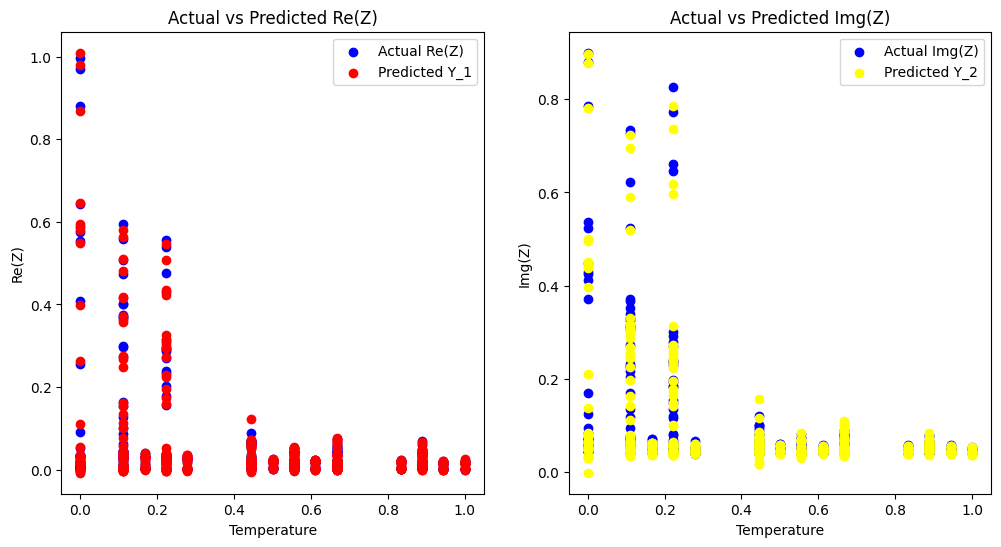

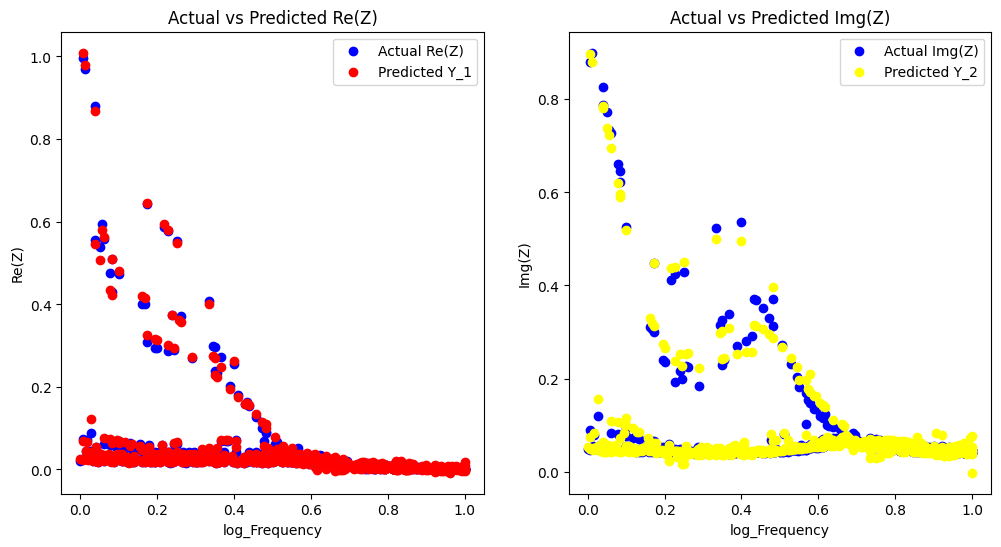

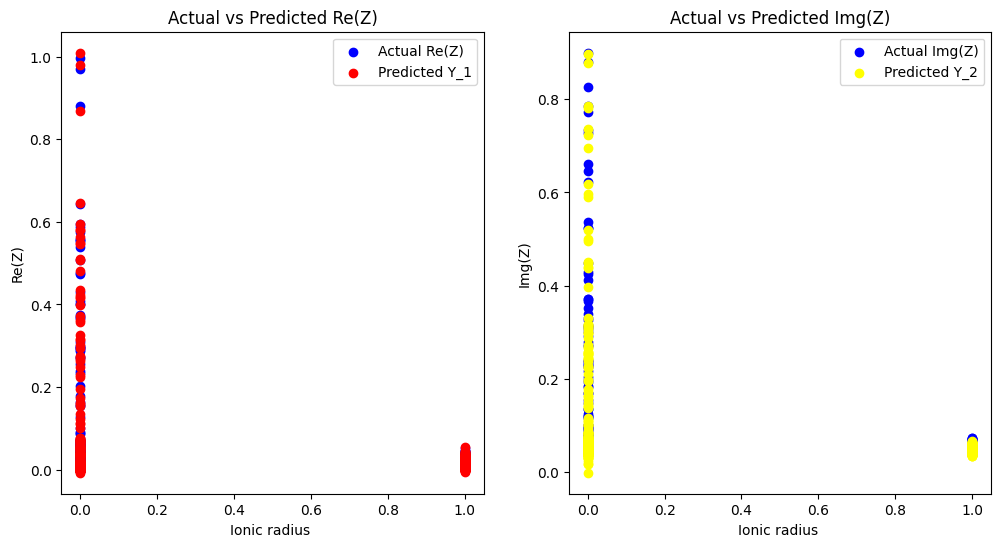

In [75]:
#Plotting predictions on validation data
y_val_pred_gp=pd.DataFrame(y_val_pred_gp,columns=['Re(Z)','Img(Z)'])
plot_pred(y_val_pred_gp)

##### Applying Hyperparameter tuning technique

In [76]:
gp.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [77]:
g_gp1={'n_restarts_optimizer':[0,10,20,30,40],
       'normalize_y':[True,False],
       'copy_X_train':[True,False]}
grid_gp1=GridSearchCV(gp,g_gp1,cv=3,n_jobs=-1)
grid_gp1.fit(X_train_df,Y_train_df)
best_grid_gp1=grid_gp1.best_estimator_
print('Best Parameters: ',grid_gp1.best_params_)
print('Best Score: ',grid_gp1.best_score_)

Best Parameters:  {'copy_X_train': True, 'n_restarts_optimizer': 0, 'normalize_y': True}
Best Score:  0.9909316501326924


In [78]:
#prediction on train data
print("Prediction on train data")
best_accuracy_train_gp=predict_(best_grid_gp1,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
best_accuracy_val_gp = predict_(best_grid_gp1,X_val_df,Y_val_df)

Prediction on train data
MAE 0.004750960662037843
MSE 9.065439968575954e-05
RMSE 0.009521260404261588
R2 score 0.992935649422825
MAPE score 43422232228.271034


Prediction on val data
MAE 0.005214653063570627
MSE 9.356856791312628e-05
RMSE 0.009673084715494136
R2 score 0.993308181789744
MAPE score 0.347377290145775


##### Result on test data

In [79]:
#Base model prediction on test data
print("Base model Prediction on test data")
y_test_pred_gp = predict_(gp,X_test_df,Y_test_df)
print("\n")
#Tuned model prediction on test data
print("Tuned model Prediction on test data")
best_accuracy_test_gp = predict_(best_grid_gp1,X_test_df,Y_test_df)

Base model Prediction on test data
MAE 0.005543201121160497
MSE 0.0001275757194860165
RMSE 0.011294942208175148
R2 score 0.9934444495775872
MAPE score 0.29662387660483314


Tuned model Prediction on test data
MAE 0.005543074554211136
MSE 0.00012756914667779863
RMSE 0.01129465124197284
R2 score 0.9934447897177493
MAPE score 0.2965829862450402


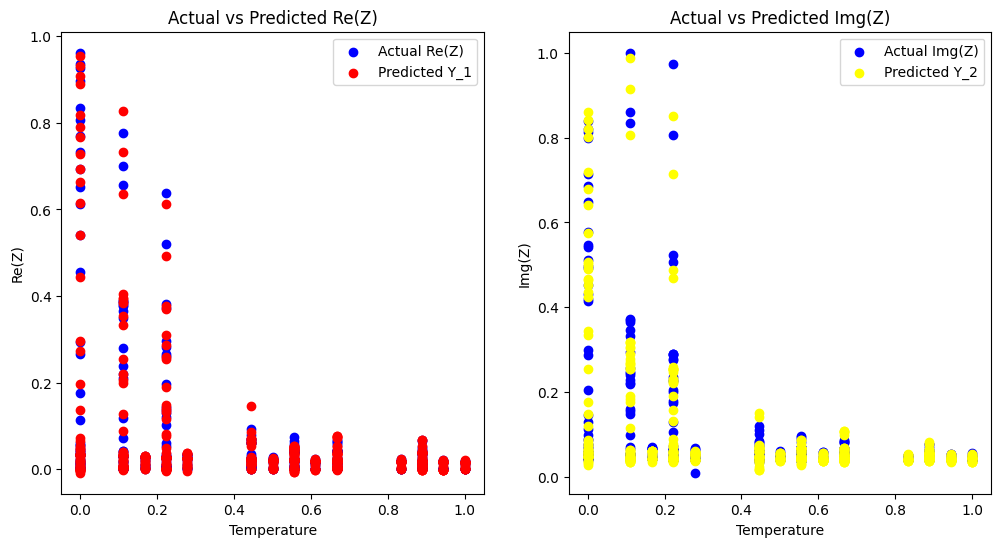

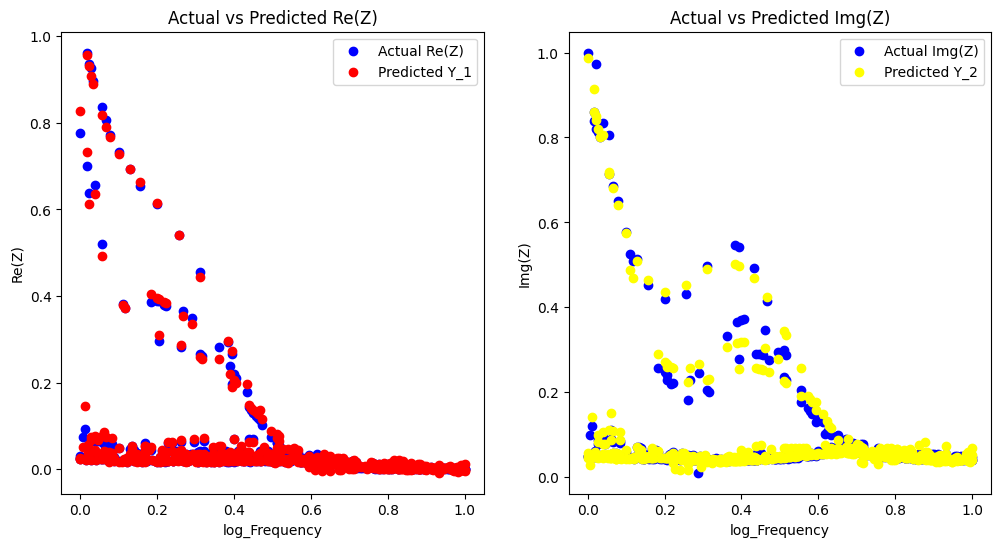

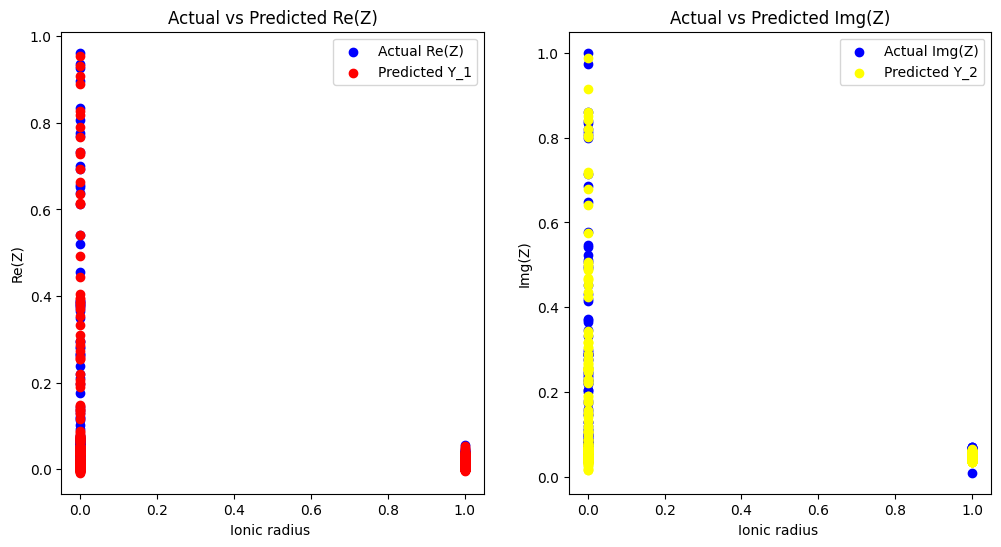

In [80]:
#Plotting base model predictions on test data
y_test_pred_gp=pd.DataFrame(y_test_pred_gp,columns=['Re(Z)','Img(Z)'])
plot_pred_test(y_test_pred_gp)

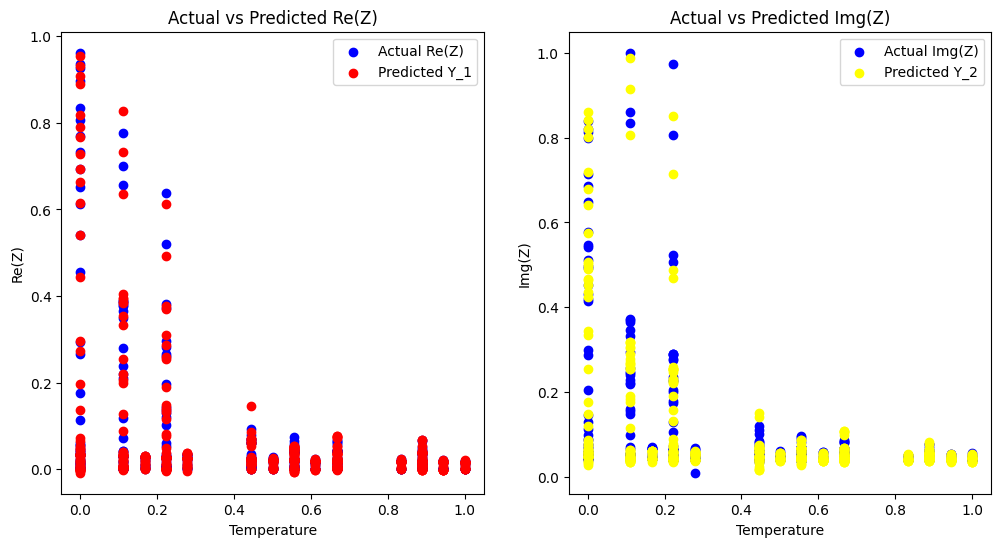

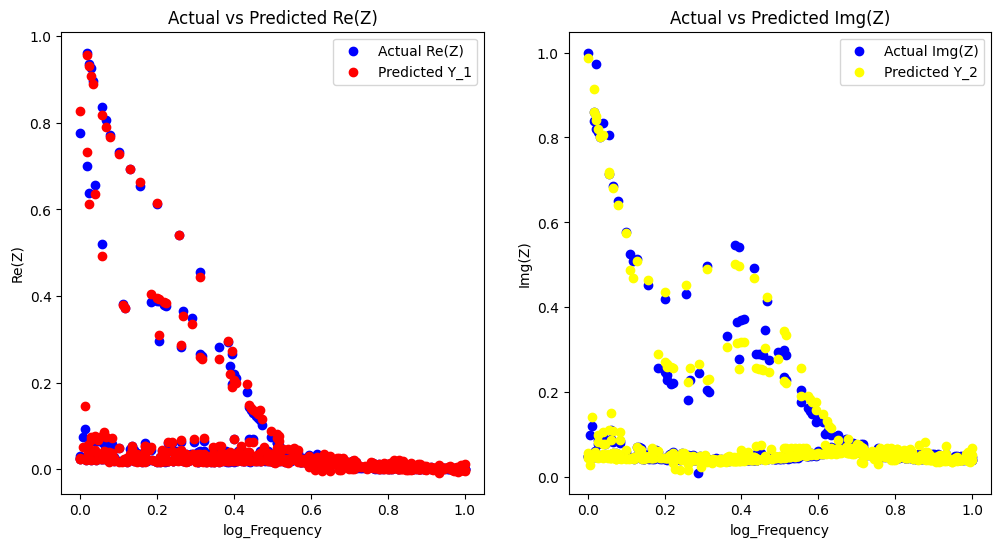

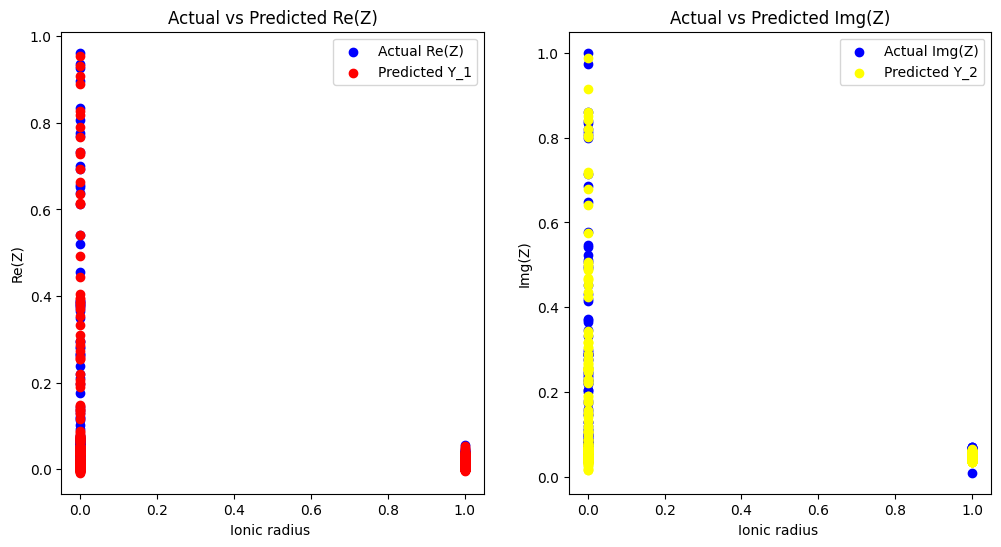

In [81]:
#Plotting tuned model predictions on test data
best_accuracy_test_gp=pd.DataFrame(best_accuracy_test_gp,columns=['Re(Z)','Img(Z)'])
plot_pred_test(best_accuracy_test_gp)

#### 4. XGBoost

##### Base model predictions and plotting

In [82]:
xgbr = XGBRegressor()
xgbr.fit(X_train_df,Y_train_df)
#prediction on train data
print("Prediction on train data")
y_train_pred_xgbr=predict_(xgbr,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
y_val_pred_xgbr = predict_(xgbr,X_val_df,Y_val_df)

Prediction on train data
MAE 0.000905256811187659
MSE 6.029239070287475e-06
RMSE 0.0024554508894065615
R2 score 0.9995291064104115
MAPE score 17619721460.945877


Prediction on val data
MAE 0.0016475499157052554
MSE 2.0124271463853925e-05
RMSE 0.004486008411032454
R2 score 0.998556790511069
MAPE score 0.0427956435166257


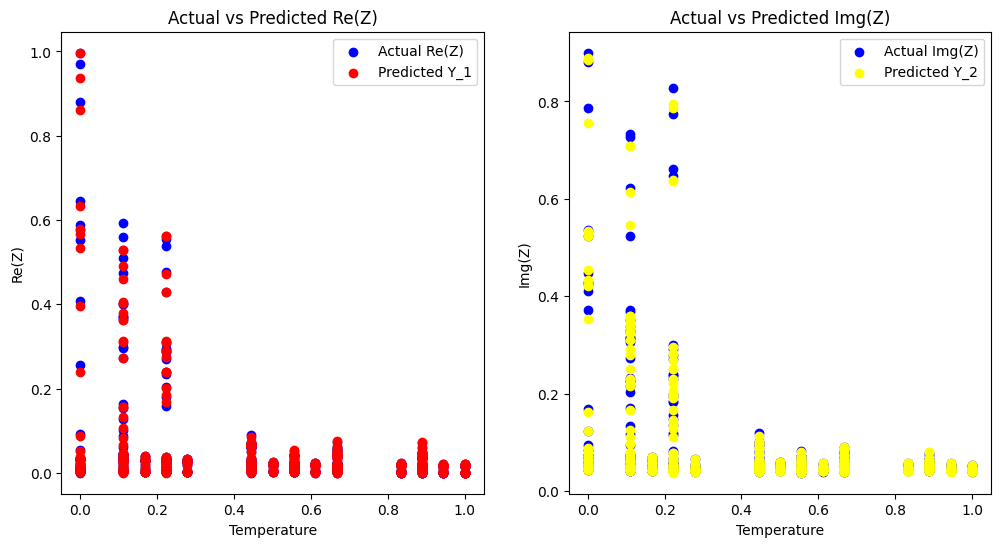

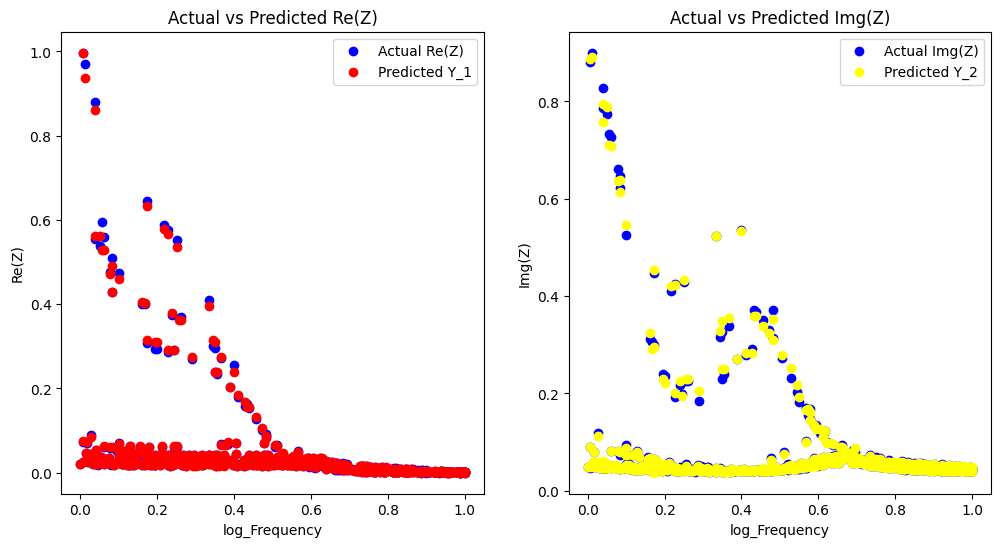

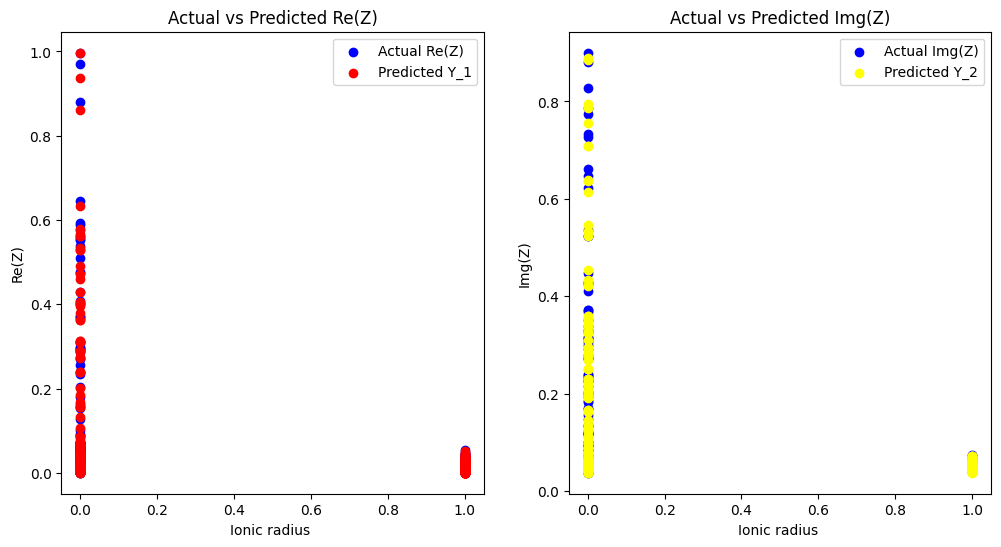

In [83]:
#Plotting predictions on validation data
y_val_pred_xgbr=pd.DataFrame(y_val_pred_xgbr,columns=['Re(Z)','Img(Z)'])
plot_pred(y_val_pred_xgbr)

##### Applying Hyperparameter tuning technique

In [84]:
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [85]:
g_xgbr1={'learning_rate':[0.1,0.3],
         'n_estimators': [100,250,300,350],
         'gamma':[0,1,5],
         'reg_lambda':[0,1,5],
         'reg_alpha':[0,1,5]}
grid_xgbr1=GridSearchCV(xgbr,g_xgbr1,cv=3,n_jobs=-1)
grid_xgbr1.fit(X_train_df,Y_train_df)
best_grid_xgbr1=grid_xgbr1.best_estimator_
print('Best Parameters: ',grid_xgbr1.best_params_)
print('Best Score: ',grid_xgbr1.best_score_)

Best Parameters:  {'gamma': 0, 'learning_rate': 0.3, 'n_estimators': 350, 'reg_alpha': 0, 'reg_lambda': 0}
Best Score:  0.9958306533411428


In [86]:
g_xgbr2={'learning_rate':[0.1],
         'n_estimators': [100,150],
         'gamma':[0,1],
         'reg_lambda':[0,1],
         'reg_alpha':[0,1]}
grid_xgbr2=GridSearchCV(xgbr,g_xgbr2,cv=3,n_jobs=-1)
grid_xgbr2.fit(X_train_df,Y_train_df)
best_grid_xgbr2=grid_xgbr2.best_estimator_
print('Best Parameters: ',grid_xgbr2.best_params_)
print('Best Score: ',grid_xgbr2.best_score_)

Best Parameters:  {'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}
Best Score:  0.9957549201194595


In [87]:
g_xgbr3={'learning_rate':[0.1],
         'n_estimators': [100],
         'gamma':[0],
         'reg_lambda':[0],
         'reg_alpha':[0],
         'objective':['reg:squarederror','reg:absoluteerror'],
         'booster':['gbtree','gblinear','dart'],
         'subsample':[0.5,0.7],
         'tree_method':['auto','exact','approx','hist']}
grid_xgbr3=GridSearchCV(xgbr,g_xgbr3,cv=3,n_jobs=-1)
grid_xgbr3.fit(X_train_df,Y_train_df)
best_grid_xgbr3=grid_xgbr3.best_estimator_
print('Best Parameters: ',grid_xgbr3.best_params_)
print('Best Score: ',grid_xgbr3.best_score_)

Best Parameters:  {'booster': 'dart', 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.7, 'tree_method': 'exact'}
Best Score:  0.9972581196464869


In [88]:
g_xgbr4={'learning_rate':[0.1],
         'n_estimators': [100],
         'gamma':[0],
         'reg_lambda':[0],
         'reg_alpha':[0],
         'objective':['reg:squarederror'],
         'booster':['gbtree'],
         'subsample':[0.3,0.4,0.5,0.6],
         'tree_method':['exact'],
         'max_depth':[20,21],
         'min_child_weight':[3,4]}
grid_xgbr4=GridSearchCV(xgbr,g_xgbr4,cv=3,n_jobs=-1)
grid_xgbr4.fit(X_train_df,Y_train_df)
best_grid_xgbr4=grid_xgbr4.best_estimator_
print('Best Parameters: ',grid_xgbr4.best_params_)
print('Best Score: ',grid_xgbr4.best_score_)

Best Parameters:  {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.6, 'tree_method': 'exact'}
Best Score:  0.9972401301630542


In [89]:
g_xgbr5={'learning_rate':[0.1],
         'n_estimators': [100],
         'gamma':[0],
         'reg_lambda':[0],
         'reg_alpha':[0],
         'objective':['reg:squarederror'],
         'booster':['gbtree'],
         'subsample':[0.6],
         'tree_method':['exact'],
         'max_depth':[21],
         'min_child_weight':[3],
         'max_delta_step':[3,4,7]}
grid_xgbr5=GridSearchCV(xgbr,g_xgbr5,cv=3,n_jobs=-1)
grid_xgbr5.fit(X_train_df,Y_train_df)
best_grid_xgbr5=grid_xgbr5.best_estimator_
print('Best Parameters: ',grid_xgbr5.best_params_)
print('Best Score: ',grid_xgbr5.best_score_)

Best Parameters:  {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 3, 'max_depth': 21, 'min_child_weight': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.6, 'tree_method': 'exact'}
Best Score:  0.9971808179106499


In [90]:
#prediction on train data
print("Prediction on train data")
best_accuracy_train_xgbr=predict_(best_grid_xgbr5,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
best_accuracy_val_xgbr = predict_(best_grid_xgbr5,X_val_df,Y_val_df)

Prediction on train data
MAE 0.0004949938229949998
MSE 3.7438692386767855e-06
RMSE 0.0019349080698257439
R2 score 0.9997077817729582
MAPE score 14898503683.332813


Prediction on val data
MAE 0.0011072933468783887
MSE 2.1499984207382804e-05
RMSE 0.004636807544785831
R2 score 0.9984555453590946
MAPE score 0.02471822916287163


##### Result on test data

In [91]:
#Base model prediction on test data
print("Base model Prediction on test data")
y_test_pred_xgbr = predict_(xgbr,X_test_df,Y_test_df)
print("\n")
#Tuned model prediction on test data
print("Tuned model Prediction on test data")
best_accuracy_test_xgbr = predict_(best_grid_xgbr5,X_test_df,Y_test_df)

Base model Prediction on test data
MAE 0.0022155553724721323
MSE 7.268682140165358e-05
RMSE 0.008525656655158802
R2 score 0.9962980127486192
MAPE score 0.04306920310029415


Tuned model Prediction on test data
MAE 0.0016311529043045716
MSE 6.1016794193747984e-05
RMSE 0.007811324740000763
R2 score 0.9968866572210477
MAPE score 0.026534414942654842


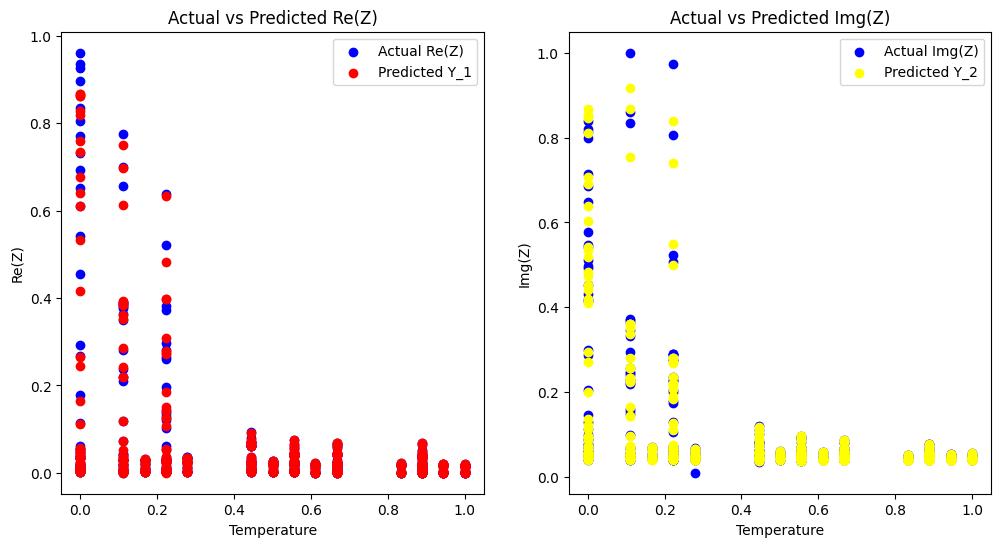

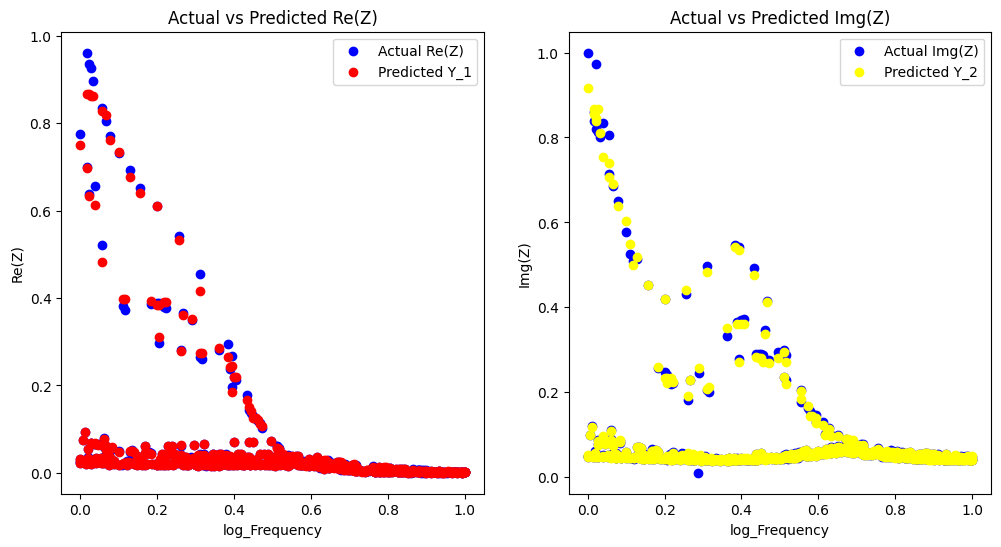

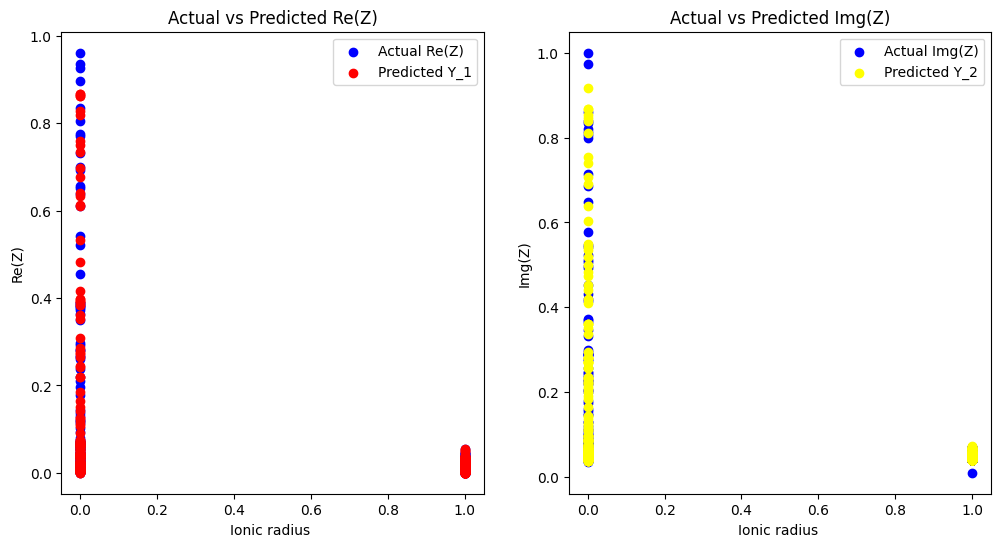

In [92]:
#Plotting base model predictions on test data
y_test_pred_xgbr=pd.DataFrame(y_test_pred_xgbr,columns=['Re(Z)','Img(Z)'])
plot_pred_test(y_test_pred_xgbr)

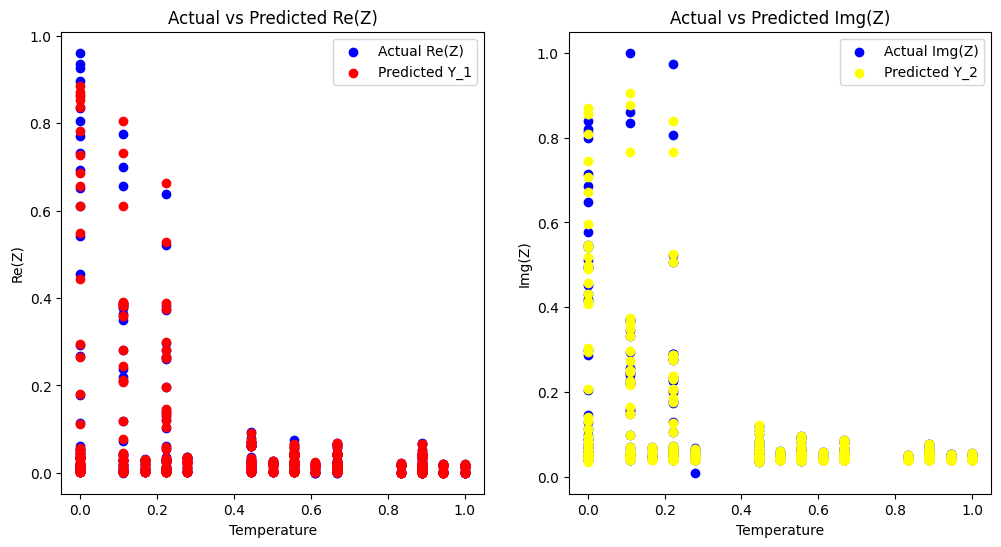

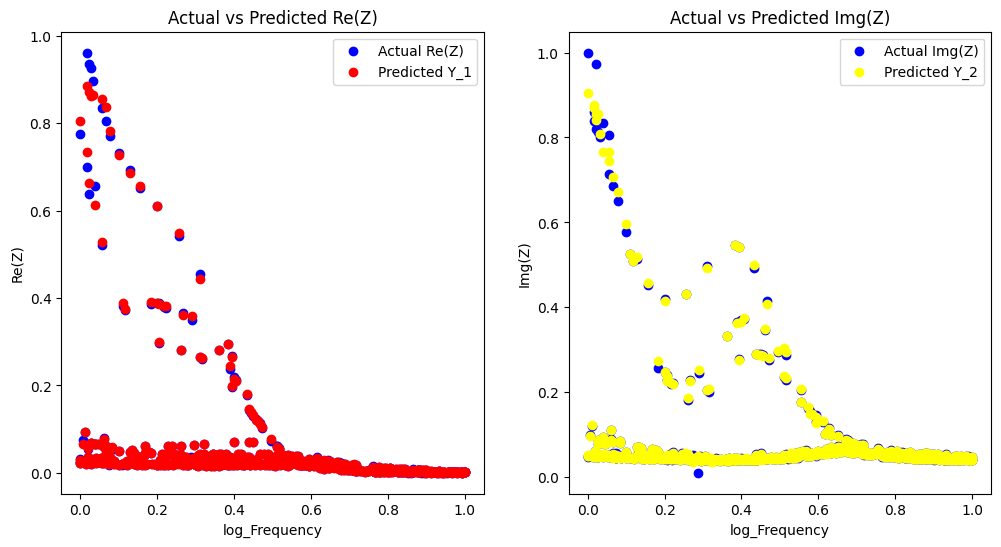

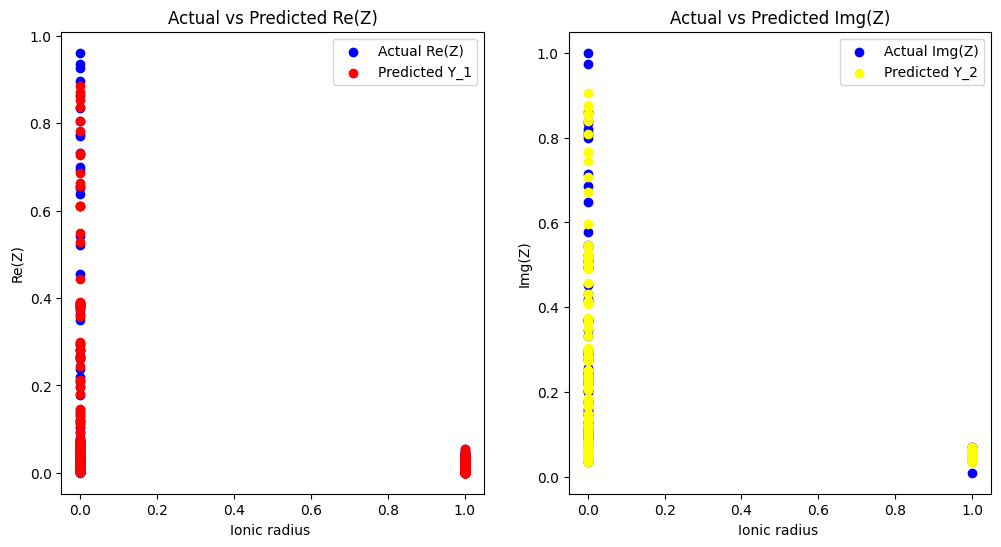

In [93]:
#Plotting tuned model predictions on test data
best_accuracy_test_xgbr=pd.DataFrame(best_accuracy_test_xgbr,columns=['Re(Z)','Img(Z)'])
plot_pred_test(best_accuracy_test_xgbr)

#### 5. Decision Tree

##### Base model predictions and plots

In [94]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_df,Y_train_df)
#prediction on train data
print("Prediction on train data")
y_train_pred_dt=predict_(dt,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
y_val_pred_dt = predict_(dt,X_val_df,Y_val_df)

Prediction on train data
MAE 0.0
MSE 0.0
RMSE 0.0
R2 score 1.0
MAPE score 0.0


Prediction on val data
MAE 0.0015136890780655617
MSE 2.6902091553984386e-05
RMSE 0.005186722621654679
R2 score 0.9980724439222737
MAPE score 0.028806850174983814


In [95]:
dt.tree_.max_depth

25

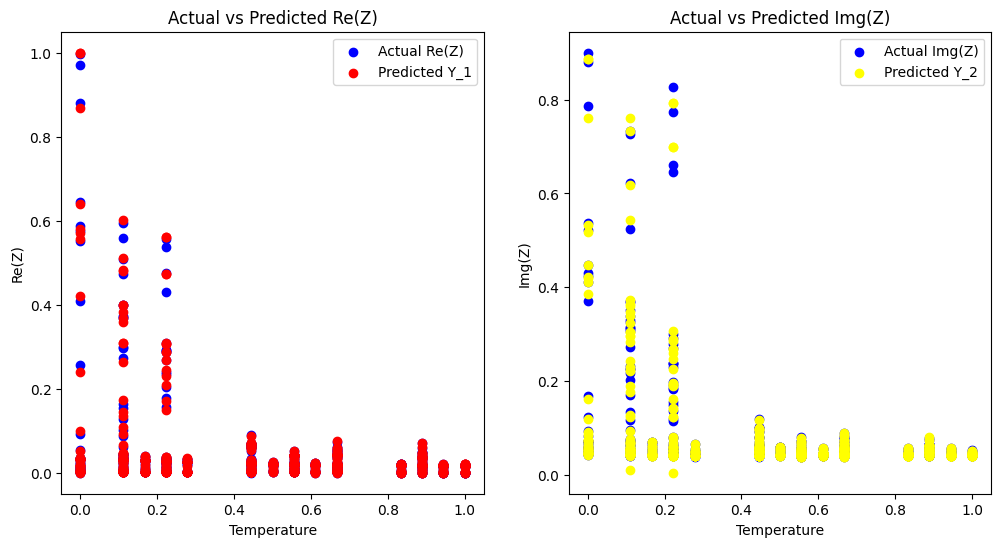

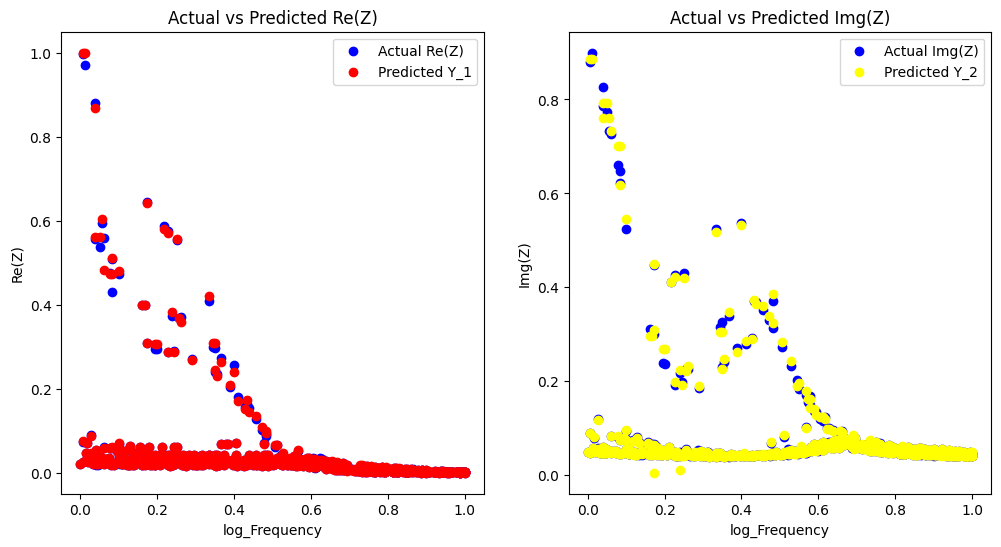

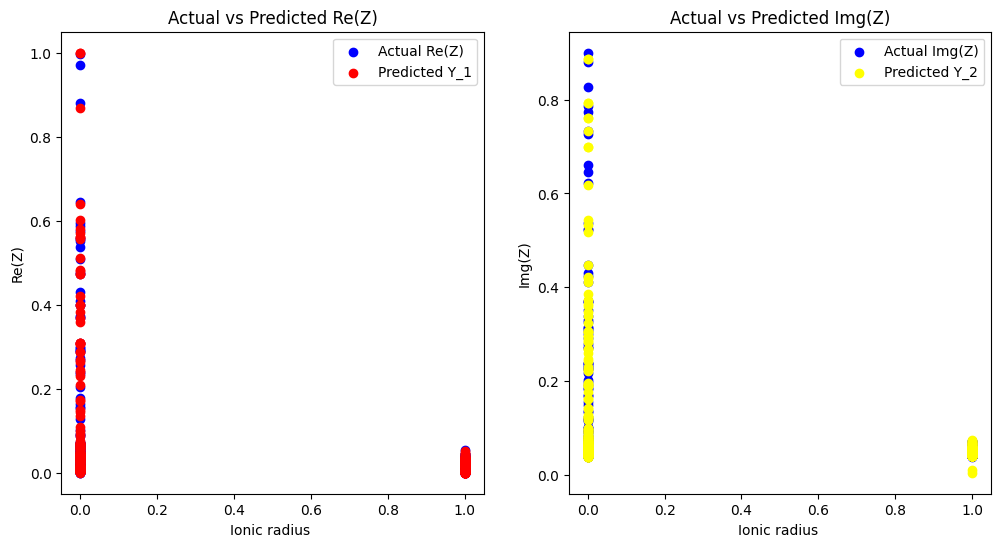

In [96]:
#Plotting predictions on validation data
y_val_pred_dt=pd.DataFrame(y_val_pred_dt,columns=['Re(Z)','Img(Z)'])
plot_pred(y_val_pred_dt)

##### Applying Hyperparameter tuning techniques

In [97]:
dt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [98]:
g_dt={'splitter': ['best','random'],
      'max_depth': [5,10,20],
      'min_samples_leaf': [2,4,5],
      'min_samples_split': [2,5,10],
      'max_features': ['log2','sqrt',None],
      'max_leaf_nodes': [300,500,600,700]}

grid_dt=GridSearchCV(dt,g_dt,n_jobs=-1)
grid_dt.fit(X_train_df,Y_train_df)
best_grid_dt=grid_dt.best_estimator_
print('Best Parameters: ',grid_dt.best_params_)
print('Best Score: ',grid_dt.best_score_)

Best Parameters:  {'max_depth': 20, 'max_features': None, 'max_leaf_nodes': 700, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Best Score:  0.9942776934083672


In [99]:
g_dt2={'splitter': ['best'],
      'max_depth': [20],
      'min_samples_leaf': [2],
      'min_samples_split': [2],
      'criterion': ['squared_error','absolute_error','friedman_mse','poisson'],
      'max_features': [None],
      'max_leaf_nodes': [600,700,800]}


grid_dt2=GridSearchCV(dt,g_dt2,n_jobs=-1)
grid_dt2.fit(X_train_df,Y_train_df)
best_grid_dt2=grid_dt2.best_estimator_
print('Best Parameters: ',grid_dt2.best_params_)
print('Best Score: ',grid_dt2.best_score_)

Best Parameters:  {'criterion': 'squared_error', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': 800, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Best Score:  0.9942780159310047


In [100]:
g_dt3={'splitter': ['best'],
      'max_depth': [20],
      'min_samples_leaf': [2],
      'min_samples_split': [2],
      'criterion': ['squared_error'],
      'max_features': [None],
      'max_leaf_nodes': [800]
       }

grid_dt3=GridSearchCV(dt,g_dt3,n_jobs=-1)
grid_dt3.fit(X_train_df,Y_train_df)
best_grid_dt3=grid_dt3.best_estimator_
print('Best Parameters: ',grid_dt3.best_params_)
print('Best Score: ',grid_dt3.best_score_)

Best Parameters:  {'criterion': 'squared_error', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': 800, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Best Score:  0.9942780159310047


In [101]:
#prediction on train data"
print("Prediction on train data")
best_accuracy_train_dt=predict_(best_grid_dt3,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
best_accuracy_val_dt = predict_(best_grid_dt3,X_val_df,Y_val_df)

Prediction on train data
MAE 0.0010092422372275037
MSE 1.6220115804596832e-05
RMSE 0.004027420490164496
R2 score 0.9987331351703446
MAPE score 22263512978.1258


Prediction on val data
MAE 0.0020757773004885403
MSE 4.8650699693142045e-05
RMSE 0.006975005354345045
R2 score 0.9965159196101292
MAPE score 0.03672163756421917


##### Result on test data

In [102]:
#Base model prediction on test data
print("Base model Prediction on test data")
y_test_pred_dt = predict_(dt,X_test_df,Y_test_df)
print("\n")
#Tuned model prediction on test data
print("Tuned model Prediction on test data")
best_accuracy_test_dt = predict_(best_grid_dt3,X_test_df,Y_test_df)

Base model Prediction on test data
MAE 0.002035435522475466
MSE 6.671460411501489e-05
RMSE 0.008167900838955801
R2 score 0.9965957828261428
MAPE score 0.03024462762639595


Tuned model Prediction on test data
MAE 0.0021045165322499835
MSE 5.886536313892216e-05
RMSE 0.007672376629110575
R2 score 0.9969907312246419
MAPE score 0.0378611123261098


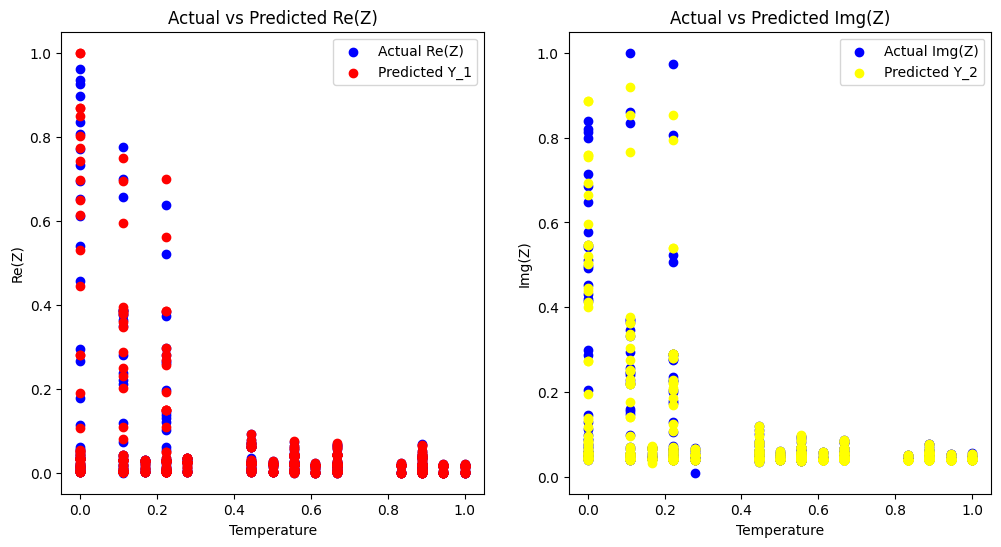

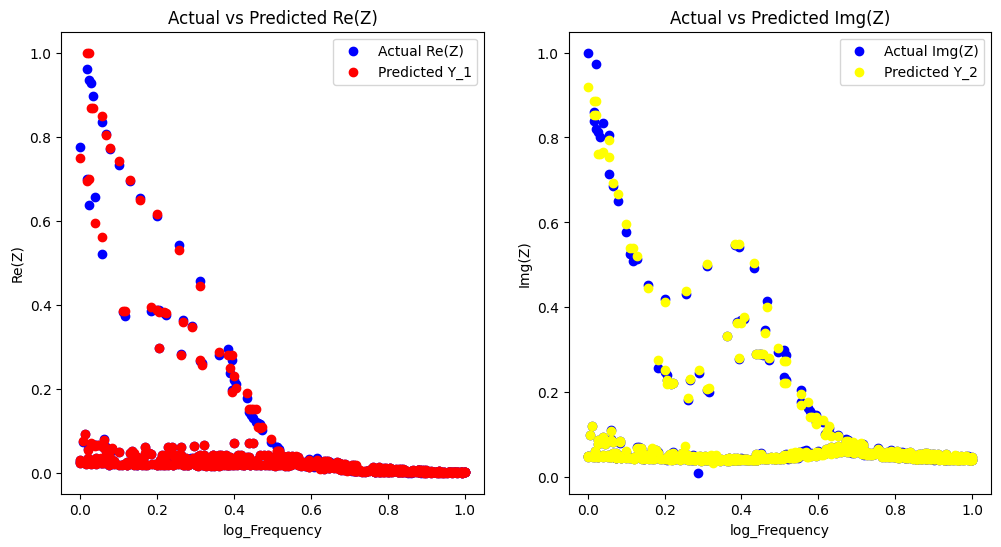

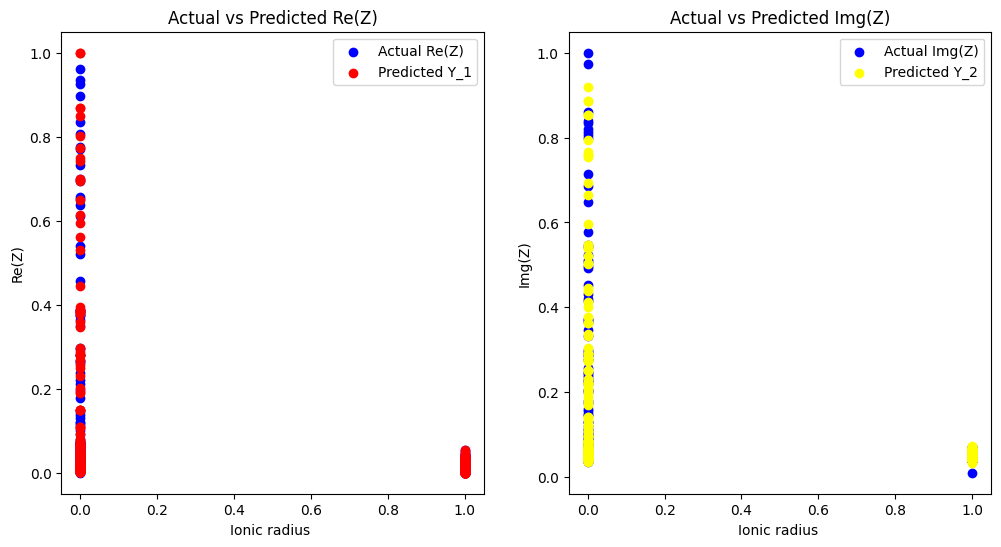

In [103]:
#Plotting base model predictions on test data
y_test_pred_dt=pd.DataFrame(y_test_pred_dt,columns=['Re(Z)','Img(Z)'])
plot_pred_test(y_test_pred_dt)

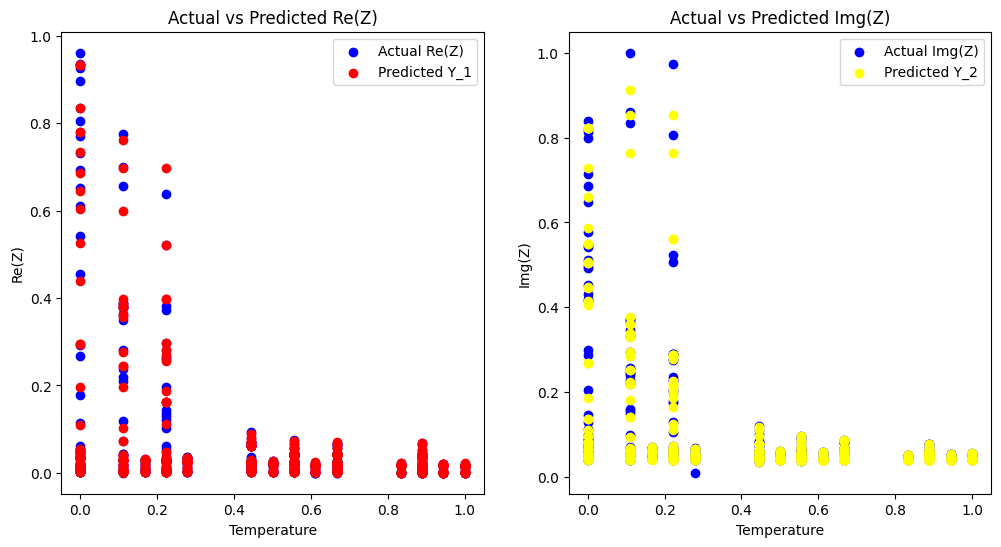

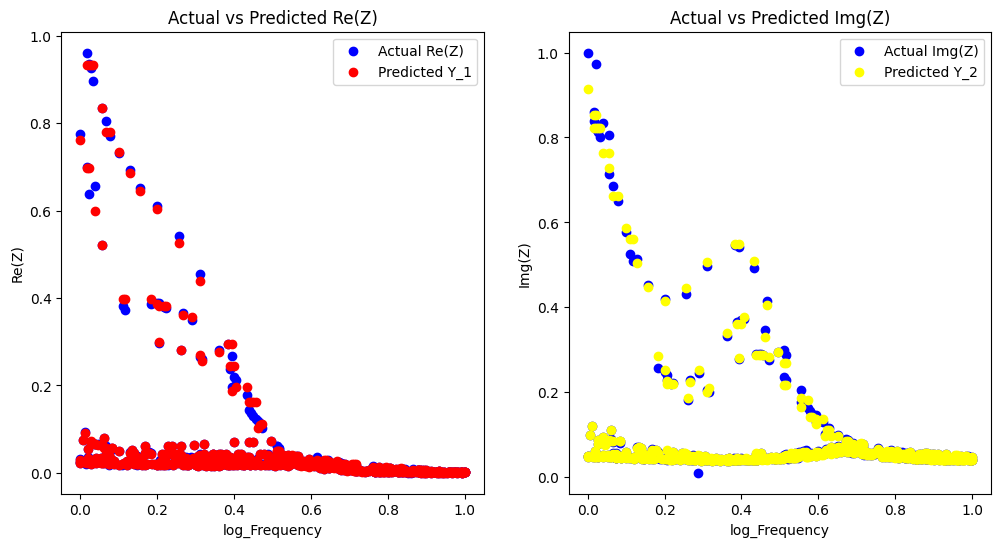

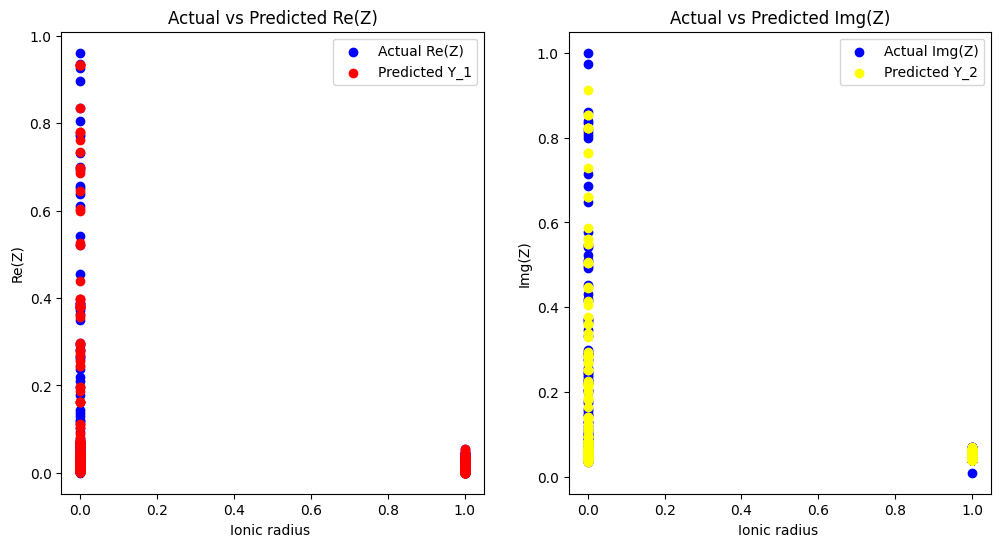

In [104]:
#Plotting tuned model predictions on test data
best_accuracy_test_dt=pd.DataFrame(best_accuracy_test_dt,columns=['Re(Z)','Img(Z)'])
plot_pred_test(best_accuracy_test_dt)

#### 6. Random Forest

##### Base model predictions and plots

In [105]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_df,Y_train_df)
#prediction on train data
print("Prediction on train data")
y_train_pred_rfr=predict_(rfr,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
y_val_pred_rfr = predict_(rfr,X_val_df,Y_val_df)

Prediction on train data
MAE 0.0005338216499567123
MSE 5.89645898563374e-06
RMSE 0.002428262544626042
R2 score 0.9995386969262089
MAPE score 20360782903.891865


Prediction on val data
MAE 0.0012562061079322319
MSE 2.45010432417658e-05
RMSE 0.0049498528505164474
R2 score 0.9982414388355639
MAPE score 0.019644463187864995


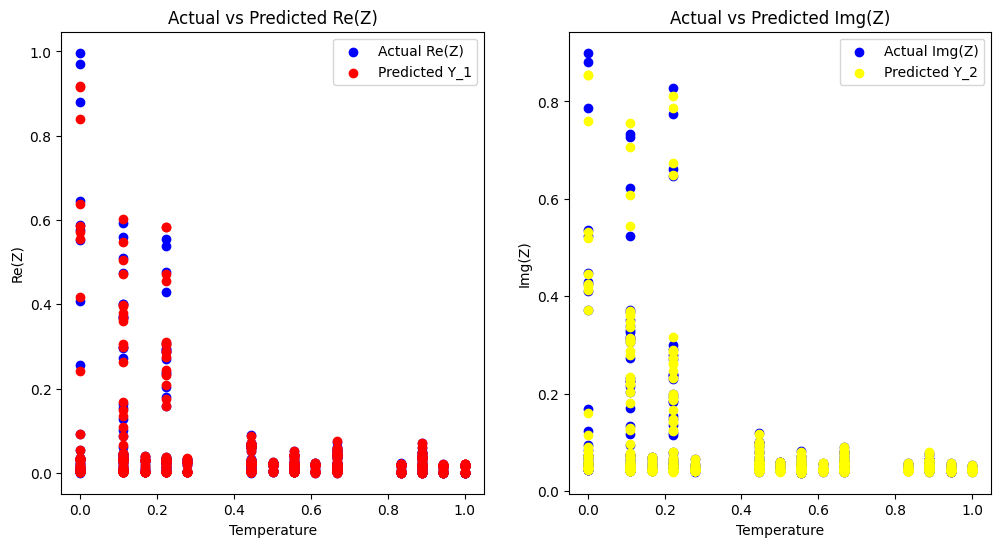

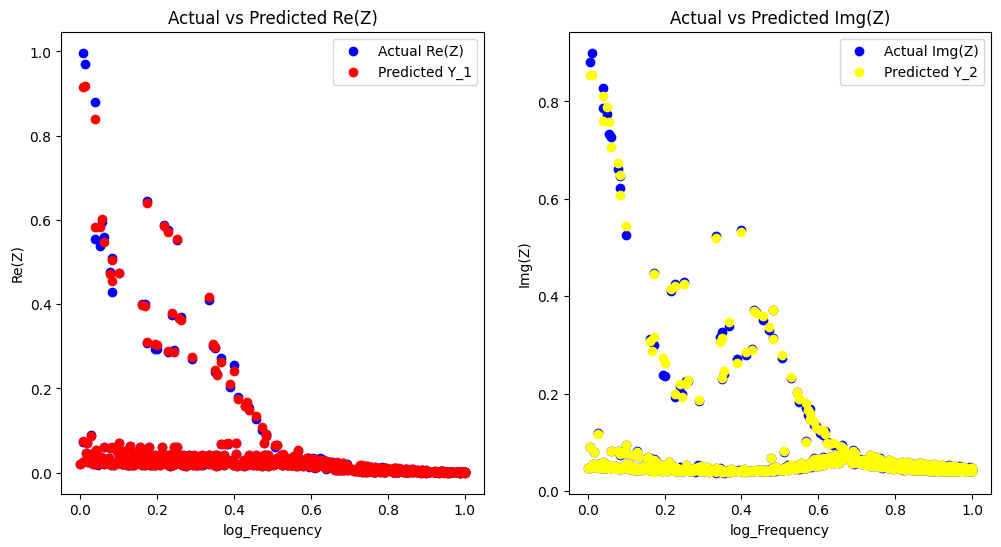

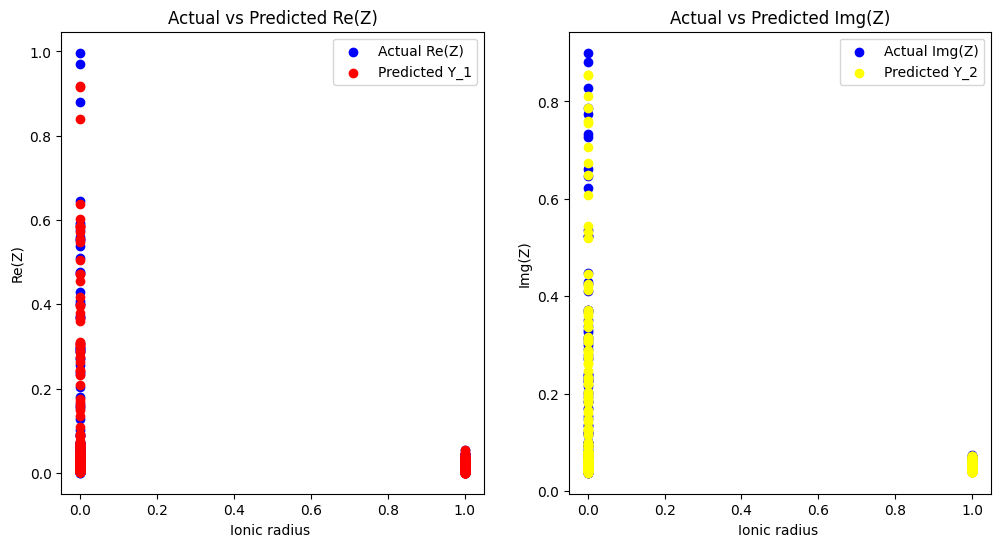

In [106]:
#Plotting predictions on validation data
y_val_pred_rfr=pd.DataFrame(y_val_pred_rfr,columns=['Re(Z)','Img(Z)'])
plot_pred(y_val_pred_rfr)

##### Applying Hyperparameter tuning techniques

In [107]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [108]:
grid_rfr = {
    'n_estimators': [300,500,1000],
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [1,5,10],
    'bootstrap': [True,False]
}
grid=GridSearchCV(RandomForestRegressor(random_state=42),grid_rfr,cv=3,n_jobs=-1)
grid.fit(X_train_df,Y_train_df)
best_grid=grid.best_estimator_
print('Best Parameters: ',grid.best_params_)
print('Best Score: ',grid.best_score_)


Best Parameters:  {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best Score:  0.9963120920072049


In [109]:
grid_rfr2={'n_estimators':[500],
          'random_state':[42],
          'max_depth':[10,20,30,None]
          }
grid2=GridSearchCV(RandomForestRegressor(),grid_rfr2,cv=3,n_jobs=-1)
grid2.fit(X_train_df,Y_train_df)
best_grid2=grid2.best_estimator_
print('Best Parameters: ',grid2.best_params_)
print('Best Score: ',grid2.best_score_)

Best Parameters:  {'max_depth': 30, 'n_estimators': 500, 'random_state': 42}
Best Score:  0.9963089559277862


In [110]:
grid_rfr3={'n_estimators':[500],
           'max_depth':[30],
           'random_state':[42]
          }
grid3=GridSearchCV(RandomForestRegressor(),grid_rfr3,cv=3,n_jobs=-1)
grid3.fit(X_train_df,Y_train_df)
best_grid3=grid3.best_estimator_
print('Best Parameters: ',grid3.best_params_)
print('Best Score: ',grid3.best_score_)

Best Parameters:  {'max_depth': 30, 'n_estimators': 500, 'random_state': 42}
Best Score:  0.9963089559277862


In [111]:
#prediction on train data
print("Prediction on train data")
best_accuracy_train=predict_(best_grid3,X_train_df,Y_train_df)
print("\n")
#prediction on validation data
print("Prediction on val data")
best_accuracy_val = predict_(best_grid3,X_val_df,Y_val_df)

Prediction on train data
MAE 0.0005185590593296327
MSE 5.200035061482932e-06
RMSE 0.0022803585379240106
R2 score 0.9995936233692557
MAPE score 16629211241.906628


Prediction on val data
MAE 0.0011876294813288621
MSE 1.9861544861511437e-05
RMSE 0.004456629316143697
R2 score 0.9985756324163746
MAPE score 0.01897139596613168


##### Result on test data

In [112]:
#base model prediction on test data
print("Base model Prediction on test data")
y_test_pred_rfr = predict_(rfr,X_test_df,Y_test_df)
print("\n")
#Tuned model prediction on test data
print("Tuned model Prediction on test data")
best_accuracy_test = predict_(best_grid3,X_test_df,Y_test_df)

Base model Prediction on test data
MAE 0.0015453486844003695
MSE 5.401188952723674e-05
RMSE 0.007349278163686332
R2 score 0.9972525548675936
MAPE score 0.021832704642363282


Tuned model Prediction on test data
MAE 0.0014883910513550109
MSE 4.9244905710882864e-05
RMSE 0.007017471461351507
R2 score 0.9974857583716283
MAPE score 0.021543684033548484


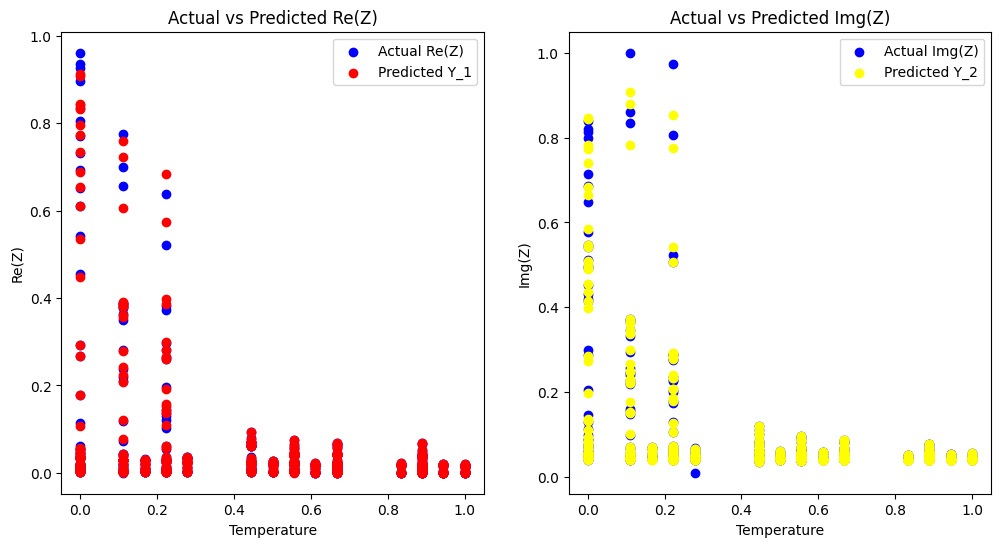

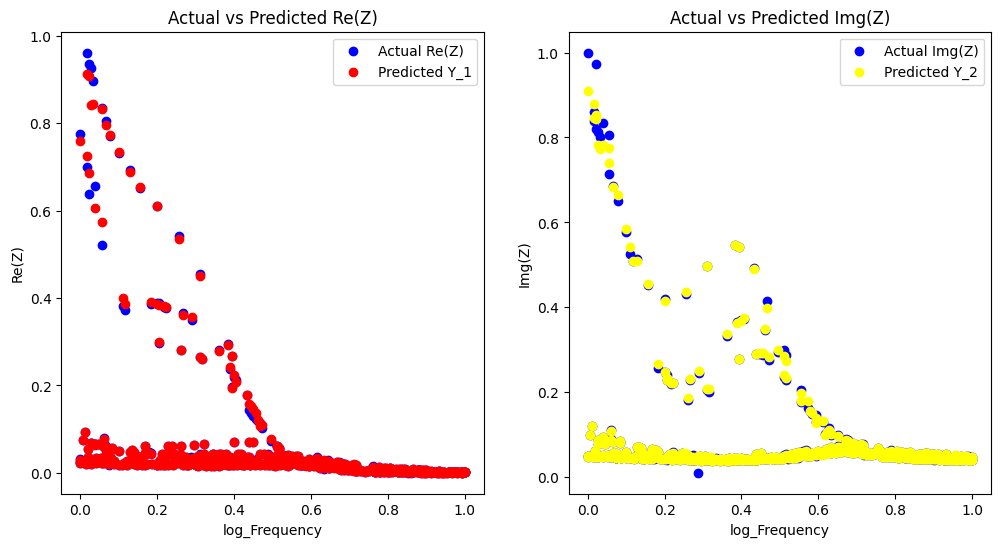

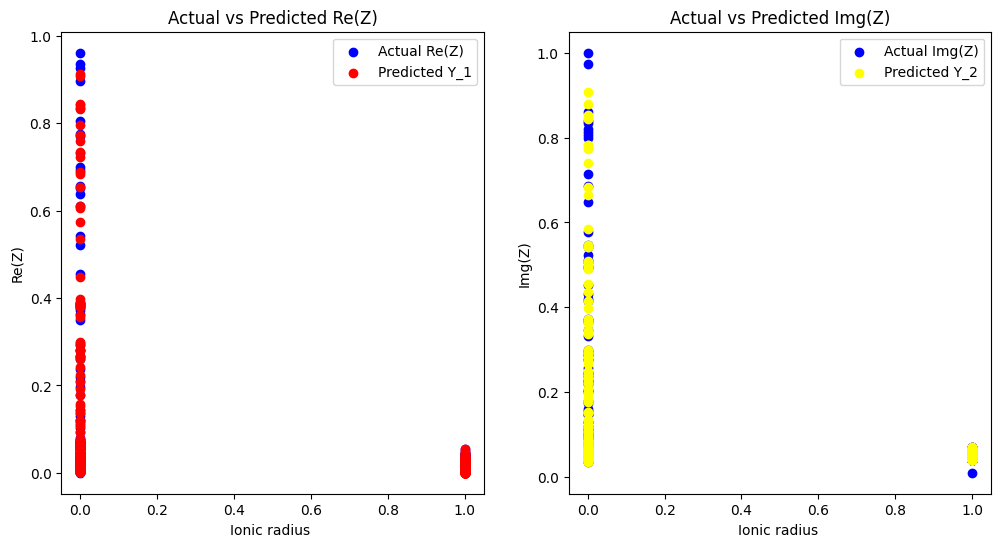

In [113]:
#Plotting base model predictions on test data
y_test_pred_rfr=pd.DataFrame(y_test_pred_rfr,columns=['Re(Z)','Img(Z)'])
plot_pred_test(y_test_pred_rfr)

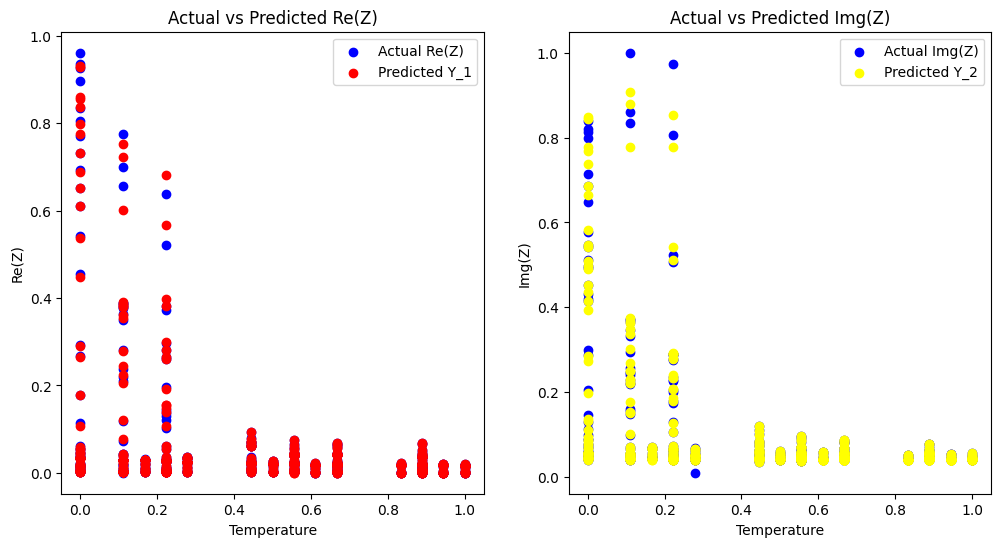

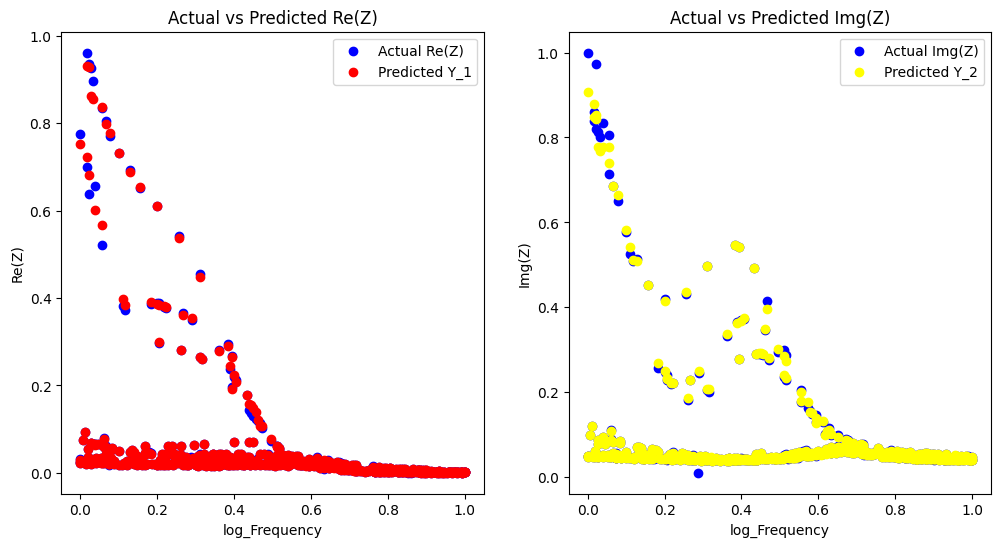

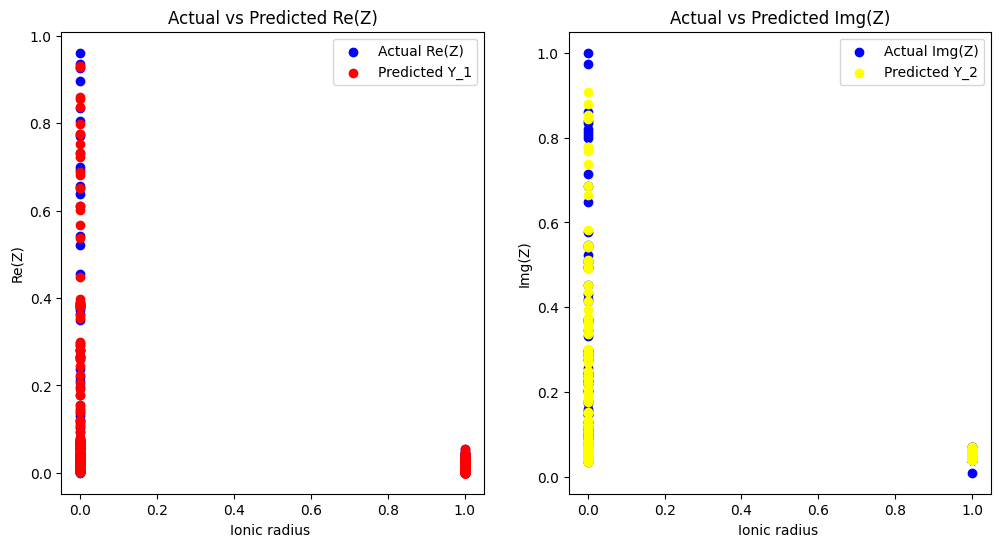

In [114]:
#Plotting tuned model predictions on test data
best_accuracy_test=pd.DataFrame(best_accuracy_test,columns=['Re(Z)','Img(Z)'])
plot_pred_test(best_accuracy_test)

## Testing on new data

###Preparing the test data


In [115]:
test_data = df[df['Temperature'].isin(drop_temp)]
test_data=pd.DataFrame(test_data,columns=['Ionic radius ', 'Temperature',	'Frequency','Re(Z)','Img(Z)'])
print(test_data)
print(test_data['Temperature'].unique())
X_actual=test_data.iloc[:,0:3]
X_actual=pd.DataFrame(X_actual,columns=['Ionic radius ', 'Temperature',	'Frequency'])
Y_actual=test_data.iloc[:,3:]
Y_actual=pd.DataFrame(Y_actual,columns=['Re(Z)','Img(Z)'])
X_actual.to_csv('X_actual.csv',index=False)

      Ionic radius   Temperature   Frequency    Re(Z)   Img(Z)
543    1.820000e-10           20  1000000.00   3380.0  12000.0
544    1.820000e-10           20   926000.00   3870.0  12800.0
545    1.820000e-10           20   858000.00   4390.0  13500.0
546    1.820000e-10           20   794000.00   4950.0  14200.0
547    1.820000e-10           20   736000.00   5430.0  14800.0
...             ...          ...         ...      ...      ...
4039   2.060000e-10           60        1.45  79200.0  13500.0
4040   2.060000e-10           60        1.32  80200.0  13700.0
4041   2.060000e-10           60        1.20  81100.0  14100.0
4042   2.060000e-10           60        1.10  82200.0  14400.0
4043   2.060000e-10           60        1.00  83200.0  14700.0

[1117 rows x 5 columns]
[20 60 -5 25 55]


In [116]:
print(X_actual)
print(X_actual['Temperature'].unique())

      Ionic radius   Temperature   Frequency
543    1.820000e-10           20  1000000.00
544    1.820000e-10           20   926000.00
545    1.820000e-10           20   858000.00
546    1.820000e-10           20   794000.00
547    1.820000e-10           20   736000.00
...             ...          ...         ...
4039   2.060000e-10           60        1.45
4040   2.060000e-10           60        1.32
4041   2.060000e-10           60        1.20
4042   2.060000e-10           60        1.10
4043   2.060000e-10           60        1.00

[1117 rows x 3 columns]
[20 60 -5 25 55]


In [117]:
#applying log transform on new test data
test_data= trf.transform(test_data)
test_data=pd.DataFrame(test_data,columns=['log_Frequency','Ionic radius ','Temperature','Re(Z)','Img(Z)'])
print(test_data)

      log_Frequency  Ionic radius   Temperature    Re(Z)   Img(Z)
0         13.815511   1.820000e-10         20.0   3380.0  12000.0
1         13.738630   1.820000e-10         20.0   3870.0  12800.0
2         13.662359   1.820000e-10         20.0   4390.0  13500.0
3         13.584839   1.820000e-10         20.0   4950.0  14200.0
4         13.508985   1.820000e-10         20.0   5430.0  14800.0
...             ...            ...          ...      ...      ...
1112       0.371564   2.060000e-10         60.0  79200.0  13500.0
1113       0.277632   2.060000e-10         60.0  80200.0  13700.0
1114       0.182322   2.060000e-10         60.0  81100.0  14100.0
1115       0.095310   2.060000e-10         60.0  82200.0  14400.0
1116       0.000000   2.060000e-10         60.0  83200.0  14700.0

[1117 rows x 5 columns]


In [118]:
#applying MinMax scaling on new test X data
test_data=MinMax_scaler.transform(test_data)
test_data=pd.DataFrame(test_data,columns=['log_Frequency','Ionic radius ','Temperature','Re(Z)','Img(Z)'])
print(test_data)

      log_Frequency  Ionic radius   Temperature     Re(Z)    Img(Z)
0          1.000000            0.0     0.333333  0.000603  0.047683
1          0.994435            0.0     0.333333  0.000747  0.048216
2          0.988915            0.0     0.333333  0.000900  0.048683
3          0.983303            0.0     0.333333  0.001065  0.049150
4          0.977813            0.0     0.333333  0.001206  0.049550
...             ...            ...          ...       ...       ...
1112       0.026895            1.0     0.777778  0.022912  0.048683
1113       0.020096            1.0     0.777778  0.023206  0.048816
1114       0.013197            1.0     0.777778  0.023471  0.049083
1115       0.006899            1.0     0.777778  0.023795  0.049283
1116       0.000000            1.0     0.777778  0.024089  0.049483

[1117 rows x 5 columns]


In [119]:
new_test_X=test_data.iloc[:,0:3]
new_test_X=pd.DataFrame(new_test_X,columns=['log_Frequency','Ionic radius ','Temperature'])
new_test_y=test_data.iloc[:,3:]
new_test_y=pd.DataFrame(new_test_y,columns=['Re(Z)','Img(Z)'])
print(new_test_X)
print(new_test_y)

      log_Frequency  Ionic radius   Temperature
0          1.000000            0.0     0.333333
1          0.994435            0.0     0.333333
2          0.988915            0.0     0.333333
3          0.983303            0.0     0.333333
4          0.977813            0.0     0.333333
...             ...            ...          ...
1112       0.026895            1.0     0.777778
1113       0.020096            1.0     0.777778
1114       0.013197            1.0     0.777778
1115       0.006899            1.0     0.777778
1116       0.000000            1.0     0.777778

[1117 rows x 3 columns]
         Re(Z)    Img(Z)
0     0.000603  0.047683
1     0.000747  0.048216
2     0.000900  0.048683
3     0.001065  0.049150
4     0.001206  0.049550
...        ...       ...
1112  0.022912  0.048683
1113  0.023206  0.048816
1114  0.023471  0.049083
1115  0.023795  0.049283
1116  0.024089  0.049483

[1117 rows x 2 columns]


###Prediction results using new test data

#####Functions

In [120]:
def plot_Re_vs_img(pred_):
  unique_temp=df['Temperature'].unique()

  for i in drop_temp:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=Y_actual.reset_index(drop=True)['Re(Z)'][X_actual.reset_index(drop=True)['Temperature']==i],y=Y_actual.reset_index(drop=True)['Img(Z)'][X_actual.reset_index(drop=True)['Temperature']==i],label="Actual (T= "+str(i)+" degrees)")
    sns.scatterplot(x=pred_.reset_index(drop=True)['Re(Z)'][X_actual.reset_index(drop=True)['Temperature']==i],y=pred_.reset_index(drop=True)['Img(Z)'][X_actual.reset_index(drop=True)['Temperature']==i], label="Predicted (T= "+str(i)+" degrees)")
    plt.title('Actual vs Predicted Values - Output')
    plt.xlabel('Re(Z)')
    plt.ylabel('Img(Z)')
    plt.legend()

In [121]:
def plot_prediction_test(pred_):

  x_columns=['Temperature','Frequency','Ionic radius ']
  for i in x_columns:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(X_actual[i], Y_actual['Re(Z)'], color='blue', label='Actual Re(Z)')
    plt.scatter(X_actual[i], pred_['Re(Z)'], color='red', label='Predicted Re(Z)')
    plt.xlabel(i)
    plt.ylabel('Re(Z)')
    plt.title('Actual vs Predicted Re(Z)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_actual[i], Y_actual['Img(Z)'], color='blue', label='Actual Img(Z)')
    plt.scatter(X_actual[i], pred_['Img(Z)'], color='yellow', label='Predicted Img(Z)')
    plt.xlabel(i)
    plt.ylabel('Img(Z)')
    plt.title('Actual vs Predicted Img(Z)')
    plt.legend()

    plt.show()

##### Gradient boosting

In [122]:
# Gradient boosting algorithm with hyperparameter tuning
new_test_pred_gb=predict_(best_grid_gbr3,new_test_X,new_test_y)
new_test_pred_gb=pd.DataFrame(new_test_pred_gb,columns=['Re(Z)','Img(Z)'])

MAE 0.001389697585289919
MSE 7.461924195366683e-06
RMSE 0.0027316522830270113
R2 score 0.967452014591887
MAPE score 0.05963073519059805


In [123]:
y_actual_gb=MinMax_scaler.inverse_transform(pd.concat([new_test_X,new_test_pred_gb],axis=1))[:,3:]
y_actual_gb=pd.DataFrame(y_actual_gb,columns=['Re(Z)','Img(Z)'])
print(y_actual_gb)

             Re(Z)        Img(Z)
0      8154.504192  18598.977576
1      8154.504192  18598.977576
2      8285.365982  18598.977576
3      8285.365982  18700.206883
4      8626.382923  19335.466538
...            ...           ...
1112  78105.190450  12784.970029
1113  78665.293206  12784.970029
1114  80093.455807  13367.011265
1115  80688.309403  13202.864829
1116  81901.116431  13665.711454

[1117 rows x 2 columns]


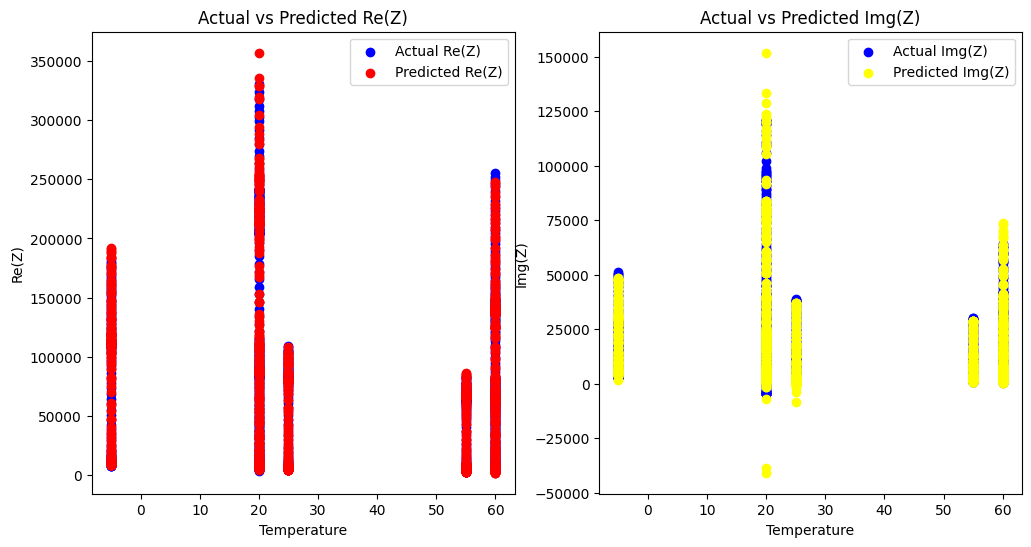

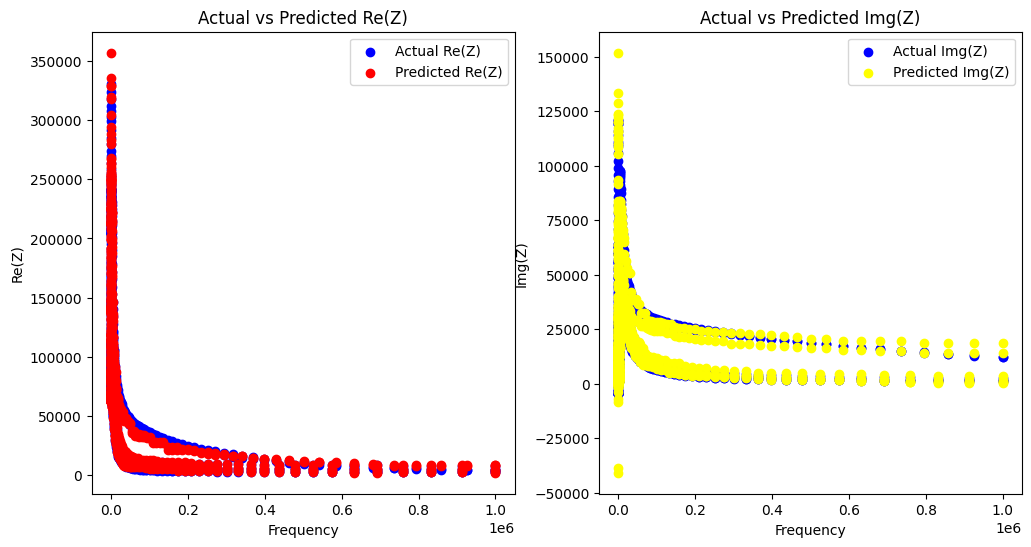

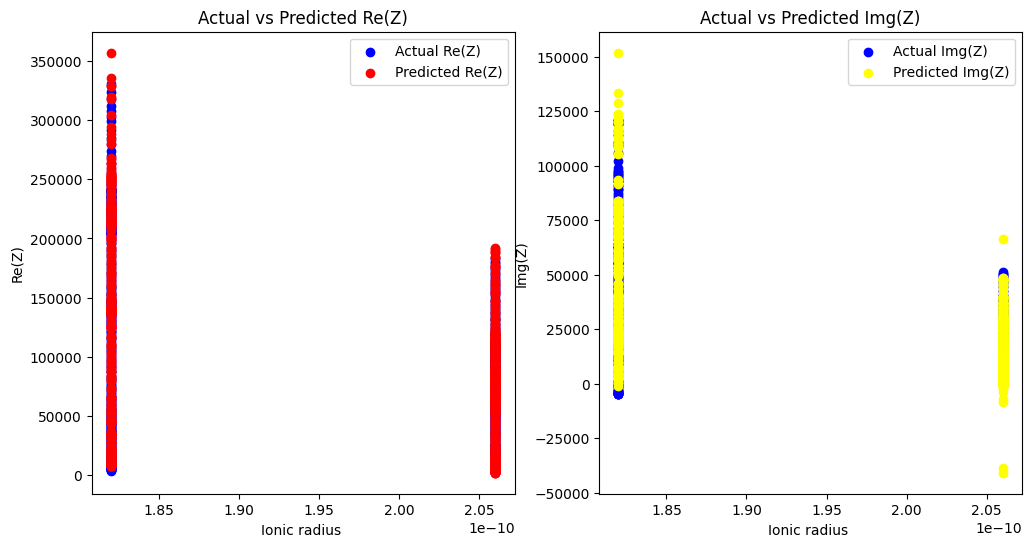

In [124]:
plot_prediction_test(y_actual_gb)

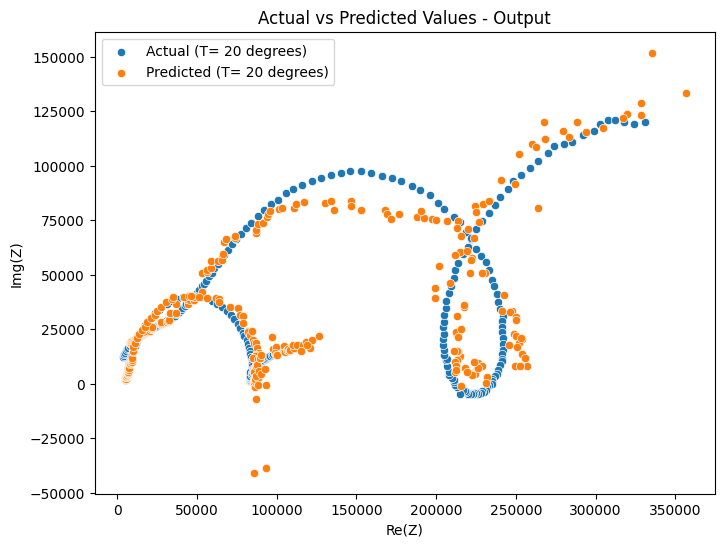

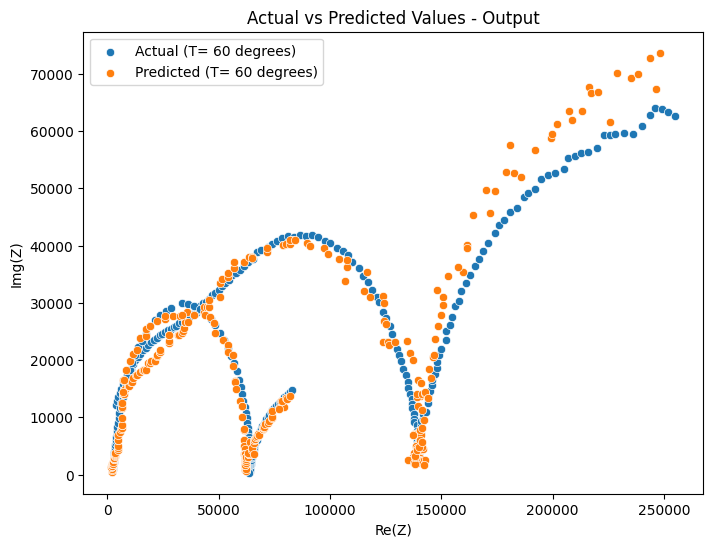

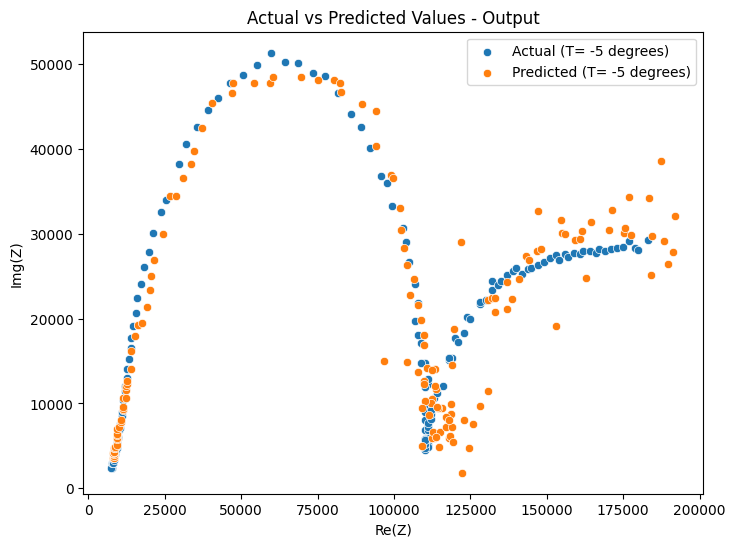

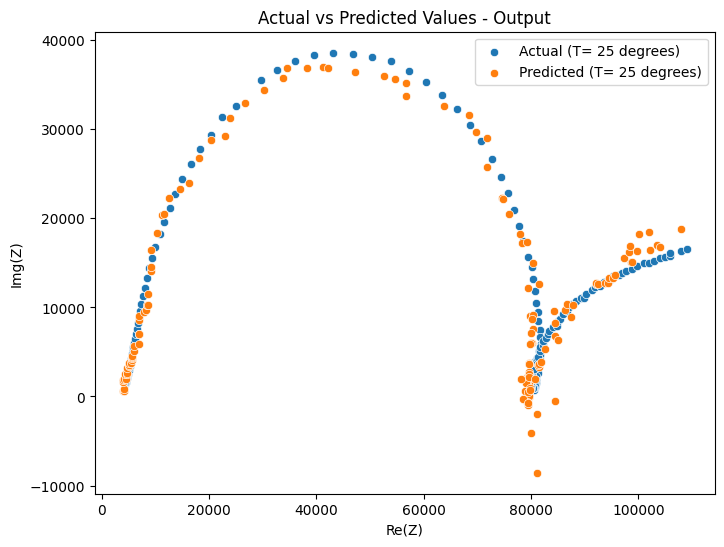

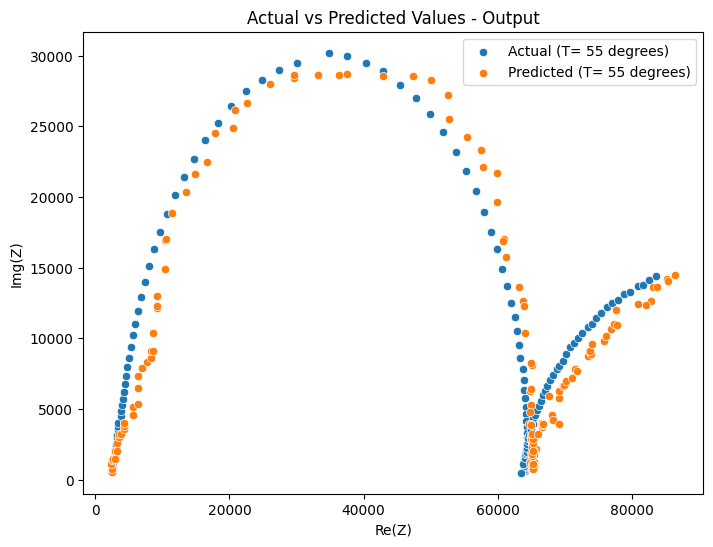

In [125]:
plot_Re_vs_img(y_actual_gb)

#####XGBoost

In [126]:
# XGBoost algorithm with hyperparameter tuning
new_test_pred_xgbr= predict_(best_grid_xgbr5,new_test_X,new_test_y)
new_test_pred_xgbr=pd.DataFrame(new_test_pred_xgbr,columns=['Re(Z)','Img(Z)'])

MAE 0.0010793255432845796
MSE 4.7026121089717255e-06
RMSE 0.0021685506931985073
R2 score 0.9811305266407276
MAPE score 0.04430172577782368


In [127]:
y_actual_xgbr=MinMax_scaler.inverse_transform(pd.concat([new_test_X,new_test_pred_gb],axis=1))[:,3:]
y_actual_xgbr=pd.DataFrame(y_actual_xgbr,columns=['Re(Z)','Img(Z)'])
print(y_actual_xgbr)

             Re(Z)        Img(Z)
0      8154.504192  18598.977576
1      8154.504192  18598.977576
2      8285.365982  18598.977576
3      8285.365982  18700.206883
4      8626.382923  19335.466538
...            ...           ...
1112  78105.190450  12784.970029
1113  78665.293206  12784.970029
1114  80093.455807  13367.011265
1115  80688.309403  13202.864829
1116  81901.116431  13665.711454

[1117 rows x 2 columns]


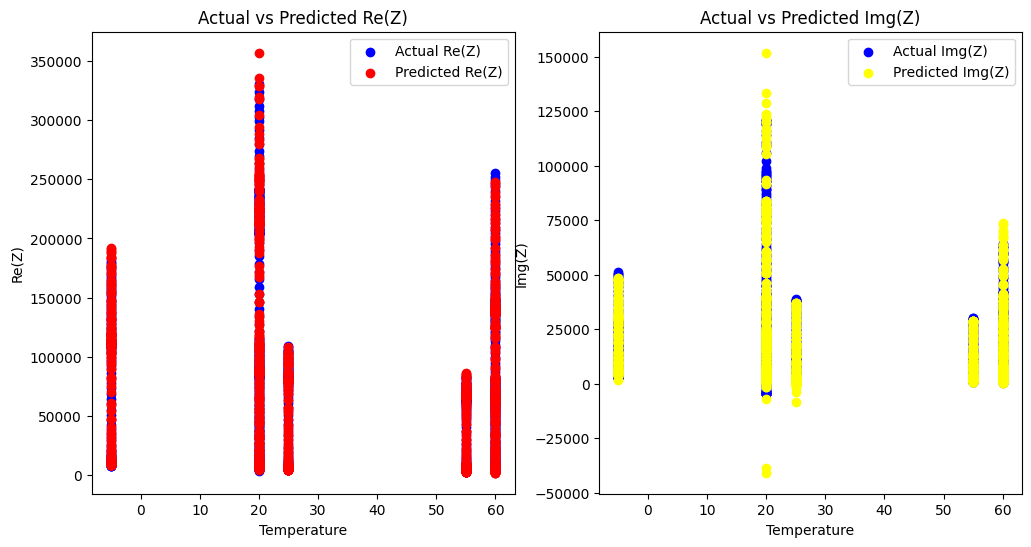

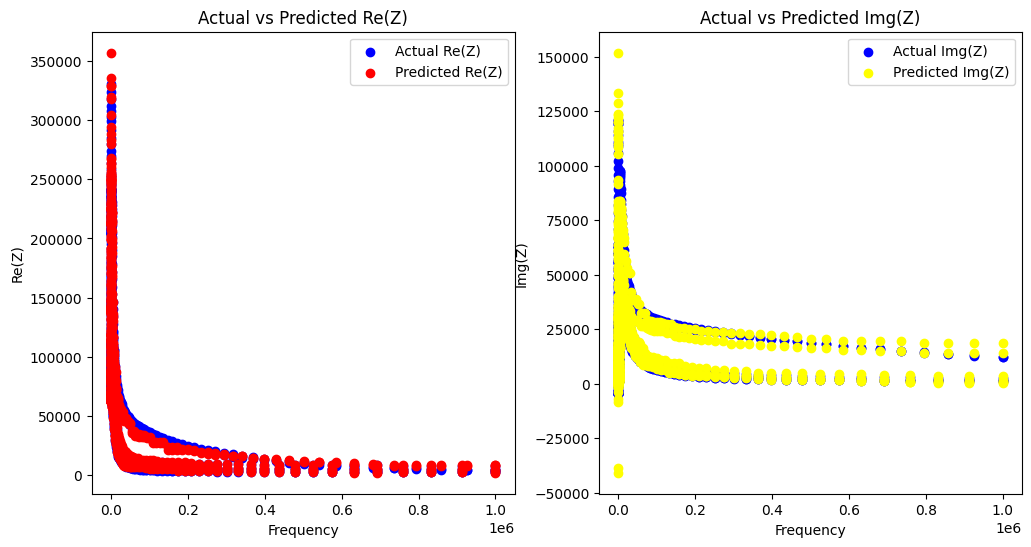

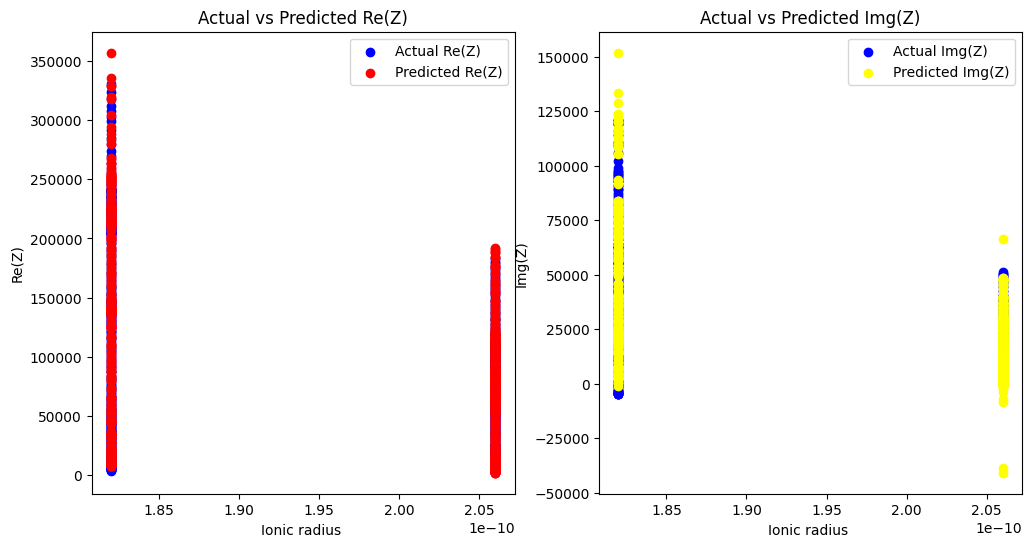

In [128]:
plot_prediction_test(y_actual_xgbr)

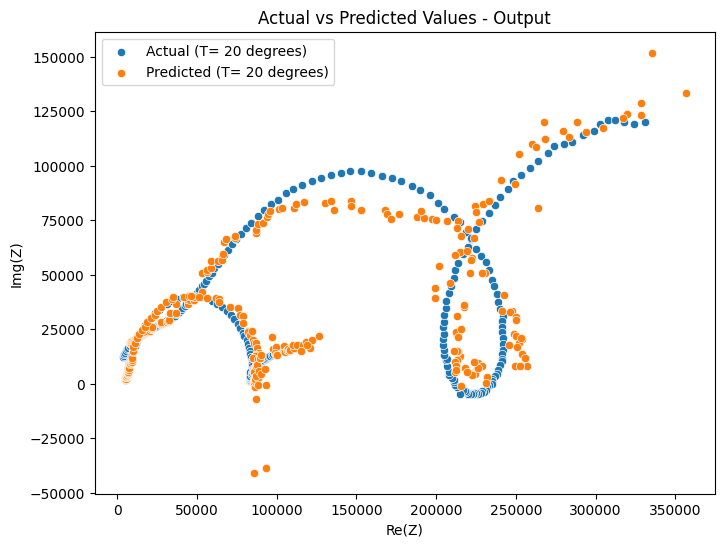

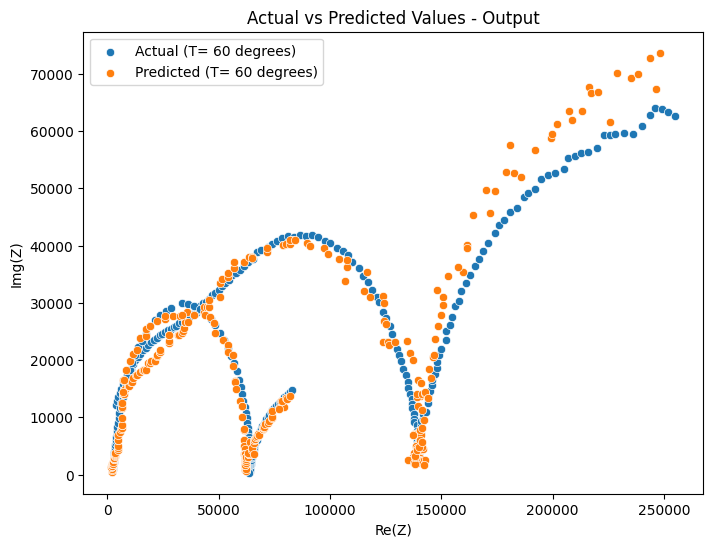

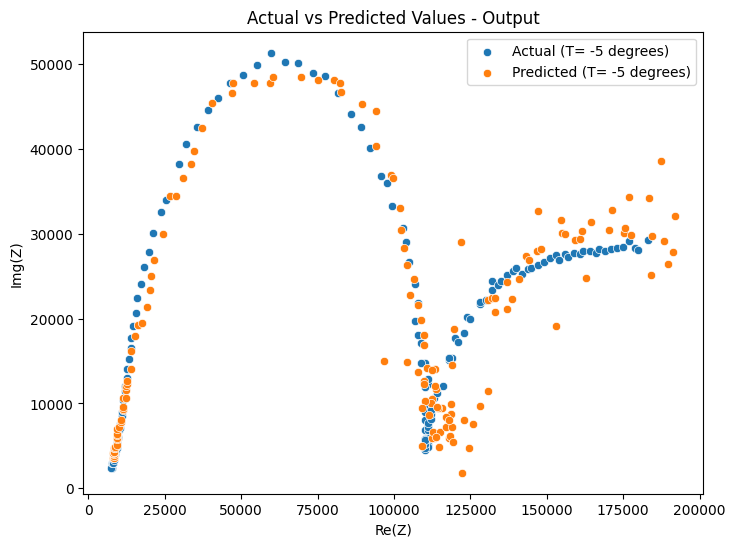

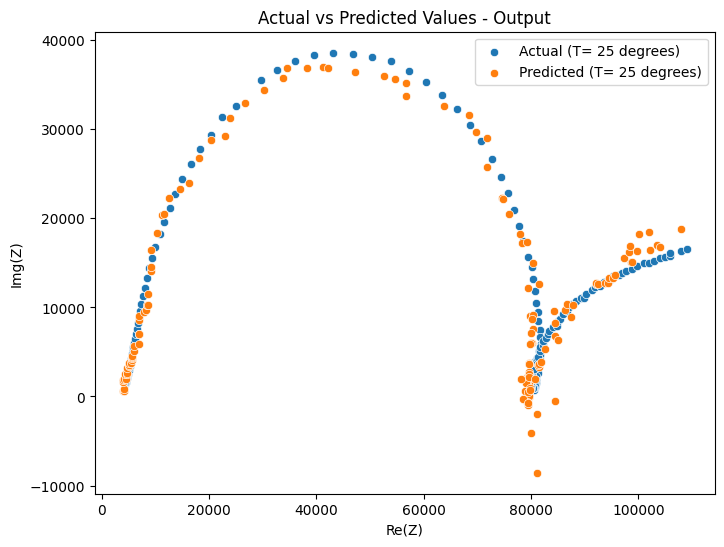

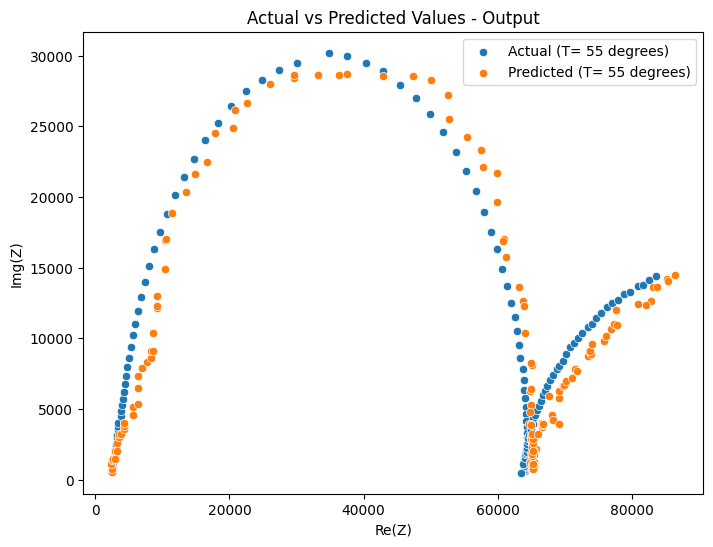

In [129]:
plot_Re_vs_img(y_actual_xgbr)

####Random Forest

In [130]:
# Random forest algorithm with hyperparameter tuning
new_test_pred_rf= predict_(best_grid3,new_test_X,new_test_y)
new_test_pred_rf=pd.DataFrame(new_test_pred_rf,columns=['Re(Z)','Img(Z)'])

MAE 0.0008181934945896012
MSE 2.7674423003706274e-06
RMSE 0.0016635631338697751
R2 score 0.9883484136537227
MAPE score 0.039028098127462135


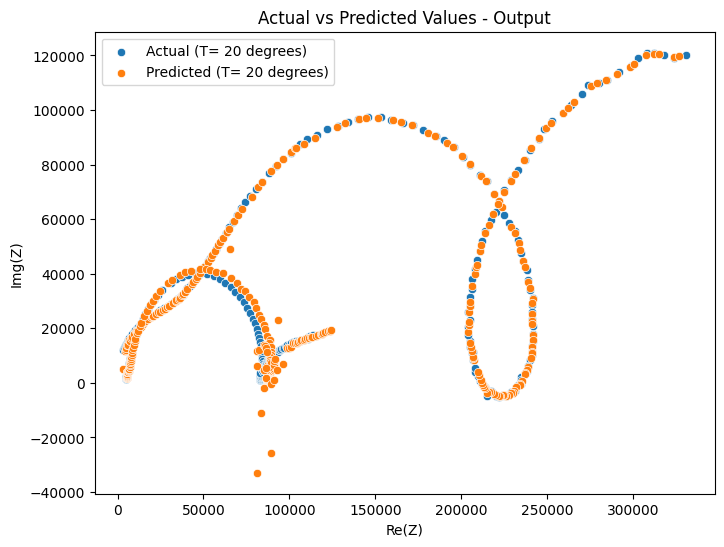

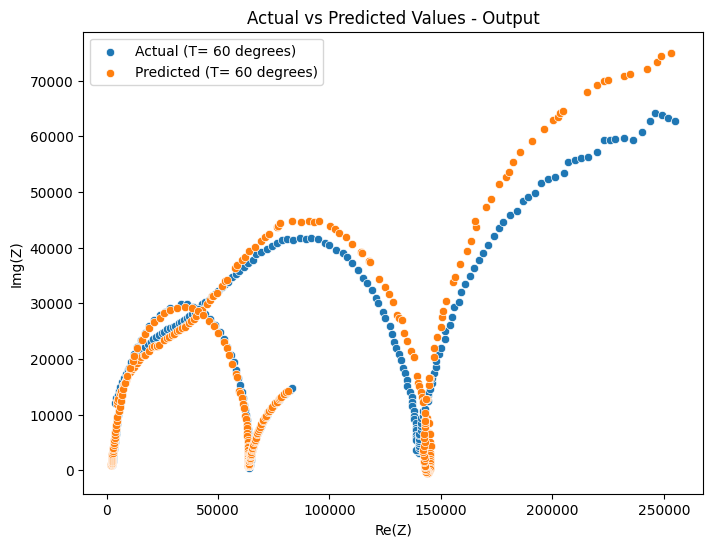

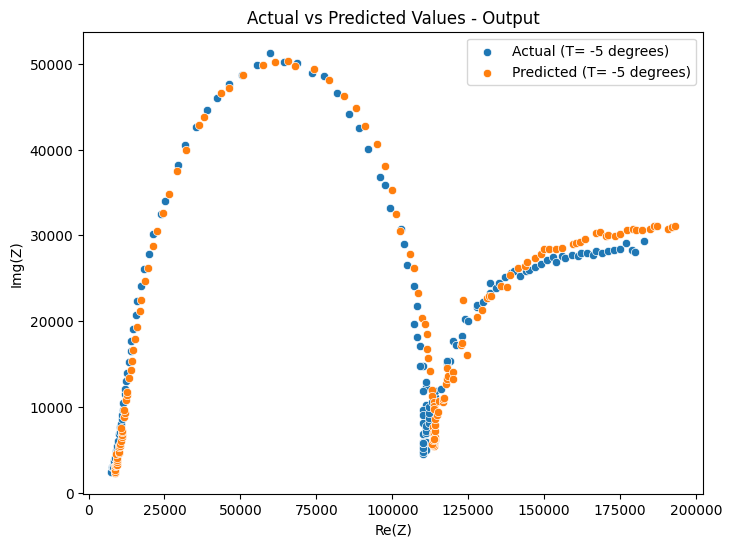

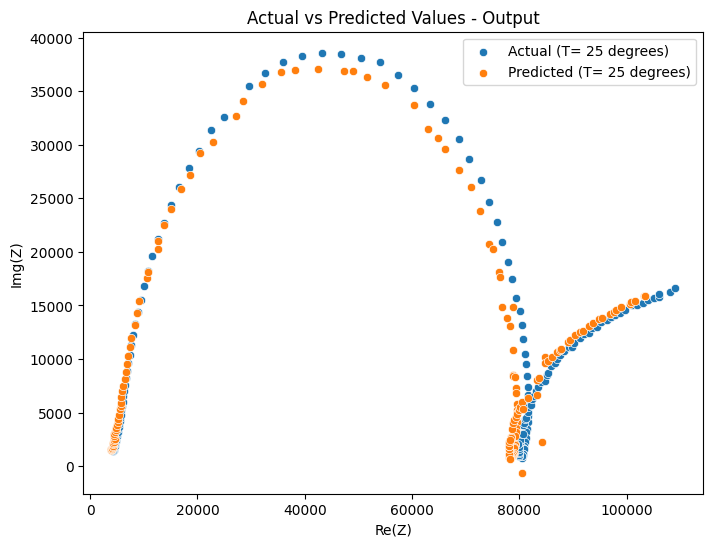

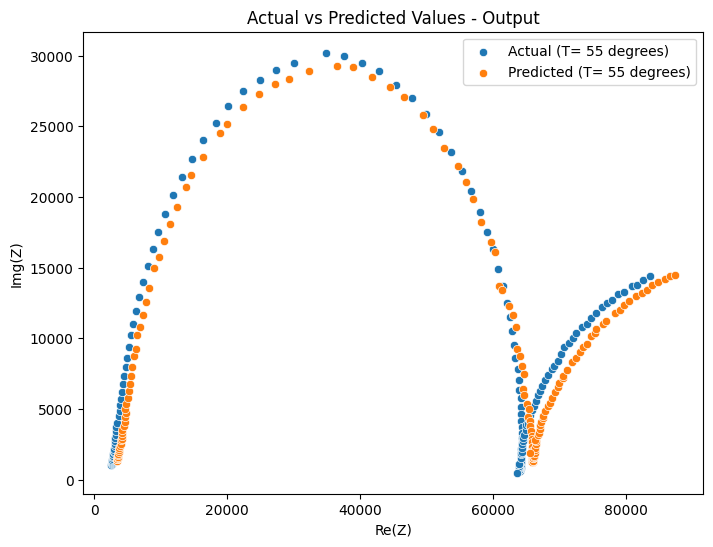

In [131]:
y_actual_rf=MinMax_scaler.inverse_transform(pd.concat([new_test_X,new_test_pred_rf],axis=1))[:,3:]
y_actual_rf=pd.DataFrame(y_actual_rf,columns=['Re(Z)','Img(Z)'])
plot_Re_vs_img(y_actual_rf)

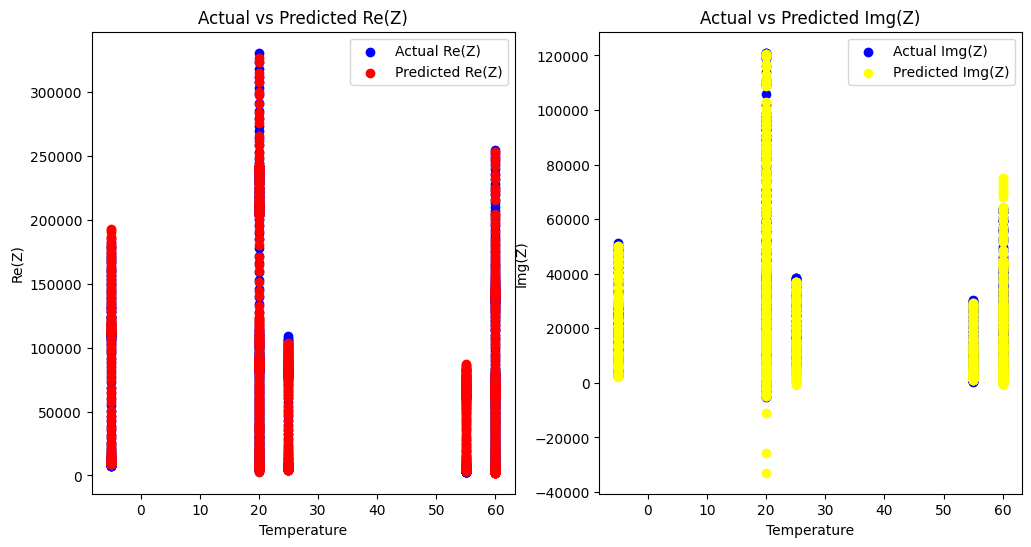

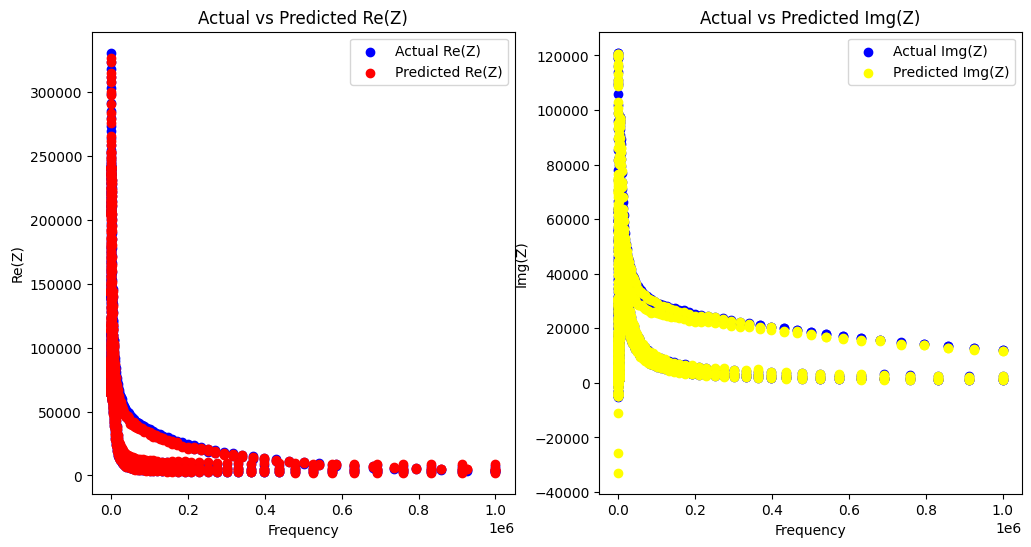

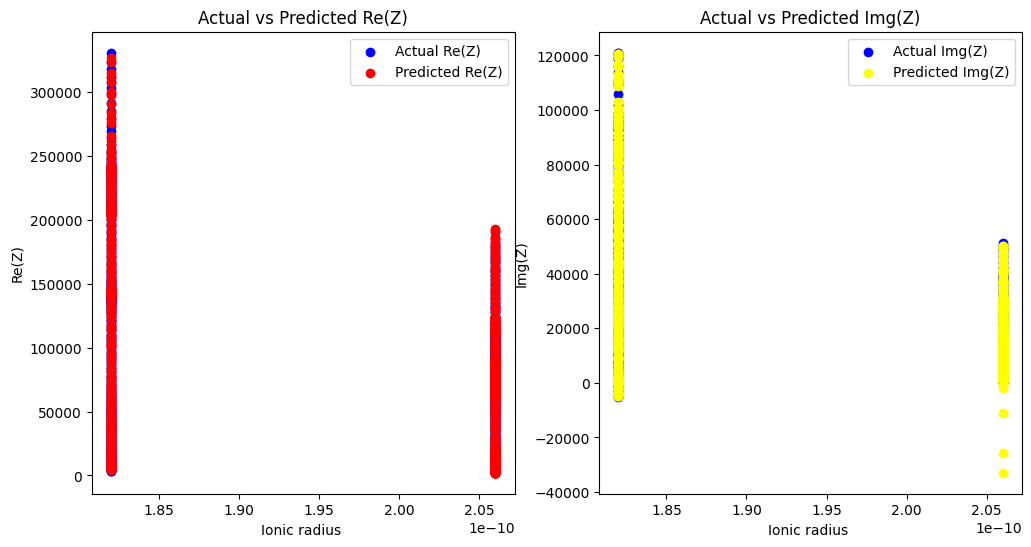

In [132]:
plot_prediction_test(y_actual_rf)

#### Combining and new file for fitting

In [133]:
# make a copy of X_actual in dfcombine and reset the index
dfcombineX = X_actual.copy()
dfcombineX.reset_index(drop=True, inplace=True)
dfcombineX.info()
dfcombineX
#check data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ionic radius   1117 non-null   float64
 1   Temperature    1117 non-null   int64  
 2   Frequency      1117 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 26.3 KB


Ionic radius   Temperature   Frequency
0      1.820000e-10           20  1000000.00
1      1.820000e-10           20   926000.00
2      1.820000e-10           20   858000.00
3      1.820000e-10           20   794000.00
4      1.820000e-10           20   736000.00
...             ...          ...         ...
1112   2.060000e-10           60        1.45
1113   2.060000e-10           60        1.32
1114   2.060000e-10           60        1.20
1115   2.060000e-10           60        1.10
1116   2.060000e-10           60        1.00

[1117 rows x 3 columns]

In [134]:
# make a copy of y_actual_rf in dfcombineY and reset the index
dfcombineY = y_actual_rf.copy()
dfcombineY.reset_index(drop=True, inplace=True)
dfcombineY.info()
dfcombineY

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Re(Z)   1117 non-null   float64
 1   Img(Z)  1117 non-null   float64
dtypes: float64(2)
memory usage: 17.6 KB


Re(Z)   Img(Z)
0      4565.28  11632.2
1      4812.94  12171.4
2      4751.84  12946.8
3      5424.64  13942.4
4      6048.54  13825.2
...        ...      ...
1112  77949.80  13051.8
1113  78323.20  13223.2
1114  79726.00  13781.6
1115  80501.00  14002.6
1116  81315.40  14279.4

[1117 rows x 2 columns]

In [135]:
#combine both dfcombineX and dfcombineY to dfcombine dataframe
dfcombine = pd.concat([dfcombineX, dfcombineY], axis=1)
dfcombine
#save file 'predicted data for fitting'
dfcombine.to_csv('predicted_data_for_fitting.csv',index=False)

# Model Fitting

## 60-1

frequencies: [1.00e+06 9.26e+05 8.58e+05 7.94e+05 7.36e+05 6.81e+05 6.31e+05 5.84e+05
 5.41e+05 5.01e+05 4.64e+05 4.30e+05 3.98e+05 3.69e+05 3.41e+05 3.16e+05
 2.93e+05 2.71e+05 2.51e+05 2.33e+05 2.15e+05 2.00e+05 1.85e+05 1.71e+05
 1.58e+05 1.47e+05 1.36e+05 1.26e+05 1.17e+05 1.08e+05 1.00e+05 9.26e+04
 8.58e+04 7.94e+04 7.36e+04 6.81e+04 6.31e+04 5.84e+04 5.41e+04 5.01e+04
 4.64e+04 4.30e+04 3.98e+04 3.69e+04 3.41e+04 3.16e+04 2.93e+04 2.71e+04
 2.51e+04 2.33e+04 2.15e+04 1.99e+04 1.85e+04 1.71e+04 1.58e+04 1.47e+04
 1.36e+04 1.26e+04 1.17e+04 1.08e+04 1.00e+04 9.26e+03 8.57e+03 7.94e+03
 7.35e+03 6.81e+03 6.31e+03 5.84e+03 5.41e+03 5.01e+03 4.64e+03 4.30e+03
 3.98e+03 3.69e+03 3.42e+03 3.16e+03 2.93e+03 2.71e+03 2.51e+03 2.33e+03
 2.15e+03 2.00e+03 1.85e+03 1.71e+03 1.58e+03 1.47e+03 1.36e+03 1.26e+03
 1.17e+03 1.08e+03 1.00e+03 9.26e+02 8.58e+02 7.94e+02 7.36e+02 6.81e+02
 6.31e+02 5.84e+02 5.41e+02 5.01e+02 4.64e+02 4.30e+02 3.98e+02 3.69e+02
 3.41e+02 3.16e+02 2.93e+02 2.71e+02 2

/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


<Figure size 2000x600 with 0 Axes>

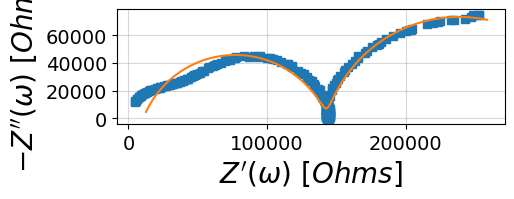


Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 4.08e+01 [Ohm]
    R_1 = 5.10e+04 [Ohm]
  CPE_1_0 = 1.34e-09 [Ohm^-1 sec^a]
  CPE_1_1 = 7.20e-01 []
    R_2 = 9.51e+03 [Ohm]
  CPE_2_0 = 1.37e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.21e-01 []

Fit parameters:
    R_0 = 1.07e+04  (+/- 4.63e+02) [Ohm]
    R_1 = 1.32e+05  (+/- 2.86e+02) [Ohm]
  CPE_1_0 = 1.12e-09  (+/- 1.69e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 7.70e-01  (+/- 1.74e-03) []
    R_2 = 1.91e+05  (+/- 2.07e+01) [Ohm]
  CPE_2_0 = 8.68e-07  (+/- 2.32e-08) [Ohm^-1 sec^a]
  CPE_2_1 = 8.32e-01  (+/- 8.78e-03) []

      Re(Z)_fit   Img(Z)_fit
0  12714.674550  4727.025037
1  12844.711608  5006.064361
2  12982.594520  5298.531410
3  13132.474642  5612.581741
4  13289.339533  5937.085870


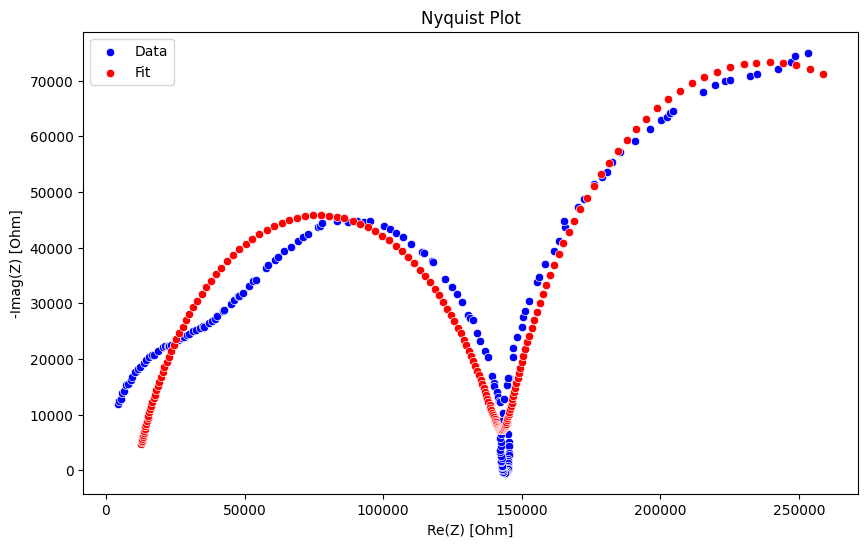

Circuit Type 1

Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 4.08e+01 [Ohm]
    R_1 = 5.10e+04 [Ohm]
  CPE_1_0 = 1.34e-09 [Ohm^-1 sec^a]
  CPE_1_1 = 7.20e-01 []
    R_2 = 9.51e+03 [Ohm]
  CPE_2_0 = 1.37e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.21e-01 []

Fit parameters:
    R_0 = 1.07e+04  (+/- 4.63e+02) [Ohm]
    R_1 = 1.32e+05  (+/- 2.86e+02) [Ohm]
  CPE_1_0 = 1.12e-09  (+/- 1.69e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 7.70e-01  (+/- 1.74e-03) []
    R_2 = 1.91e+05  (+/- 2.07e+01) [Ohm]
  CPE_2_0 = 8.68e-07  (+/- 2.32e-08) [Ohm^-1 sec^a]
  CPE_2_1 = 8.32e-01  (+/- 8.78e-03) []



In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import seaborn as sns

# Load and process the input data
df = pd.read_csv('predicted_data_for_fitting.csv')

# Filter and drop specific columns
# df = df[df['Ionic radius '] == 2.060000e-10]
df = df[df['Ionic radius '] == 1.820000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == 60]
df = df.drop(columns=['Temperature'])
df = df.reset_index(drop=True)

# Rename columns and adjust values
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
df['Img(Z)'] = df['Img(Z)'] * -1
df.to_csv('temp/60(1).csv', index=False)

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('temp/60(1).csv')

# Remove NaN values
mask = ~np.isnan(Z)
frequencies, Z = frequencies[mask], Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    plt.figure(figsize=(20, 6))
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Initial guess for the circuit parameters
initial_guess=[4.08127359e+01,  5.10336218e+04, 1.33749422e-09, 7.20182283e-01, 0.95110848e+04, 1.37210091e-06, 9.20690396e-01]
# Circuit string
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'

# Fit and plot the circuit
customCircuit = fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Save the DataFrames to CSV
Z_df.to_csv('temp/Z60(1).csv', index=False)
Z_fit_df.to_csv('temp/Z_fit60(1).csv', index=False)

# Load data for plotting
plot_data = pd.read_csv('temp/Z60(1).csv')
plot_data_fit = pd.read_csv('temp/Z_fit60(1).csv')

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.scatterplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', 1)
print(customCircuit)

## 60-2

frequencies: [1.00e+06 9.12e+05 8.32e+05 7.59e+05 6.92e+05 6.31e+05 5.75e+05 5.25e+05
 4.79e+05 4.37e+05 3.98e+05 3.63e+05 3.31e+05 3.02e+05 2.75e+05 2.51e+05
 2.29e+05 2.09e+05 1.91e+05 1.74e+05 1.58e+05 1.45e+05 1.32e+05 1.20e+05
 1.10e+05 1.00e+05 9.12e+04 8.32e+04 7.59e+04 6.92e+04 6.31e+04 5.75e+04
 5.25e+04 4.79e+04 4.37e+04 3.98e+04 3.63e+04 3.31e+04 3.02e+04 2.75e+04
 2.51e+04 2.29e+04 2.09e+04 1.91e+04 1.74e+04 1.58e+04 1.45e+04 1.32e+04
 1.20e+04 1.10e+04 1.00e+04 9.12e+03 8.32e+03 7.59e+03 6.92e+03 6.31e+03
 5.75e+03 5.25e+03 4.79e+03 4.37e+03 3.98e+03 3.63e+03 3.31e+03 3.02e+03
 2.75e+03 2.51e+03 2.29e+03 2.09e+03 1.91e+03 1.74e+03 1.58e+03 1.45e+03
 1.32e+03 1.20e+03 1.10e+03 1.00e+03 9.12e+02 8.32e+02 7.59e+02 6.92e+02
 6.31e+02 5.75e+02 5.25e+02 4.79e+02 4.37e+02 3.98e+02 3.63e+02 3.31e+02
 3.02e+02 2.75e+02 2.51e+02 2.29e+02 2.09e+02 1.91e+02 1.74e+02 1.58e+02
 1.45e+02 1.32e+02 1.20e+02 1.10e+02 1.00e+02 9.12e+01 8.32e+01 7.59e+01
 6.92e+01 6.31e+01 5.75e+01 5.25e+01 4

/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


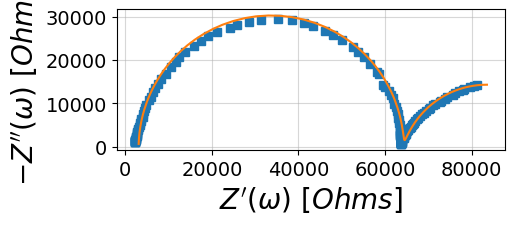


Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 3.08e+03 [Ohm]
    R_1 = 6.12e+04 [Ohm]
  CPE_1_0 = 2.87e-10 [Ohm^-1 sec^a]
  CPE_1_1 = 9.93e-01 []
    R_2 = 3.85e+04 [Ohm]
  CPE_2_0 = 5.82e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 8.13e-01 []

Fit parameters:
    R_0 = 3.08e+03  (+/- 1.17e+02) [Ohm]
    R_1 = 6.12e+04  (+/- 1.98e+02) [Ohm]
  CPE_1_0 = 2.87e-10  (+/- 4.91e-11) [Ohm^-1 sec^a]
  CPE_1_1 = 9.93e-01  (+/- 6.81e-04) []
    R_2 = 3.85e+04  (+/- 1.23e+01) [Ohm]
  CPE_2_0 = 5.82e-06  (+/- 1.37e-07) [Ohm^-1 sec^a]
  CPE_2_1 = 8.13e-01  (+/- 8.93e-03) []

     Re(Z)_fit  Img(Z)_fit
0  3093.203206  619.015307
1  3095.120994  678.270195
2  3097.345764  742.965896
3  3099.940101  813.845530
4  3102.990888  891.997618


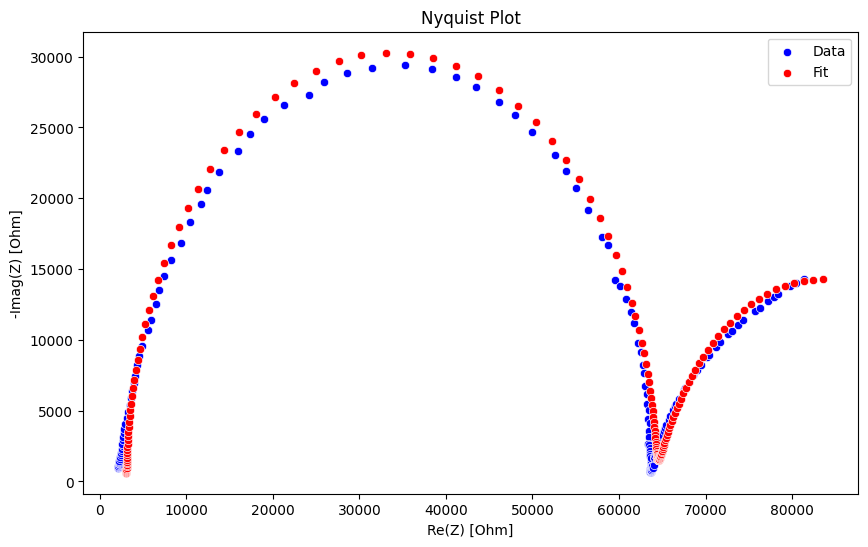

Circuit Type 1

Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 3.08e+03 [Ohm]
    R_1 = 6.12e+04 [Ohm]
  CPE_1_0 = 2.87e-10 [Ohm^-1 sec^a]
  CPE_1_1 = 9.93e-01 []
    R_2 = 3.85e+04 [Ohm]
  CPE_2_0 = 5.82e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 8.13e-01 []

Fit parameters:
    R_0 = 3.08e+03  (+/- 1.17e+02) [Ohm]
    R_1 = 6.12e+04  (+/- 1.98e+02) [Ohm]
  CPE_1_0 = 2.87e-10  (+/- 4.91e-11) [Ohm^-1 sec^a]
  CPE_1_1 = 9.93e-01  (+/- 6.81e-04) []
    R_2 = 3.85e+04  (+/- 1.23e+01) [Ohm]
  CPE_2_0 = 5.82e-06  (+/- 1.37e-07) [Ohm^-1 sec^a]
  CPE_2_1 = 8.13e-01  (+/- 8.93e-03) []



In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import seaborn as sns

# Load and process the input data
df = pd.read_csv('predicted_data_for_fitting.csv')

# Filter and drop specific columns
df = df[df['Ionic radius '] == 2.060000e-10]
# df = df[df['Ionic radius '] == 1.820000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == 60]
df = df.drop(columns=['Temperature'])
df = df.reset_index(drop=True)

# Rename columns and adjust values
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
df['Img(Z)'] = df['Img(Z)'] * -1
df.to_csv('temp/60(2).csv', index=False)

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('temp/60(2).csv')

# Remove NaN values
mask = ~np.isnan(Z)
frequencies, Z = frequencies[mask], Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Initial guess for the circuit parameters
initial_guess=[3.08e+03,  6.12e+04  ,2.87e-10, 9.93e-01, 3.85e+04, 5.82e-06,8.13e-01]

# Circuit string
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'

# Fit and plot the circuit
customCircuit = fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Save the DataFrames to CSV
Z_df.to_csv('temp/Z60(2).csv', index=False)
Z_fit_df.to_csv('temp/Z_fit60(2).csv', index=False)

# Load data for plotting
plot_data = pd.read_csv('temp/Z60(2).csv')
plot_data_fit = pd.read_csv('temp/Z_fit60(2).csv')

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.scatterplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', 1)
print(customCircuit)


## 20-1

frequencies: [1.00e+06 9.26e+05 8.58e+05 7.94e+05 7.36e+05 6.81e+05 6.31e+05 5.84e+05
 5.41e+05 5.01e+05 4.64e+05 4.30e+05 3.98e+05 3.69e+05 3.41e+05 3.16e+05
 2.93e+05 2.71e+05 2.51e+05 2.33e+05 2.15e+05 2.00e+05 1.85e+05 1.71e+05
 1.58e+05 1.47e+05 1.36e+05 1.26e+05 1.17e+05 1.08e+05 1.00e+05 9.26e+04
 8.58e+04 7.94e+04 7.36e+04 6.81e+04 6.31e+04 5.84e+04 5.41e+04 5.01e+04
 4.64e+04 4.30e+04 3.98e+04 3.69e+04 3.41e+04 3.16e+04 2.93e+04 2.71e+04
 2.51e+04 2.33e+04 2.15e+04 1.99e+04 1.85e+04 1.71e+04 1.58e+04 1.47e+04
 1.36e+04 1.26e+04 1.17e+04 1.08e+04 1.00e+04 9.26e+03 8.57e+03 7.94e+03
 7.35e+03 6.81e+03 6.31e+03 5.84e+03 5.41e+03 5.01e+03 4.64e+03 4.30e+03
 3.98e+03 3.69e+03 3.42e+03 3.16e+03 2.93e+03 2.71e+03 2.51e+03 2.33e+03
 2.15e+03 2.00e+03 1.85e+03 1.71e+03 1.58e+03 1.47e+03 1.36e+03 1.26e+03
 1.17e+03 1.08e+03 1.00e+03 9.26e+02 8.58e+02 7.94e+02 7.36e+02 6.81e+02
 6.31e+02 5.84e+02 5.41e+02 5.01e+02 4.64e+02 4.30e+02 3.98e+02 3.69e+02
 3.41e+02 3.16e+02 2.93e+02 2.71e+02 2

/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


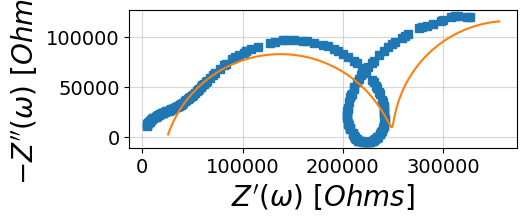


Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 1.03e+02 [Ohm]
    R_1 = 1.10e+04 [Ohm]
  CPE_1_0 = 7.49e-08 [Ohm^-1 sec^a]
  CPE_1_1 = 8.89e-01 []
    R_2 = 6.81e-09 [Ohm]
  CPE_2_0 = 6.39e-04 [Ohm^-1 sec^a]
  CPE_2_1 = 4.21e-01 []

Fit parameters:
    R_0 = 2.48e+04  (+/- 1.60e+03) [Ohm]
    R_1 = 2.26e+05  (+/- 8.14e+02) [Ohm]
  CPE_1_0 = 1.17e-09  (+/- 3.36e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 8.06e-01  (+/- 3.98e-03) []
    R_2 = 2.32e+05  (+/- 3.12e+01) [Ohm]
  CPE_2_0 = 7.51e-07  (+/- 5.95e-08) [Ohm^-1 sec^a]
  CPE_2_1 = 1.00e+00  (+/- 2.87e-02) []

      Re(Z)_fit   Img(Z)_fit
0  25726.891643  2697.471728
1  25785.428190  2868.407674
2  25847.445750  3048.586911
3  25914.798139  3243.206164
4  25985.219763  3445.532170


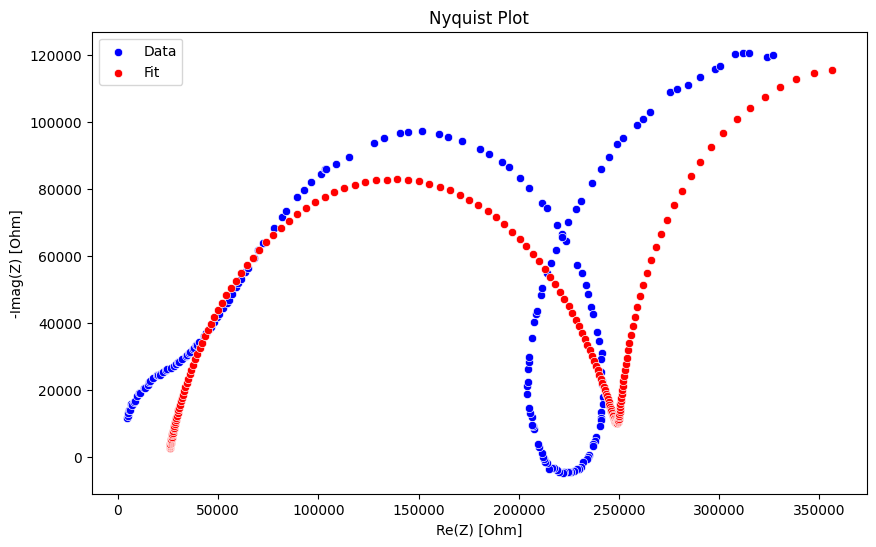

Circuit Type 1


In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import seaborn as sns

# Load and process the input data
df = pd.read_csv('predicted_data_for_fitting.csv')

# Filter and drop specific columns
df = df[df['Ionic radius '] == 1.820000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == 20]
df = df.drop(columns=['Temperature'])
df = df.reset_index(drop=True)

# Rename columns and adjust values
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
df['Img(Z)'] = df['Img(Z)'] * -1
df.to_csv('temp/20(1).csv', index=False)

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('temp/20(1).csv')


# Remove NaN values
mask = ~np.isnan(Z)
frequencies, Z = frequencies[mask], Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Initial guess for the circuit parameters
initial_guess=[1.02735900e+02, 1.10336218e+04, 0.74942200e-07, 8.8892283e-01, 6.81108488e-09, 6.39210091e-04, 4.20690396e-01 ]
# Circuit string
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'

# Fit and plot the circuit
customCircuit = fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Save the DataFrames to CSV
Z_df.to_csv('temp/Z20(1).csv', index=False)
Z_fit_df.to_csv('temp/Z_fit20(1).csv', index=False)

# Load data for plotting
plot_data = pd.read_csv('temp/Z20(1).csv')
plot_data_fit = pd.read_csv('temp/Z_fit20(1).csv')

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.scatterplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', 1)
# print(customCircuit)

## 20-2

frequencies: [1.00e+06 9.12e+05 8.32e+05 7.59e+05 6.92e+05 6.31e+05 5.75e+05 5.25e+05
 4.79e+05 4.37e+05 3.98e+05 3.63e+05 3.31e+05 3.02e+05 2.75e+05 2.51e+05
 2.29e+05 2.09e+05 1.91e+05 1.74e+05 1.58e+05 1.45e+05 1.32e+05 1.20e+05
 1.10e+05 1.00e+05 9.12e+04 8.32e+04 7.59e+04 6.92e+04 6.31e+04 5.75e+04
 5.25e+04 4.79e+04 4.37e+04 3.98e+04 3.63e+04 3.31e+04 3.02e+04 2.75e+04
 2.51e+04 2.29e+04 2.09e+04 1.91e+04 1.74e+04 1.58e+04 1.45e+04 1.32e+04
 1.20e+04 1.10e+04 1.00e+04 9.12e+03 8.32e+03 7.59e+03 6.92e+03 6.31e+03
 5.75e+03 5.25e+03 4.79e+03 4.37e+03 3.98e+03 3.63e+03 3.31e+03 3.02e+03
 2.75e+03 2.51e+03 2.29e+03 2.09e+03 1.91e+03 1.74e+03 1.58e+03 1.45e+03
 1.32e+03 1.20e+03 1.10e+03 1.00e+03 9.12e+02 8.32e+02 7.59e+02 6.92e+02
 6.31e+02 5.75e+02 5.25e+02 4.79e+02 4.37e+02 3.98e+02 3.63e+02 3.31e+02
 3.02e+02 2.75e+02 2.51e+02 2.29e+02 2.09e+02 1.91e+02 1.74e+02 1.58e+02
 1.45e+02 1.32e+02 1.20e+02 1.10e+02 1.00e+02 9.12e+01 8.32e+01 7.59e+01
 6.92e+01 6.31e+01 5.75e+01 5.25e+01 4

/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


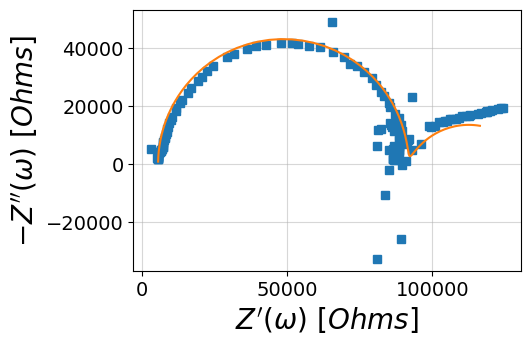


Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 9.77e+01 [Ohm]
    R_1 = 1.43e+04 [Ohm]
  CPE_1_0 = 1.52e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.59e-01 []
    R_2 = 5.98e+01 [Ohm]
  CPE_2_0 = 8.20e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 8.32e-01 []

Fit parameters:
    R_0 = 5.53e+03  (+/- 9.19e+02) [Ohm]
    R_1 = 8.60e+04  (+/- 1.96e+03) [Ohm]
  CPE_1_0 = 2.10e-10  (+/- 3.32e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 9.99e-01  (+/- 4.02e-03) []
    R_2 = 4.20e+04  (+/- 2.79e+02) [Ohm]
  CPE_2_0 = 4.84e-06  (+/- 8.17e-07) [Ohm^-1 sec^a]
  CPE_2_1 = 7.24e-01  (+/- 6.01e-02) []

     Re(Z)_fit   Img(Z)_fit
0  5536.517050   776.569291
1  5538.153897   851.317517
2  5540.088073   932.972388
3  5542.383807  1022.480201
4  5545.129800  1121.225671


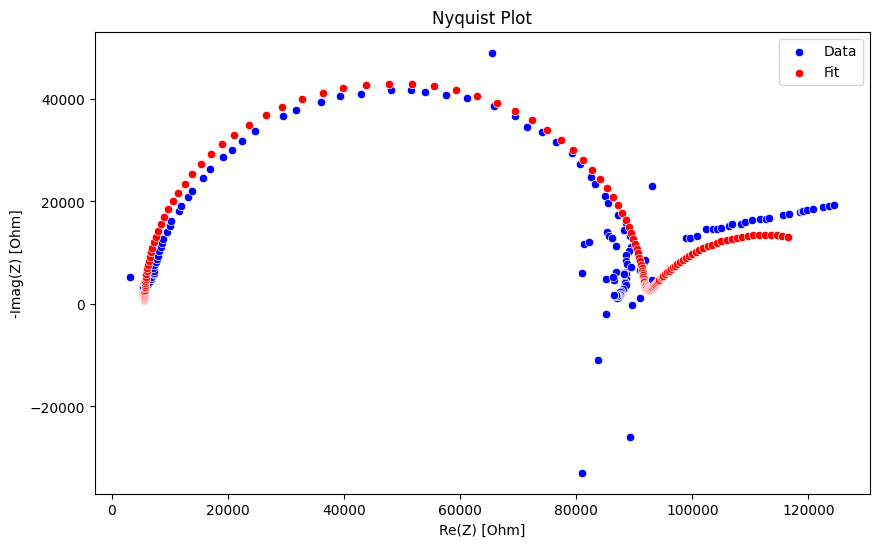

Circuit Type 1

Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 9.77e+01 [Ohm]
    R_1 = 1.43e+04 [Ohm]
  CPE_1_0 = 1.52e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.59e-01 []
    R_2 = 5.98e+01 [Ohm]
  CPE_2_0 = 8.20e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 8.32e-01 []

Fit parameters:
    R_0 = 5.53e+03  (+/- 9.19e+02) [Ohm]
    R_1 = 8.60e+04  (+/- 1.96e+03) [Ohm]
  CPE_1_0 = 2.10e-10  (+/- 3.32e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 9.99e-01  (+/- 4.02e-03) []
    R_2 = 4.20e+04  (+/- 2.79e+02) [Ohm]
  CPE_2_0 = 4.84e-06  (+/- 8.17e-07) [Ohm^-1 sec^a]
  CPE_2_1 = 7.24e-01  (+/- 6.01e-02) []



In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import seaborn as sns

# Load and process the input data
df = pd.read_csv('predicted_data_for_fitting.csv')

# Filter and drop specific columns
df = df[df['Ionic radius '] == 2.060000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == 20]
df = df.drop(columns=['Temperature'])
df = df.reset_index(drop=True)

# Rename columns and adjust values
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
df['Img(Z)'] = df['Img(Z)'] * -1
df.to_csv('temp/20(2).csv', index=False)

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('temp/20(2).csv')


# Remove NaN values
mask = ~np.isnan(Z)
frequencies, Z = frequencies[mask], Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Initial guess for the circuit parameters
initial_guess = [9.7711e+01 , 1.431e+04, 1.521e-14,  8.592e-01,   5.982e+01, 8.197e-06 ,  8.315e-01 ]

# Circuit string
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'

# Fit and plot the circuit
customCircuit = fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Save the DataFrames to CSV
Z_df.to_csv('temp/Z20(2).csv', index=False)
Z_fit_df.to_csv('temp/Z_fit20(2).csv', index=False)

# Load data for plotting
plot_data = pd.read_csv('temp/Z20(2).csv')
plot_data_fit = pd.read_csv('temp/Z_fit20(2).csv')

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.scatterplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', 1)
print(customCircuit)

## 25

frequencies: [1.00e+06 9.12e+05 8.32e+05 7.59e+05 6.92e+05 6.31e+05 5.75e+05 5.25e+05
 4.79e+05 4.37e+05 3.98e+05 3.63e+05 3.31e+05 3.02e+05 2.75e+05 2.51e+05
 2.29e+05 2.09e+05 1.91e+05 1.74e+05 1.58e+05 1.45e+05 1.32e+05 1.20e+05
 1.10e+05 1.00e+05 9.12e+04 8.32e+04 7.59e+04 6.92e+04 6.31e+04 5.75e+04
 5.25e+04 4.79e+04 4.37e+04 3.98e+04 3.63e+04 3.31e+04 3.02e+04 2.75e+04
 2.51e+04 2.29e+04 2.09e+04 1.91e+04 1.74e+04 1.58e+04 1.45e+04 1.32e+04
 1.20e+04 1.10e+04 1.00e+04 9.12e+03 8.32e+03 7.59e+03 6.92e+03 6.31e+03
 5.75e+03 5.25e+03 4.79e+03 4.37e+03 3.98e+03 3.63e+03 3.31e+03 3.02e+03
 2.75e+03 2.51e+03 2.29e+03 2.09e+03 1.91e+03 1.74e+03 1.58e+03 1.45e+03
 1.32e+03 1.20e+03 1.10e+03 1.00e+03 9.12e+02 8.32e+02 7.59e+02 6.92e+02
 6.31e+02 5.75e+02 5.25e+02 4.79e+02 4.37e+02 3.98e+02 3.63e+02 3.31e+02
 3.02e+02 2.75e+02 2.51e+02 2.29e+02 2.09e+02 1.91e+02 1.74e+02 1.58e+02
 1.45e+02 1.32e+02 1.20e+02 1.10e+02 1.00e+02 9.12e+01 8.32e+01 7.59e+01
 6.92e+01 6.31e+01 5.75e+01 5.25e+01 4

/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


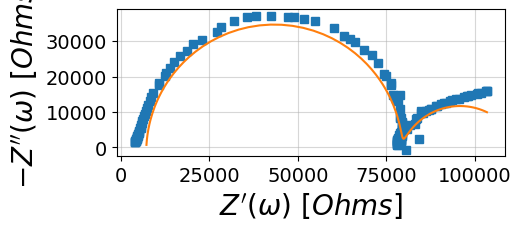


Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 2.02e+02 [Ohm]
    R_1 = 1.35e+04 [Ohm]
  CPE_1_0 = 1.96e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.13e-01 []
    R_2 = 3.79e+00 [Ohm]
  CPE_2_0 = 8.02e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.01e-01 []

Fit parameters:
    R_0 = 7.24e+03  (+/- 3.52e+02) [Ohm]
    R_1 = 7.21e+04  (+/- 6.33e+02) [Ohm]
  CPE_1_0 = 3.29e-10  (+/- 1.37e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 9.74e-01  (+/- 1.82e-03) []
    R_2 = 3.29e+04  (+/- 1.24e+02) [Ohm]
  CPE_2_0 = 3.68e-06  (+/- 2.81e-07) [Ohm^-1 sec^a]
  CPE_2_1 = 7.86e-01  (+/- 2.22e-02) []

     Re(Z)_fit   Img(Z)_fit
0  7274.205201   720.755280
1  7278.362991   788.345800
2  7283.038382   862.007663
3  7288.323490   942.562486
4  7294.348211  1031.218118


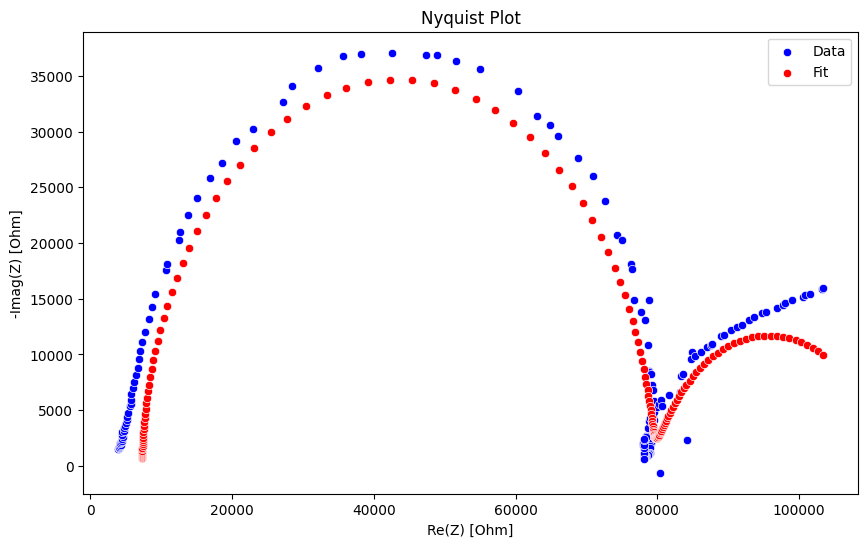

Circuit Type 1

Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 2.02e+02 [Ohm]
    R_1 = 1.35e+04 [Ohm]
  CPE_1_0 = 1.96e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.13e-01 []
    R_2 = 3.79e+00 [Ohm]
  CPE_2_0 = 8.02e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.01e-01 []

Fit parameters:
    R_0 = 7.24e+03  (+/- 3.52e+02) [Ohm]
    R_1 = 7.21e+04  (+/- 6.33e+02) [Ohm]
  CPE_1_0 = 3.29e-10  (+/- 1.37e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 9.74e-01  (+/- 1.82e-03) []
    R_2 = 3.29e+04  (+/- 1.24e+02) [Ohm]
  CPE_2_0 = 3.68e-06  (+/- 2.81e-07) [Ohm^-1 sec^a]
  CPE_2_1 = 7.86e-01  (+/- 2.22e-02) []



In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import seaborn as sns

# Load and process the input data
df = pd.read_csv('predicted_data_for_fitting.csv')

# Filter and drop specific columns
df = df[df['Ionic radius '] == 2.060000e-10]
# df = df[df['Ionic radius '] == 1.820000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == 25]
df = df.drop(columns=['Temperature'])
df = df.reset_index(drop=True)

# Rename columns and adjust values
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
df['Img(Z)'] = df['Img(Z)'] * -1
df.to_csv('temp/25.csv', index=False)

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('temp/25.csv')


# Remove NaN values
mask = ~np.isnan(Z)
frequencies, Z = frequencies[mask], Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Initial guess for the circuit parameters
initial_guess=[20.15735900e+01, 13.4940999e+03, 19.61994920e-15, 8.13190283e-01, 3.79329481e-00, 8.01916291e-06, 9.00890496e-01 ]
# Circuit string
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'

# Fit and plot the circuit
customCircuit = fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Save the DataFrames to CSV
Z_df.to_csv('temp/Z25.csv', index=False)
Z_fit_df.to_csv('temp/Z_fit25.csv', index=False)

# Load data for plotting
plot_data = pd.read_csv('temp/Z25.csv')
plot_data_fit = pd.read_csv('temp/Z_fit25.csv')

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.scatterplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', 1)
print(customCircuit)

frequencies: [1.00e+06 9.12e+05 8.32e+05 7.59e+05 6.92e+05 6.31e+05 5.75e+05 5.25e+05
 4.79e+05 4.37e+05 3.98e+05 3.63e+05 3.31e+05 3.02e+05 2.75e+05 2.51e+05
 2.29e+05 2.09e+05 1.91e+05 1.74e+05 1.58e+05 1.45e+05 1.32e+05 1.20e+05
 1.10e+05 1.00e+05 9.12e+04 8.32e+04 7.59e+04 6.92e+04 6.31e+04 5.75e+04
 5.25e+04 4.79e+04 4.37e+04 3.98e+04 3.63e+04 3.31e+04 3.02e+04 2.75e+04
 2.51e+04 2.29e+04 2.09e+04 1.91e+04 1.74e+04 1.58e+04 1.45e+04 1.32e+04
 1.20e+04 1.10e+04 1.00e+04 9.12e+03 8.32e+03 7.59e+03 6.92e+03 6.31e+03
 5.75e+03 5.25e+03 4.79e+03 4.37e+03 3.98e+03 3.63e+03 3.31e+03 3.02e+03
 2.75e+03 2.51e+03 2.29e+03 2.09e+03 1.91e+03 1.74e+03 1.58e+03 1.45e+03
 1.32e+03 1.20e+03 1.10e+03 1.00e+03 9.12e+02 8.32e+02 7.59e+02 6.92e+02
 6.31e+02 5.75e+02 5.25e+02 4.79e+02 4.37e+02 3.98e+02 3.63e+02 3.31e+02
 3.02e+02 2.75e+02 2.51e+02 2.29e+02 2.09e+02 1.91e+02 1.74e+02 1.58e+02
 1.45e+02 1.32e+02 1.20e+02 1.10e+02 1.00e+02 9.12e+01 8.32e+01 7.59e+01
 6.92e+01 6.31e+01 5.75e+01 5.25e+01 4

/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


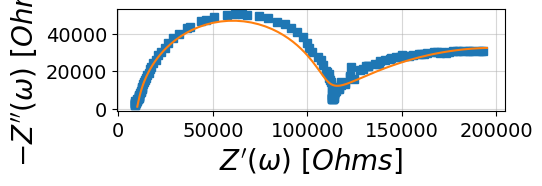


Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 2.00e+02 [Ohm]
    R_1 = 1.36e+04 [Ohm]
  CPE_1_0 = 1.61e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.01e-01 []
    R_2 = 3.80e+00 [Ohm]
  CPE_2_0 = 8.37e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.01e-01 []

Fit parameters:
    R_0 = 9.51e+03  (+/- 6.45e+02) [Ohm]
    R_1 = 9.35e+04  (+/- 1.15e+01) [Ohm]
  CPE_1_0 = 2.75e-10  (+/- 1.30e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 9.67e-01  (+/- 1.96e-03) []
    R_2 = 1.92e+05  (+/- 9.24e+00) [Ohm]
  CPE_2_0 = 2.62e-06  (+/- 7.33e-08) [Ohm^-1 sec^a]
  CPE_2_1 = 4.15e-01  (+/- 7.29e-03) []

      Re(Z)_fit   Img(Z)_fit
0  10026.890396  1315.921744
1  10051.384721  1419.392647
2  10077.297318  1531.346635
3  10104.854330  1652.931332
4  10134.401070  1785.851568


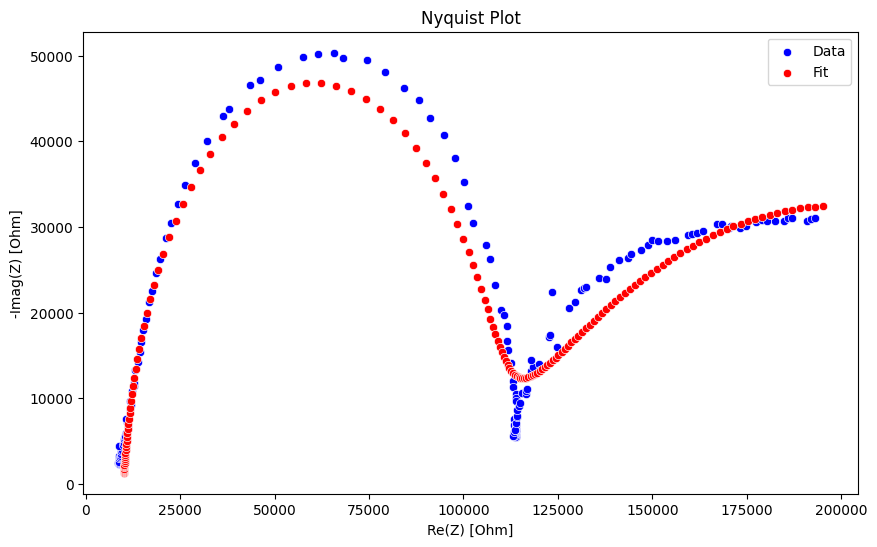

Circuit Type 1

Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 2.00e+02 [Ohm]
    R_1 = 1.36e+04 [Ohm]
  CPE_1_0 = 1.61e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.01e-01 []
    R_2 = 3.80e+00 [Ohm]
  CPE_2_0 = 8.37e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.01e-01 []

Fit parameters:
    R_0 = 9.51e+03  (+/- 6.45e+02) [Ohm]
    R_1 = 9.35e+04  (+/- 1.15e+01) [Ohm]
  CPE_1_0 = 2.75e-10  (+/- 1.30e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 9.67e-01  (+/- 1.96e-03) []
    R_2 = 1.92e+05  (+/- 9.24e+00) [Ohm]
  CPE_2_0 = 2.62e-06  (+/- 7.33e-08) [Ohm^-1 sec^a]
  CPE_2_1 = 4.15e-01  (+/- 7.29e-03) []



In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import seaborn as sns

# Load and process the input data
df = pd.read_csv('predicted_data_for_fitting.csv')

# Filter and drop specific columns
df = df[df['Ionic radius '] == 2.060000e-10]
# df = df[df['Ionic radius '] == 1.820000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == -5]
df = df.drop(columns=['Temperature'])
df = df.reset_index(drop=True)

# Rename columns and adjust values
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
df['Img(Z)'] = df['Img(Z)'] * -1
df.to_csv('temp/-5.csv', index=False)

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('temp/-5.csv')

# Remove NaN values
mask = ~np.isnan(Z)
frequencies, Z = frequencies[mask], Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Initial guess for the circuit parameters
initial_guess=[20.02735900e+01, 13.5748999e+03, 16.07494220e-15, 8.01192283e-01, 3.80319480e-00, 8.37210091e-06, 9.00690396e-01 ]
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'

# Fit and plot the circuit
customCircuit = fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Save the DataFrames to CSV
Z_df.to_csv('temp/Z-5.csv', index=False)
Z_fit_df.to_csv('temp/Z_fit-5.csv', index=False)

# Load data for plotting
plot_data = pd.read_csv('temp/Z-5.csv')
plot_data_fit = pd.read_csv('temp/Z_fit-5.csv')

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.scatterplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', 1)
print(customCircuit)

##-5

frequencies: [1.00e+06 9.12e+05 8.32e+05 7.59e+05 6.92e+05 6.31e+05 5.75e+05 5.25e+05
 4.79e+05 4.37e+05 3.98e+05 3.63e+05 3.31e+05 3.02e+05 2.75e+05 2.51e+05
 2.29e+05 2.09e+05 1.91e+05 1.74e+05 1.58e+05 1.45e+05 1.32e+05 1.20e+05
 1.10e+05 1.00e+05 9.12e+04 8.32e+04 7.59e+04 6.92e+04 6.31e+04 5.75e+04
 5.25e+04 4.79e+04 4.37e+04 3.98e+04 3.63e+04 3.31e+04 3.02e+04 2.75e+04
 2.51e+04 2.29e+04 2.09e+04 1.91e+04 1.74e+04 1.58e+04 1.45e+04 1.32e+04
 1.20e+04 1.10e+04 1.00e+04 9.12e+03 8.32e+03 7.59e+03 6.92e+03 6.31e+03
 5.75e+03 5.25e+03 4.79e+03 4.37e+03 3.98e+03 3.63e+03 3.31e+03 3.02e+03
 2.75e+03 2.51e+03 2.29e+03 2.09e+03 1.91e+03 1.74e+03 1.58e+03 1.45e+03
 1.32e+03 1.20e+03 1.10e+03 1.00e+03 9.12e+02 8.32e+02 7.59e+02 6.92e+02
 6.31e+02 5.75e+02 5.25e+02 4.79e+02 4.37e+02 3.98e+02 3.63e+02 3.31e+02
 3.02e+02 2.75e+02 2.51e+02 2.29e+02 2.09e+02 1.91e+02 1.74e+02 1.58e+02
 1.45e+02 1.32e+02 1.20e+02 1.10e+02 1.00e+02 9.12e+01 8.32e+01 7.59e+01
 6.92e+01 6.31e+01 5.75e+01 5.25e+01 4

/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


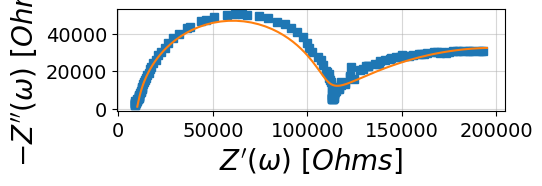


Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 2.00e+02 [Ohm]
    R_1 = 1.36e+04 [Ohm]
  CPE_1_0 = 1.61e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.01e-01 []
    R_2 = 3.80e+00 [Ohm]
  CPE_2_0 = 8.37e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.01e-01 []

Fit parameters:
    R_0 = 9.51e+03  (+/- 6.45e+02) [Ohm]
    R_1 = 9.35e+04  (+/- 1.15e+01) [Ohm]
  CPE_1_0 = 2.75e-10  (+/- 1.30e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 9.67e-01  (+/- 1.96e-03) []
    R_2 = 1.92e+05  (+/- 9.24e+00) [Ohm]
  CPE_2_0 = 2.62e-06  (+/- 7.33e-08) [Ohm^-1 sec^a]
  CPE_2_1 = 4.15e-01  (+/- 7.29e-03) []

      Re(Z)_fit   Img(Z)_fit
0  10026.890396  1315.921744
1  10051.384721  1419.392647
2  10077.297318  1531.346635
3  10104.854330  1652.931332
4  10134.401070  1785.851568


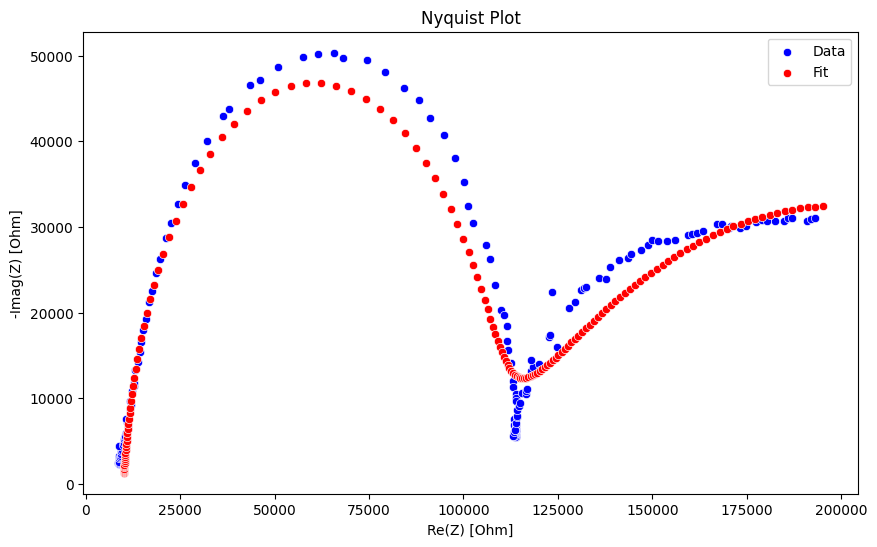

Circuit Type 1

Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 2.00e+02 [Ohm]
    R_1 = 1.36e+04 [Ohm]
  CPE_1_0 = 1.61e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.01e-01 []
    R_2 = 3.80e+00 [Ohm]
  CPE_2_0 = 8.37e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.01e-01 []

Fit parameters:
    R_0 = 9.51e+03  (+/- 6.45e+02) [Ohm]
    R_1 = 9.35e+04  (+/- 1.15e+01) [Ohm]
  CPE_1_0 = 2.75e-10  (+/- 1.30e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 9.67e-01  (+/- 1.96e-03) []
    R_2 = 1.92e+05  (+/- 9.24e+00) [Ohm]
  CPE_2_0 = 2.62e-06  (+/- 7.33e-08) [Ohm^-1 sec^a]
  CPE_2_1 = 4.15e-01  (+/- 7.29e-03) []



In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import seaborn as sns

# Load and process the input data
df = pd.read_csv('predicted_data_for_fitting.csv')

# Filter and drop specific columns
df = df[df['Ionic radius '] == 2.060000e-10]
# df = df[df['Ionic radius '] == 1.820000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == -5]
df = df.drop(columns=['Temperature'])
df = df.reset_index(drop=True)

# Rename columns and adjust values
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
df['Img(Z)'] = df['Img(Z)'] * -1
df.to_csv('temp/-5.csv', index=False)

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('temp/-5.csv')

# Remove NaN values
mask = ~np.isnan(Z)
frequencies, Z = frequencies[mask], Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Initial guess for the circuit parameters
initial_guess=[20.02735900e+01, 13.5748999e+03, 16.07494220e-15, 8.01192283e-01, 3.80319480e-00, 8.37210091e-06, 9.00690396e-01 ]
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'

# Fit and plot the circuit
customCircuit = fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Save the DataFrames to CSV
Z_df.to_csv('temp/Z-5.csv', index=False)
Z_fit_df.to_csv('temp/Z_fit-5.csv', index=False)

# Load data for plotting
plot_data = pd.read_csv('temp/Z-5.csv')
plot_data_fit = pd.read_csv('temp/Z_fit-5.csv')

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.scatterplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', 1)
print(customCircuit)

## 55

frequencies: [1.00e+06 9.12e+05 8.32e+05 7.59e+05 6.92e+05 6.31e+05 5.75e+05 5.25e+05
 4.79e+05 4.37e+05 3.98e+05 3.63e+05 3.31e+05 3.02e+05 2.75e+05 2.51e+05
 2.29e+05 2.09e+05 1.91e+05 1.74e+05 1.58e+05 1.45e+05 1.32e+05 1.20e+05
 1.10e+05 1.00e+05 9.12e+04 8.32e+04 7.59e+04 6.92e+04 6.31e+04 5.75e+04
 5.25e+04 4.79e+04 4.37e+04 3.98e+04 3.63e+04 3.31e+04 3.02e+04 2.75e+04
 2.51e+04 2.29e+04 2.09e+04 1.91e+04 1.74e+04 1.58e+04 1.45e+04 1.32e+04
 1.20e+04 1.10e+04 1.00e+04 9.12e+03 8.32e+03 7.59e+03 6.92e+03 6.31e+03
 5.75e+03 5.25e+03 4.79e+03 4.37e+03 3.98e+03 3.63e+03 3.31e+03 3.02e+03
 2.75e+03 2.51e+03 2.29e+03 2.09e+03 1.91e+03 1.74e+03 1.58e+03 1.45e+03
 1.32e+03 1.20e+03 1.10e+03 1.00e+03 9.12e+02 8.32e+02 7.59e+02 6.92e+02
 6.31e+02 5.75e+02 5.25e+02 4.79e+02 4.37e+02 3.98e+02 3.63e+02 3.31e+02
 3.02e+02 2.75e+02 2.51e+02 2.29e+02 2.09e+02 1.91e+02 1.74e+02 1.58e+02
 1.45e+02 1.32e+02 1.20e+02 1.10e+02 1.00e+02 9.12e+01 8.32e+01 7.59e+01
 6.92e+01 6.31e+01 5.75e+01 5.25e+01 4

/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)
/usr/local/lib/python3.10/dist-packages/impedance/visualization.py:39: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax.plot(np.real(Z), -np.imag(Z), fmt, **kwargs)


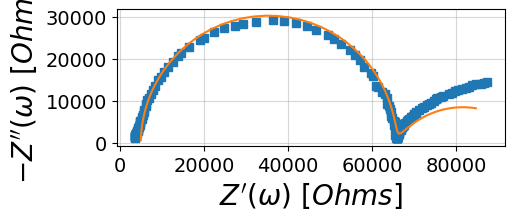


Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 1.60e+03 [Ohm]
    R_1 = 1.36e+04 [Ohm]
  CPE_1_0 = 1.49e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.94e-01 []
    R_2 = 3.33e+04 [Ohm]
  CPE_2_0 = 8.09e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.44e-01 []

Fit parameters:
    R_0 = 4.92e+03  (+/- 2.89e+02) [Ohm]
    R_1 = 6.05e+04  (+/- 6.97e+02) [Ohm]
  CPE_1_0 = 2.24e-10  (+/- 1.60e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 1.00e+00  (+/- 1.78e-03) []
    R_2 = 3.23e+04  (+/- 1.23e+02) [Ohm]
  CPE_2_0 = 7.32e-06  (+/- 5.23e-07) [Ohm^-1 sec^a]
  CPE_2_1 = 6.19e-01  (+/- 2.35e-02) []

     Re(Z)_fit   Img(Z)_fit
0  4932.856291   721.205068
1  4934.866091   790.490940
2  4937.230772   866.172543
3  4940.027393   949.125714
4  4943.362501  1040.632123


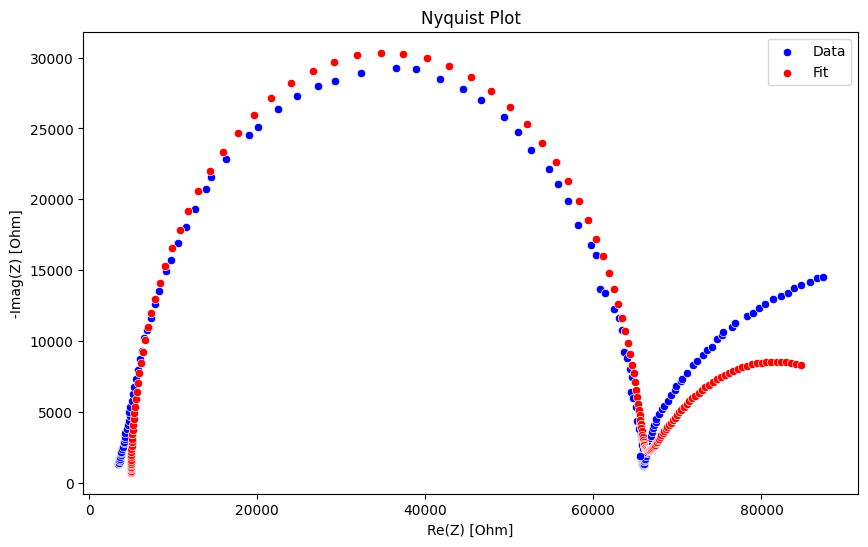

Circuit Type 1

Circuit string: R_0-p(R_1,CPE_1)-p(R_2,CPE_2)
Fit: True

Initial guesses:
    R_0 = 1.60e+03 [Ohm]
    R_1 = 1.36e+04 [Ohm]
  CPE_1_0 = 1.49e-14 [Ohm^-1 sec^a]
  CPE_1_1 = 8.94e-01 []
    R_2 = 3.33e+04 [Ohm]
  CPE_2_0 = 8.09e-06 [Ohm^-1 sec^a]
  CPE_2_1 = 9.44e-01 []

Fit parameters:
    R_0 = 4.92e+03  (+/- 2.89e+02) [Ohm]
    R_1 = 6.05e+04  (+/- 6.97e+02) [Ohm]
  CPE_1_0 = 2.24e-10  (+/- 1.60e-10) [Ohm^-1 sec^a]
  CPE_1_1 = 1.00e+00  (+/- 1.78e-03) []
    R_2 = 3.23e+04  (+/- 1.23e+02) [Ohm]
  CPE_2_0 = 7.32e-06  (+/- 5.23e-07) [Ohm^-1 sec^a]
  CPE_2_1 = 6.19e-01  (+/- 2.35e-02) []



In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import seaborn as sns

# Load and process the input data
df = pd.read_csv('predicted_data_for_fitting.csv')

# Filter and drop specific columns
df = df[df['Ionic radius '] == 2.060000e-10]
# df = df[df['Ionic radius '] == 1.820000e-10]
df = df.drop(columns=['Ionic radius '])
df = df[df['Temperature'] == 55]
df = df.drop(columns=['Temperature'])
df = df.reset_index(drop=True)

# Rename columns and adjust values
df.rename(columns={'Frequency': 'frequency'}, inplace=True)
df['Img(Z)'] = df['Img(Z)'] * -1
df.to_csv('temp/25.csv', index=False)

# Load the data for fitting
frequencies, Z = preprocessing.readCSV('temp/25.csv')
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)

# Remove NaN values
mask = ~np.isnan(Z)
frequencies, Z = frequencies[mask], Z[mask]

# Check the content of frequencies and Z
print(f"frequencies: {frequencies}")
print(f"Z: {Z}")
print(f"Shape of frequencies: {frequencies.shape}")
print(f"Shape of Z: {Z.shape}")

# Define the function to fit and plot the circuit
def fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str):
    customCircuit = CustomCircuit(initial_guess=initial_guess, circuit=circuit_str)
    customCircuit.fit(frequencies, Z)
    customCircuit.plot(f_data=frequencies, Z_data=Z, kind='nyquist')
    plt.show()
    print(customCircuit)
    return customCircuit

# Initial guess for the circuit parameters
initial_guess=[15.99735900e+02,  13.5548999e+03, 14.89994220e-15, 8.94e-01,3.33e+04, 8.09110191e-06,  9.437e-01]
# Circuit string
circuit_str = 'R_0-p(R_1,CPE_1)-p(R_2,CPE_2)'
# Fit and plot the circuit
customCircuit = fit_and_plot_circuit(frequencies, Z, initial_guess, circuit_str)

# Extract fitted values for plotting
Z_fit = customCircuit.predict(frequencies)

# Convert Z and Z_fit to a DataFrame
Z_df = pd.DataFrame({'Re(Z)': np.real(Z), 'Img(Z)': -np.imag(Z)})
Z_fit_df = pd.DataFrame({'Re(Z)_fit': np.real(Z_fit), 'Img(Z)_fit': -np.imag(Z_fit)})

# Save the DataFrames to CSV
Z_df.to_csv('temp/Z25.csv', index=False)
Z_fit_df.to_csv('temp/Z_fit25.csv', index=False)

# Load data for plotting
plot_data = pd.read_csv('temp/Z25.csv')
plot_data_fit = pd.read_csv('temp/Z_fit25.csv')

# Verify column names and inspect data
print(plot_data_fit.head())

# Adjust the plotting code to convert data to numpy arrays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Re(Z)', y='Img(Z)', data=plot_data, label='Data', color='blue')
sns.scatterplot(x=plot_data_fit['Re(Z)_fit'].values, y=plot_data_fit['Img(Z)_fit'].values, label='Fit', color='red')
plt.xlabel('Re(Z) [Ohm]')
plt.ylabel('-Imag(Z) [Ohm]')
plt.title('Nyquist Plot')
plt.legend()
plt.show()

print('Circuit Type', 1)
print(customCircuit)